In [1]:
! pip install tqdm
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


# Below plots are based on Tensorboard logs (not based on every iteration)

## Uncomment this in case csv files are not available

# Below plots are based on .pkl files as they are plotted based on each iteration

In [22]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)

softmatch = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/reset32_scaler_4_d3b0e90.pkl') # best_st_plot_60c84b7
softmatch_weights = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_0.5.pkl')
iou3d = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# iou3d = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/3diou.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
iou3d_old_thresh = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/iou3d_old_thresh2.pkl') 
# This is based on FG+UC+BG with class agnostic local thresholds , it needs a re-run to get the correct class agnostic scores based on UC_FP+BG
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/a8_scores.pkl') 
# ablation1_df = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl') 


# df2 =  pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_var_nan.pkl')
# scores_6 = pd.read_pickle(r'/mnt/data/deka01/openpcdet_st/tools/scores_6.pkl')


#### Generating TP and FP based on 3diouMatch Threshold FG = 0.75

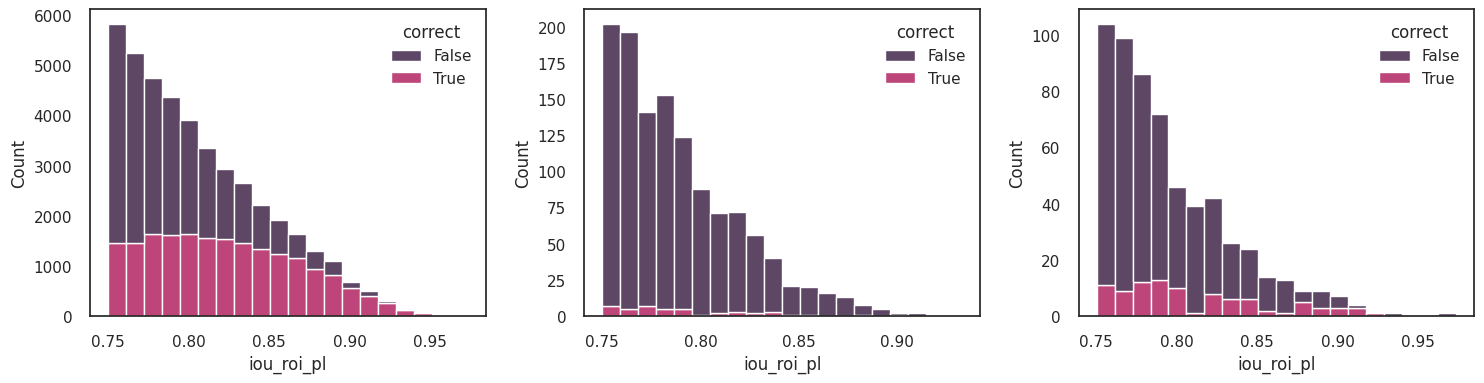

In [23]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores']
}
thresh_3diou = pd.DataFrame(scores)
thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] > 0.75) & (thresh_3diou['iou_roi_pl'] > 0.75)
thresh_3diou['filtered_wrt_pl'] = (thresh_3diou['iou_roi_pl'] > 0.75)
filtered_thresh_df = thresh_3diou[thresh_3diou['filtered_wrt_pl'] == True]
scores_cls = []
p = sns.color_palette('rocket')
palette = [p[0],p[2]]
f, axes = plt.subplots(1,3, figsize=(15,4))
for i in range(0,3):
    # thresh_3diou['correct'] = (thresh_3diou['iou_roi_gt'] >= 0.50) & (thresh_3diou['iou_roi_pl'] >= 0.50)
    mask = (thresh_3diou['class_labels'] == i+1) & (thresh_3diou['iou_roi_pl'] >= 0.75) 
    scores_cls.append(thresh_3diou[mask])
    sns.histplot(ax=axes[i],data=scores_cls[i], x="iou_roi_pl",hue='correct',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, palette=palette, alpha=0.8)
    #sns.lineplot(ax=axes[i],data=scores_cls[i], x=thresh_3diou.index,y="correct",palette=palette, alpha=0.8)
    f.tight_layout()
    f.subplots_adjust(wspace=0.25, hspace=0.2)
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [24]:
thresh_3diou['pred_scores']

0           1.080634
1          10.418470
2           0.404545
3           0.847471
4          -1.530079
             ...    
1412091    -3.424217
1412092   -10.724598
1412093    -2.249504
1412094    -9.197587
1412095    -0.692683
Name: pred_scores, Length: 1412096, dtype: float64

In [25]:
# watch out normalized only if not. 
values = torch.tensor(iou3d['pred_scores'],device='cuda')
values = values.sigmoid()
iou3d['pred_scores'] = values.tolist()

In [26]:
scores = {
    'iou_roi_gt': iou3d['iou_roi_gt'],
    'iou_roi_pl': iou3d['iou_roi_pl'],
    'iteration' : iou3d['iteration'],
    'class_labels': iou3d['class_labels'],
    'pred_scores': iou3d['pred_scores'],
}
iou3d_df = pd.DataFrame(scores)

In [126]:
threshold = 0.75
iou3d_df['threshold'] = threshold
iou3d_df['epoch'] = (iou3d_df['iteration']) // 24 + 1
iou3d_df['correct'] = (iou3d_df['iou_roi_pl'] >= threshold) & (iou3d_df['iou_roi_gt'] >= threshold)
iou3d_df['correct_pred'] = (iou3d_df['pred_scores'] >= threshold) & (iou3d_df['iou_roi_gt'] >= threshold)
iou3d_df['fg_wrt_gt'] = (iou3d_df['iou_roi_gt'] >= threshold)
grouped_df = iou3d_df.groupby('epoch')

# Plot Epochwise correspondance of 3dIOUMatch(with changed sem,global thresholds) with GTs 

#### Epoch 1-5

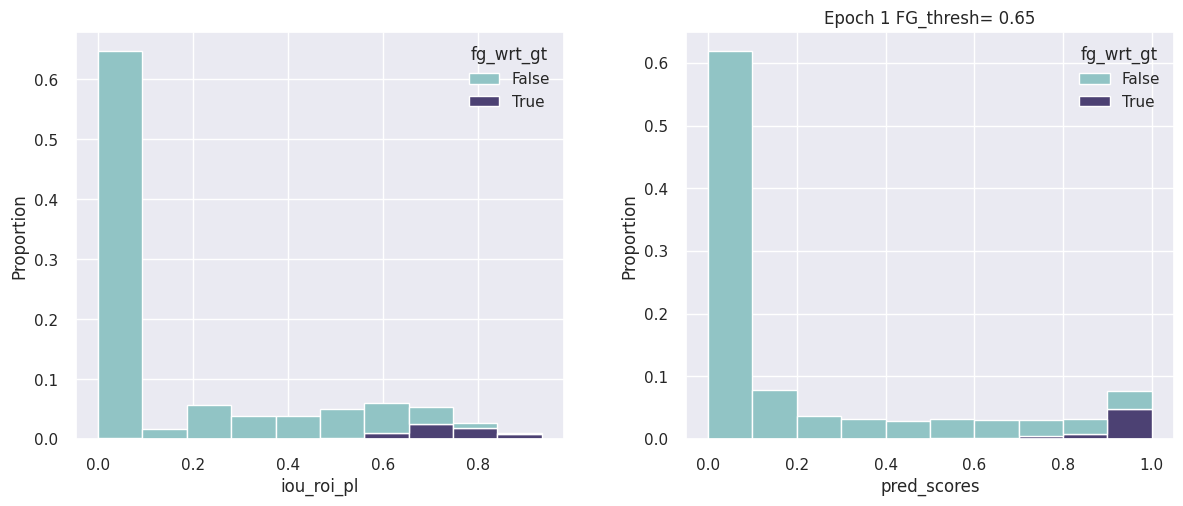

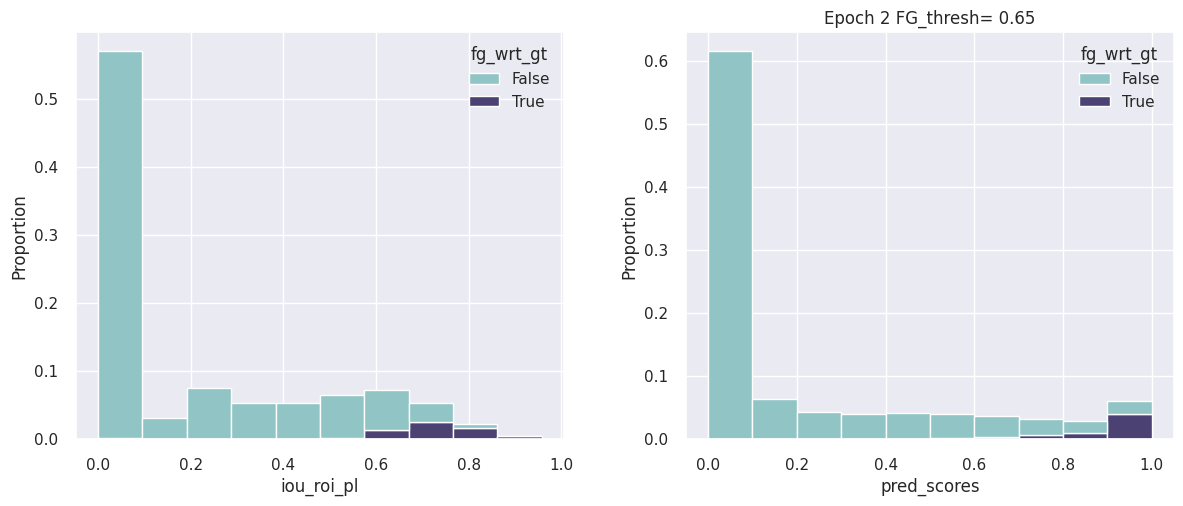

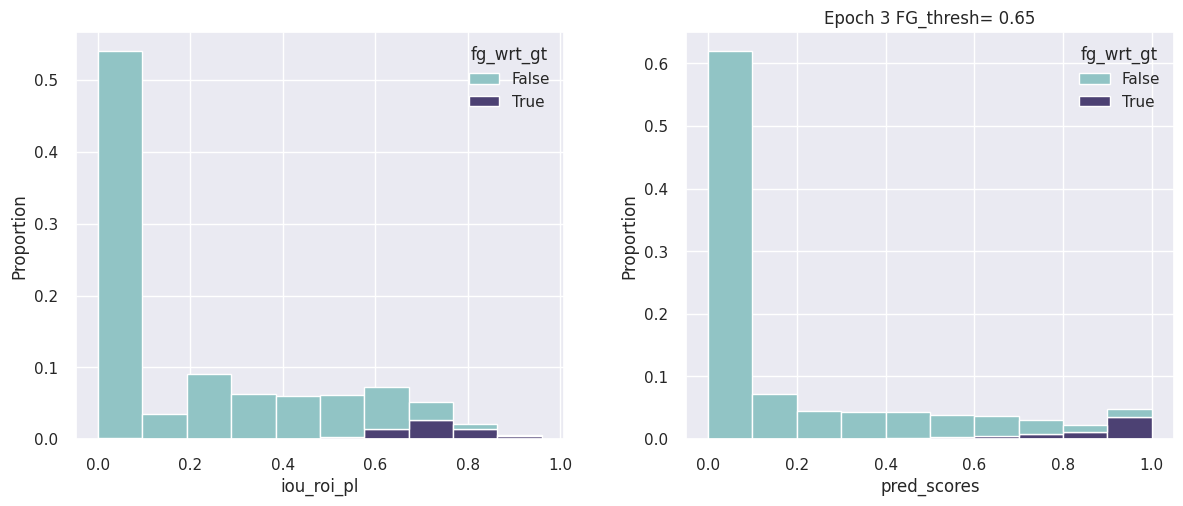

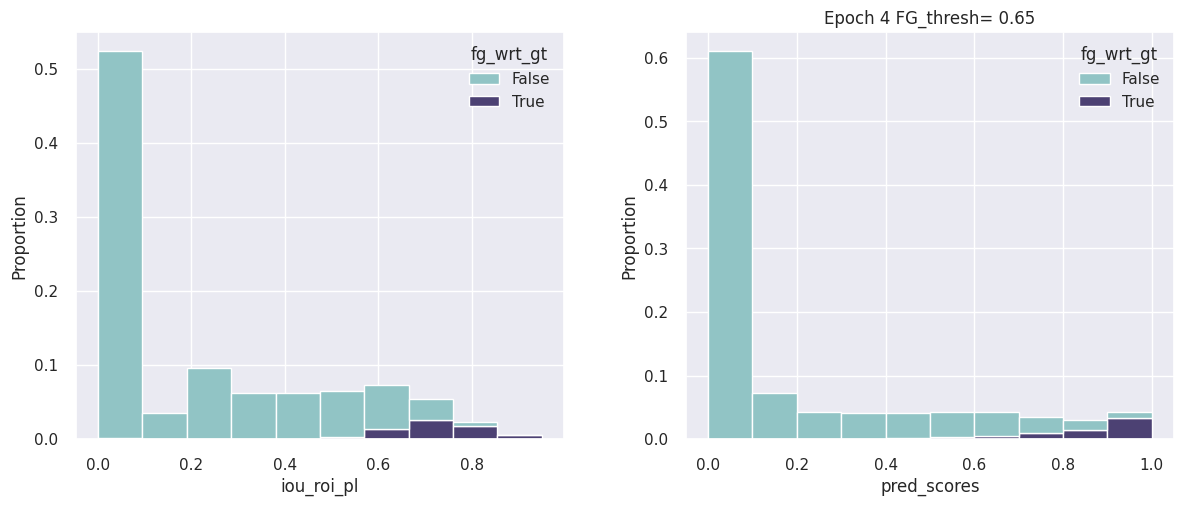

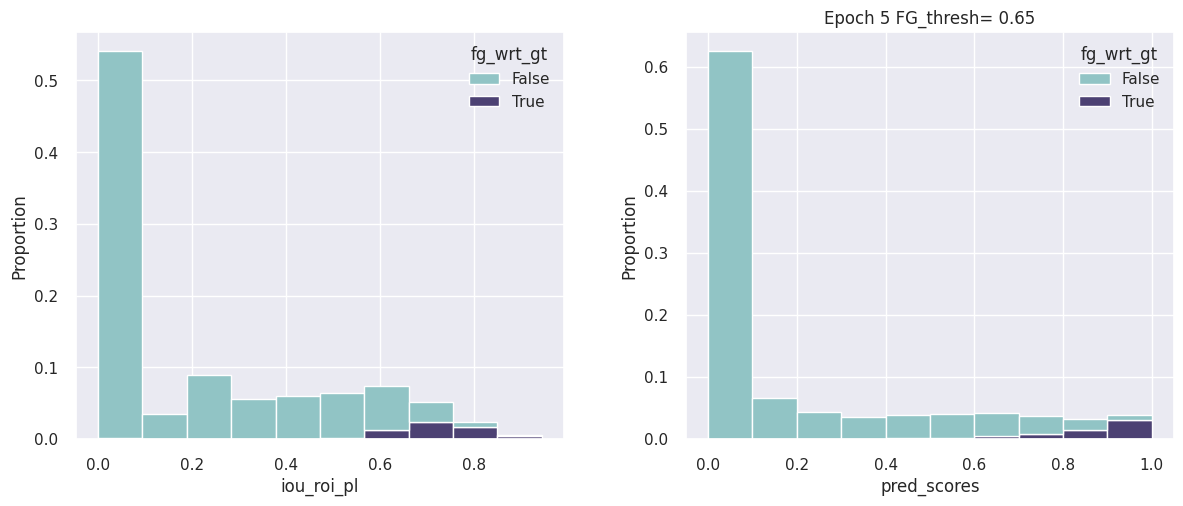

In [28]:
def plot_corres_gt(grouped_df,start,end):
    start = 1
    end = 6
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    # for i in range(0,3):
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(12,5))
        sns.histplot(ax=axes[0],data=grouped_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=10,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',fill=True,bins=10,palette=palette,alpha=1.0)
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
    f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()
plot_corres_gt(grouped_df,start=1,end=5)

#### Epochs 40-45

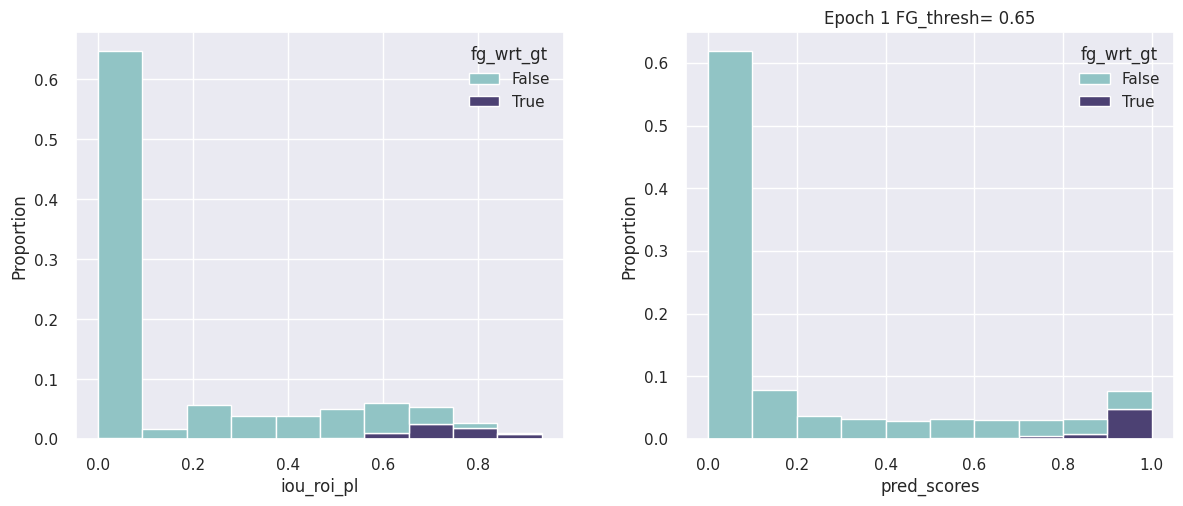

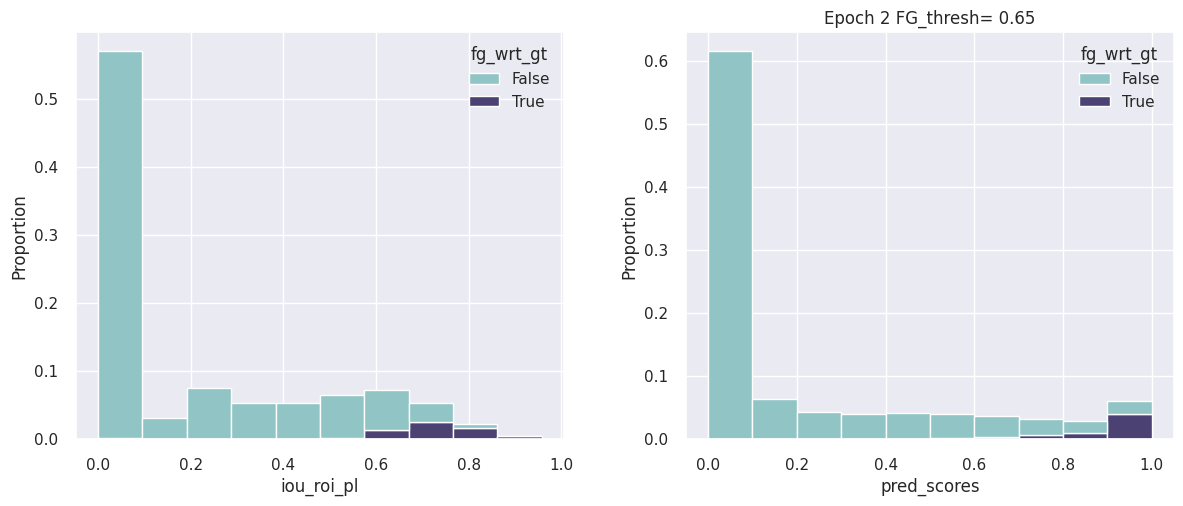

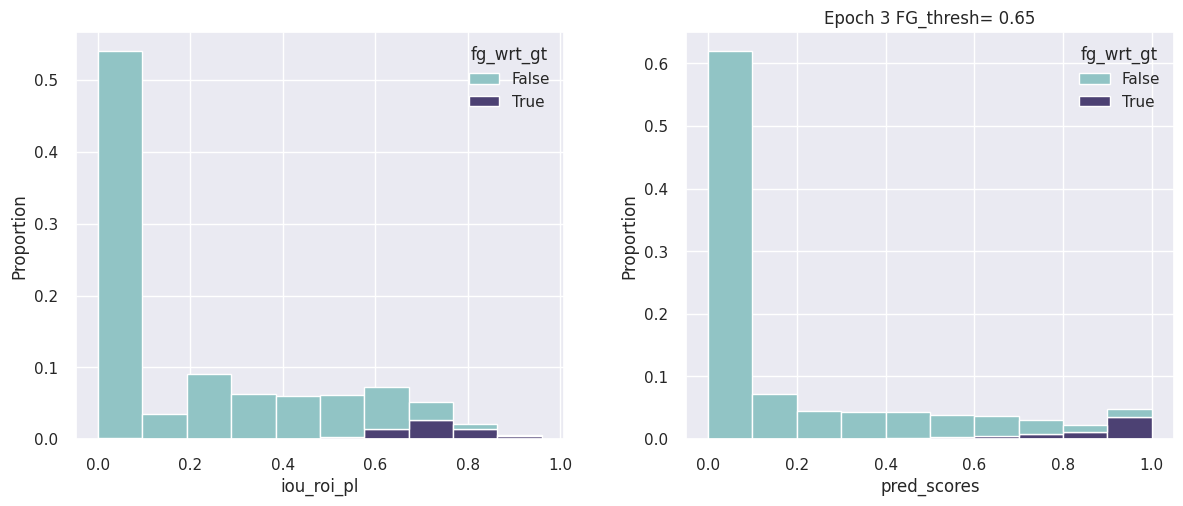

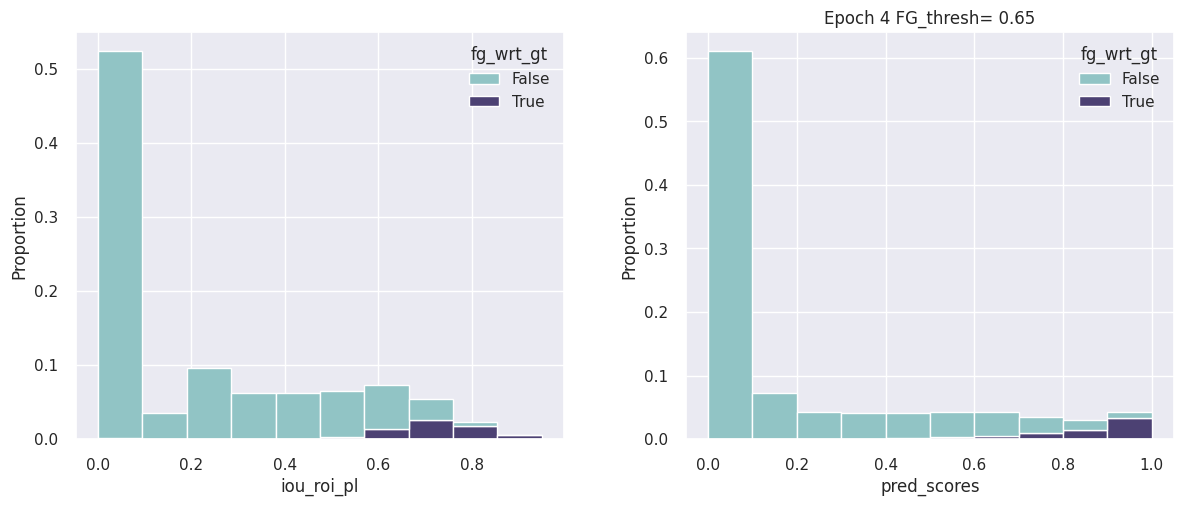

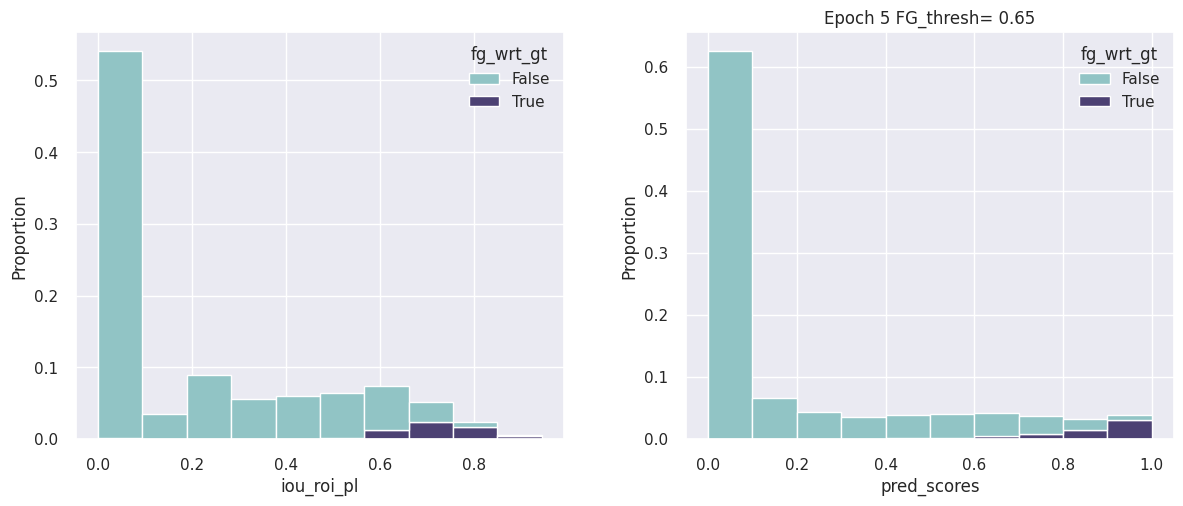

In [29]:
plot_corres_gt(grouped_df,start=40,end=45)

In [105]:
threshold = 0.75
scores = {
    'iou_roi_gt': iou3d_old_thresh['iou_roi_gt'],
    'iou_roi_pl': iou3d_old_thresh['iou_roi_pl'],
    'iteration' : iou3d_old_thresh['iteration'],
    'class_labels': iou3d_old_thresh['class_labels'],
    'pred_scores': iou3d_old_thresh['pred_scores'],
    'threshold': threshold,
    'roi_scores': iou3d_old_thresh['roi_scores']
}
iou3d_ot_df = pd.DataFrame(scores)

In [106]:
iou3d_ot_df.head()

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  threshold  \
0    0.594777    0.697189        0.0             1     0.924146       0.75   
1    0.686190    0.640282        0.0             1     0.880578       0.75   
2    0.000000    0.721479        0.0             1     0.771008       0.75   
3    0.000000    0.742094        0.0             2     0.814994       0.75   
4    0.000000    0.570624        0.0             1     0.601770       0.75   

   roi_scores  
0    0.036497  
1    0.043485  
2    0.829503  
3    0.491779  
4    0.057287

In [107]:
iou3d_ot_df['threshold'] = threshold
iou3d_ot_df['epoch'] = (iou3d_ot_df['iteration']) // 24 + 1
iou3d_ot_df['correct'] = (iou3d_ot_df['iou_roi_pl'] >= threshold) & (iou3d_ot_df['iou_roi_gt'] >= threshold)
iou3d_ot_df['fg_wrt_gt'] = (iou3d_ot_df['iou_roi_gt'] >= threshold)
grouped_ot_df = iou3d_ot_df.groupby('epoch')

# Plot of correspondance of 3dIOUMatch with default thresholds as in Paper

#### Epochs 1 - 5

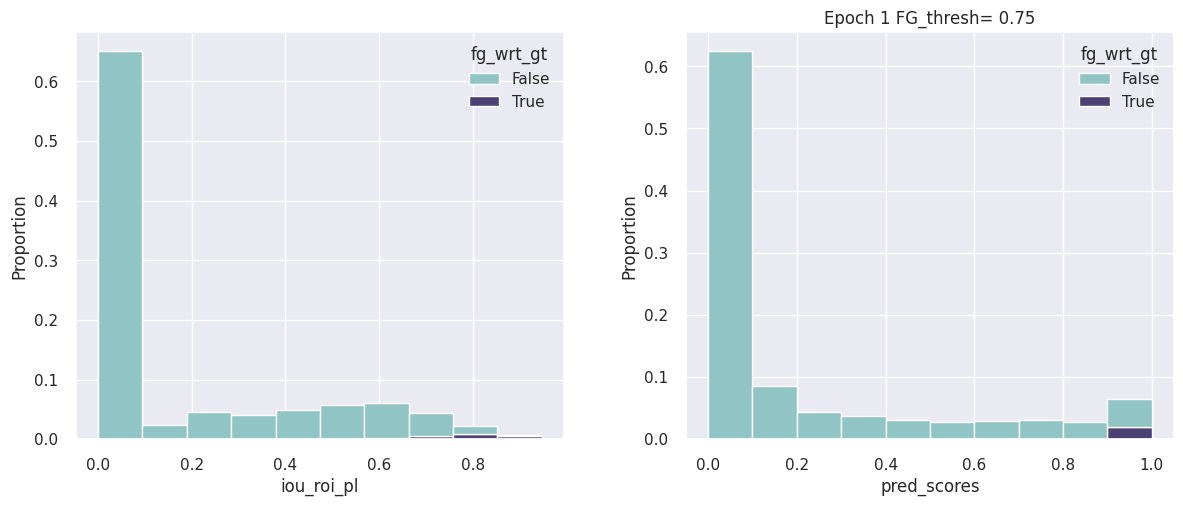

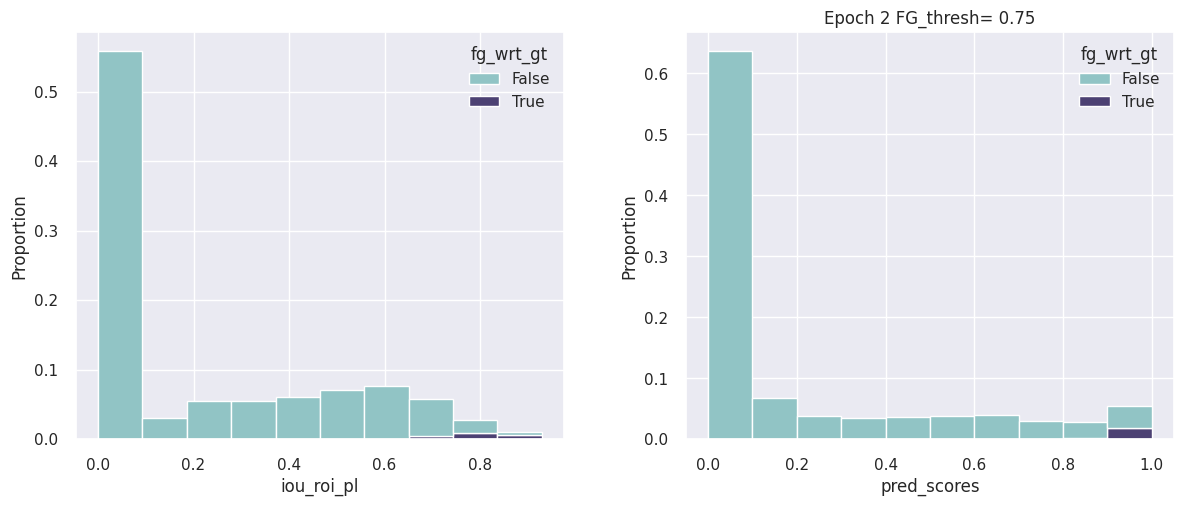

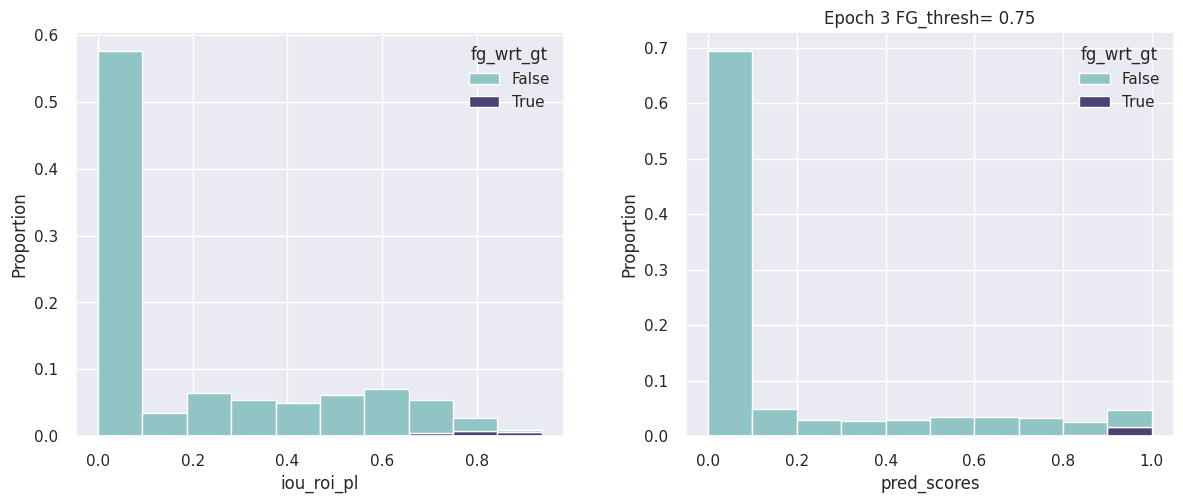

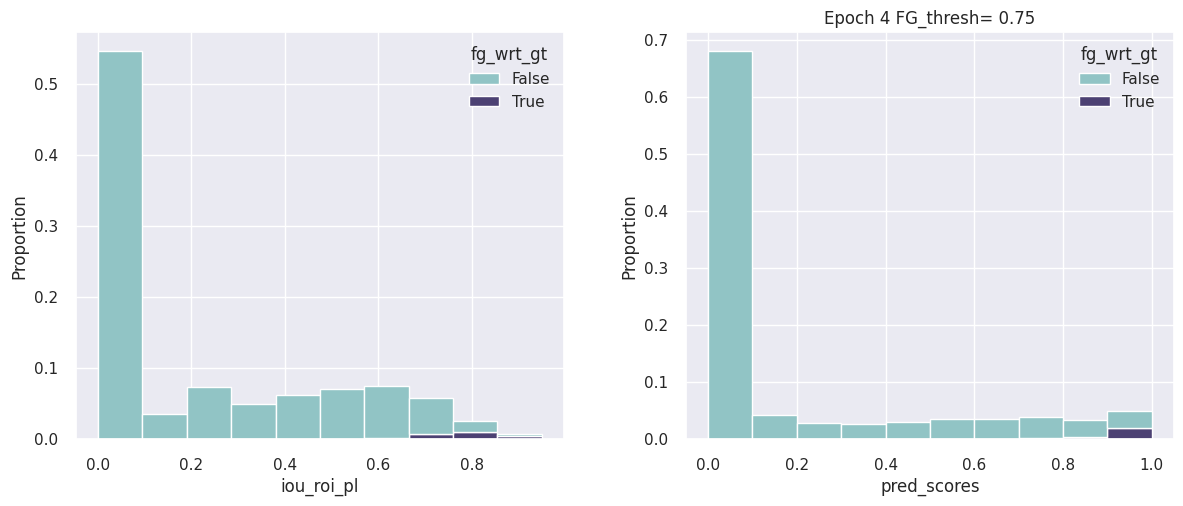

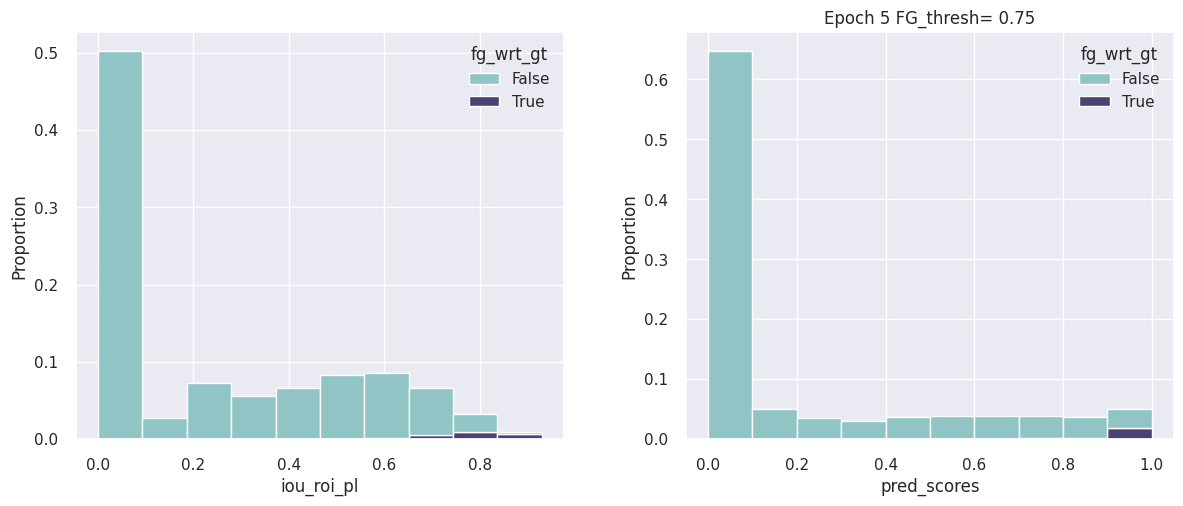

In [108]:
plot_corres_gt(grouped_ot_df,start=1,end=5)

#### Epoch 45-50

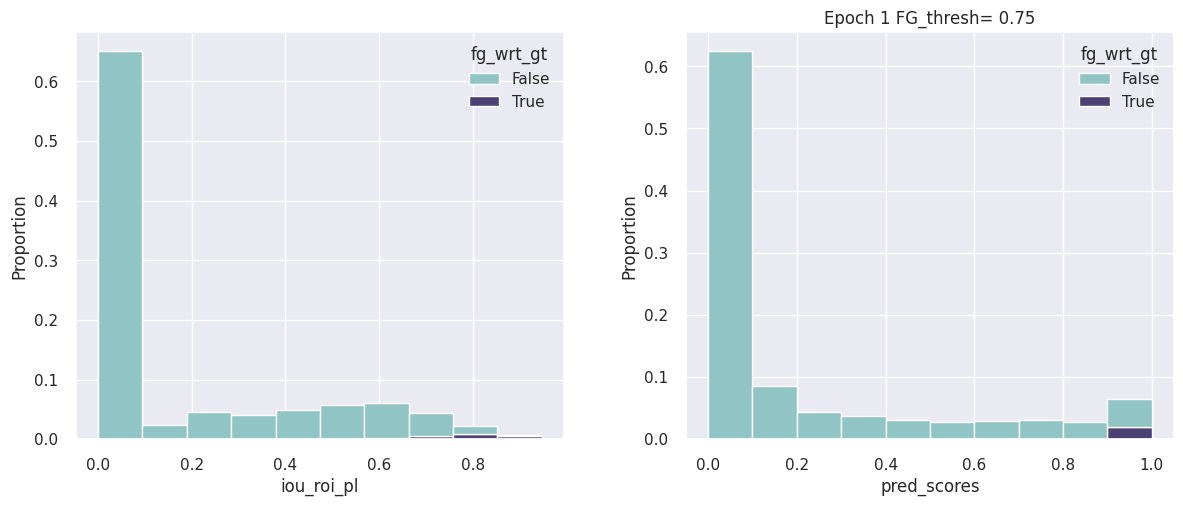

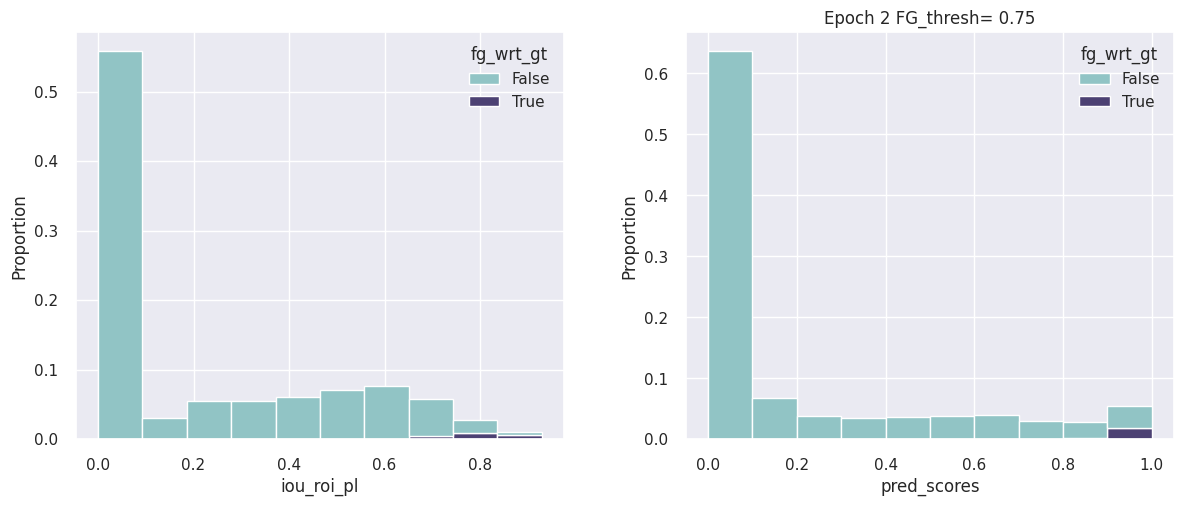

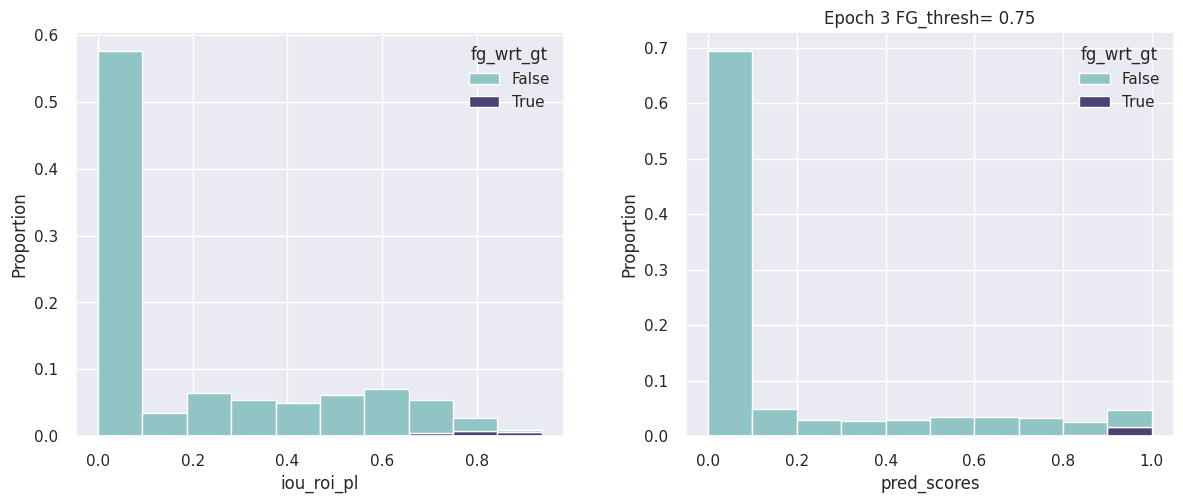

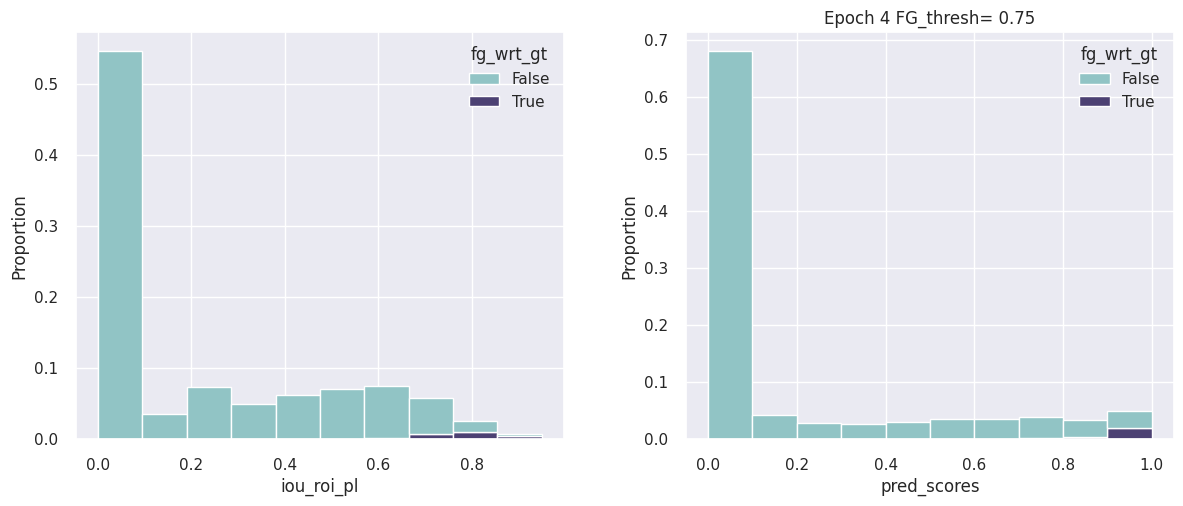

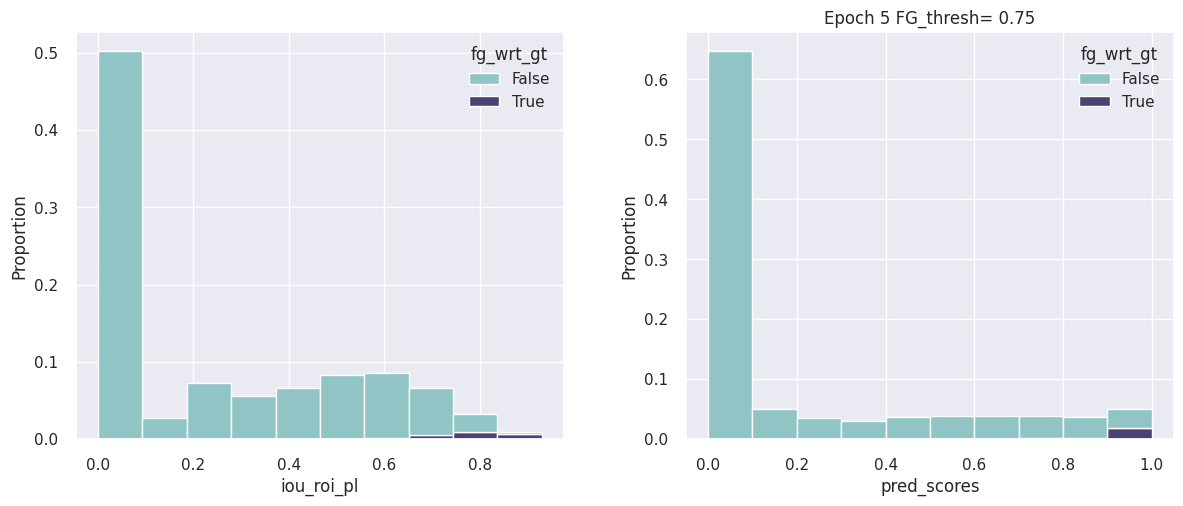

In [109]:
plot_corres_gt(grouped_ot_df,45,50)

#### Zoomed in Visualization

In [110]:
# to visualize in terms of iou
iou3d_ot_iou_df = iou3d_ot_df[iou3d_ot_df['iou_roi_pl']>= 0.25]
grouped_ot_iou_df = iou3d_ot_iou_df.groupby('epoch')
# only sees the pred values above 0.25 for better visualization
iou3d_ot_df['pred_bins'] = iou3d_ot_iou_df['pred_scores'].apply(lambda x: round(x,1))
iou3d_ot_pred_df = iou3d_ot_df[iou3d_ot_df['pred_scores']>= 0.25]
grouped_ot_pred_df = iou3d_ot_pred_df.groupby('epoch')

In [111]:
iou3d_ot_pred_car_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 1)]
iou3d_ot_pred_ped_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 2)]
iou3d_ot_pred_cyc_df = iou3d_ot_df[(iou3d_ot_df['pred_scores']>= 0.25) & (iou3d_ot_df['class_labels'] == 3)]
grouped_ot_pred_car_df = iou3d_ot_pred_car_df.groupby('epoch')
grouped_ot_pred_ped_df = iou3d_ot_pred_ped_df.groupby('epoch')
grouped_ot_pred_cyc_df = iou3d_ot_pred_cyc_df.groupby('epoch')

In [112]:
df = grouped_ot_pred_car_df.get_group(1)
values = {
    'range': [],
    'prob': [],
    'tp': []
}
x = np.linspace(0.25,0.975,29)
interval = (x[1]-x[0])
for i,val in enumerate(x):
    iter_df = df[(df['pred_scores'] >= val) & (df['pred_scores'] < (val+interval)) & (df['class_labels']==1)]
    values['prob'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0])
    values['range'].append(val)
    values['tp'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0])
    

## Probability that a sample is a TP

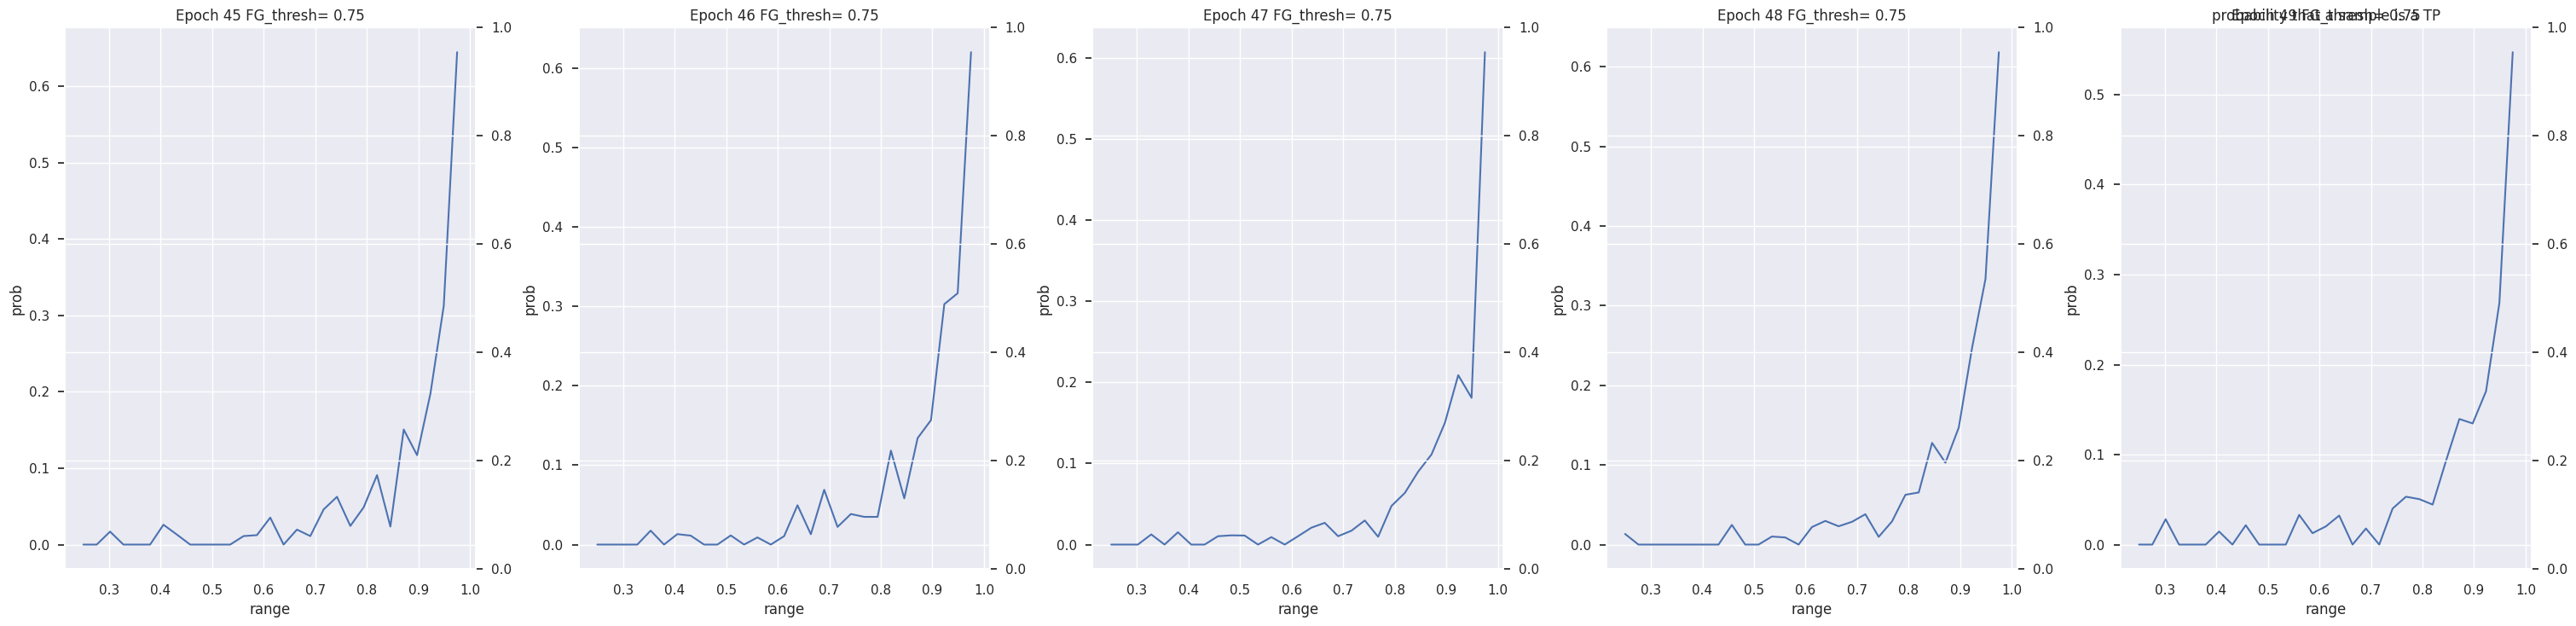

In [113]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch_prob(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='darkgrid')
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for iter in range(start,end):
        df = grouped_df.get_group(iter)
        values = {
        'range': [],
        'prob': [],
    }
        x = np.linspace(0.25,0.975,29)
        interval = (x[1]-x[0])
        for i,val in enumerate(x):
            iter_df = df[(df['pred_scores'] >= val) & (df['pred_scores'] < (val+interval)) & (df['class_labels']==1)]
            values['prob'].append(iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0])
            values['range'].append(val)
        filter_df = pd.DataFrame(values)
        sns.lineplot(ax=axes[iter-start],data=filter_df,x='range',y='prob',markers=True,palette=palette,alpha=1.0)
        axes[iter-start].set_title(f'Epoch {iter} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[iter-start].twinx()
        ax2.set_ylim(0, 1)
    plt.title("probability that a sample is a TP")
    plt.show()
plot_epoch_prob(grouped_ot_pred_car_df,45,50)

In [114]:
prob_df = pd.DataFrame(values)
prob_df

range      prob   tp
0   0.250000  0.000000    0
1   0.275893  0.000000    0
2   0.301786  0.000000    0
3   0.327679  0.000000    0
4   0.353571  0.000000    0
5   0.379464  0.000000    0
6   0.405357  0.000000    0
7   0.431250  0.000000    0
8   0.457143  0.000000    0
9   0.483036  0.000000    0
10  0.508929  0.000000    0
11  0.534821  0.000000    0
12  0.560714  0.000000    0
13  0.586607  0.000000    0
14  0.612500  0.000000    0
15  0.638393  0.000000    0
16  0.664286  0.013333    1
17  0.690179  0.012048    1
18  0.716071  0.012658    1
19  0.741964  0.017241    1
20  0.767857  0.000000    0
21  0.793750  0.000000    0
22  0.819643  0.040541    3
23  0.845536  0.053571    3
24  0.871429  0.014085    1
25  0.897321  0.090909    7
26  0.923214  0.089888    8
27  0.949107  0.170213   16
28  0.975000  0.479319  197

In [115]:
from matplotlib.backends.backend_pdf import PdfPages
start = 1
end = 6
p =sns.cubehelix_palette(start=.5, rot=-.5)
palette = [p[1],p[4]]
sns.set_theme(style='dark')
for i in range(0,3):
 with PdfPages('plots.pdf') as pdf:
    for i in range(start,end):
        f, axes = plt.subplots(1,2, figsize=(15,5))
        sns.histplot(ax=axes[0],data=grouped_ot_iou_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[1],data=grouped_ot_pred_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)

        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        plt.title(f'Epoch {i} FG_thresh= {threshold}')
        # Iterate over the subplots in axes
        ax2_1 = axes[0].twinx()
        ax2_2 = axes[1].twinx()

        # Set the y-axis limits to 0 and 1 for each twin axes
        ax2_1.set_ylim(0, 1)
        ax2_2.set_ylim(0, 1)

        # Remove the spines and ticks of the left y-axis for each subplot
        ax2_1.spines['left'].set_visible(False)
        ax2_1.yaxis.set_ticks_position('none')
        ax2_2.spines['left'].set_visible(False)
        ax2_2.yaxis.set_ticks_position('none')

        # Remove the spines and ticks of the right y-axis for each subplot
        ax2_1.spines['right'].set_linewidth(0.5)
        ax2_1.spines['right'].set_color('black')
        ax2_1.spines['right'].set_visible(True)
        ax2_1.yaxis.tick_right()
        ax2_1.yaxis.set_label_position('right')

        ax2_2.spines['right'].set_linewidth(0.5)
        ax2_2.spines['right'].set_color('black')
        ax2_2.spines['right'].set_visible(True)
        ax2_2.yaxis.tick_right()
        ax2_2.yaxis.set_label_position('right')
        pdf.savefig(f)
        plt.close(f)
    # Set the label for the right y-axis
f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
plt.show()


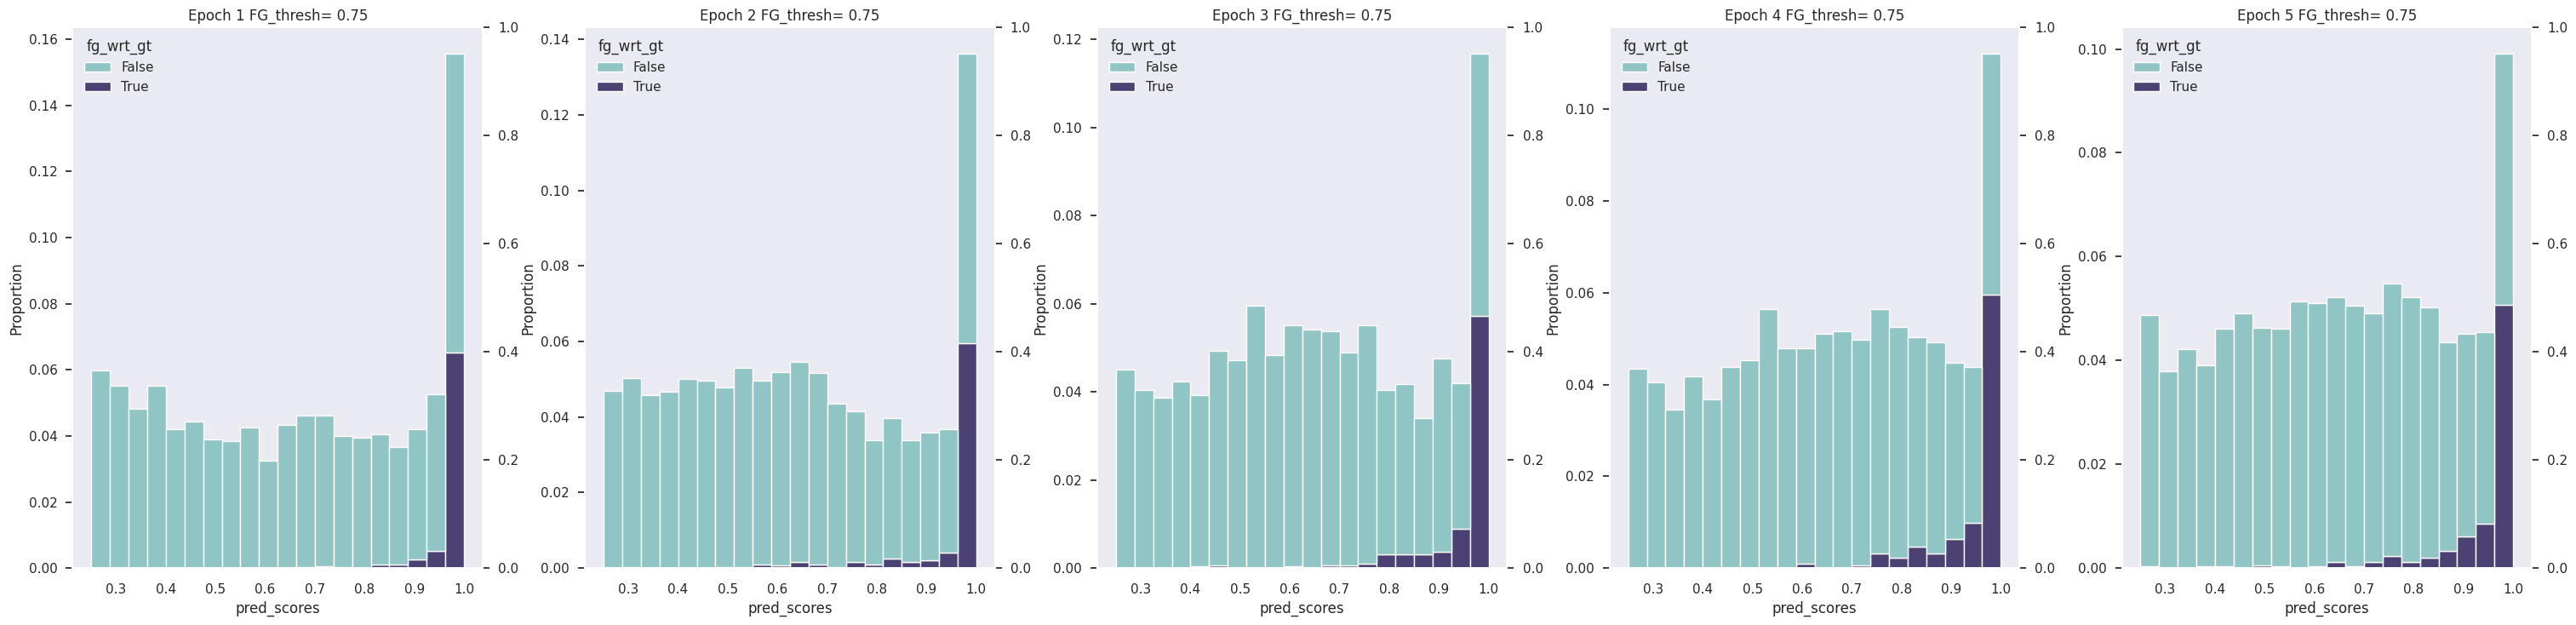

In [117]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    grouped_ot_pred_df = iou3d_ot_pred_df.groupby('epoch')
    # for i in range(0,3):
    # with PdfPages('plots.pdf') as pdf:
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(grouped_ot_pred_df,1,6)


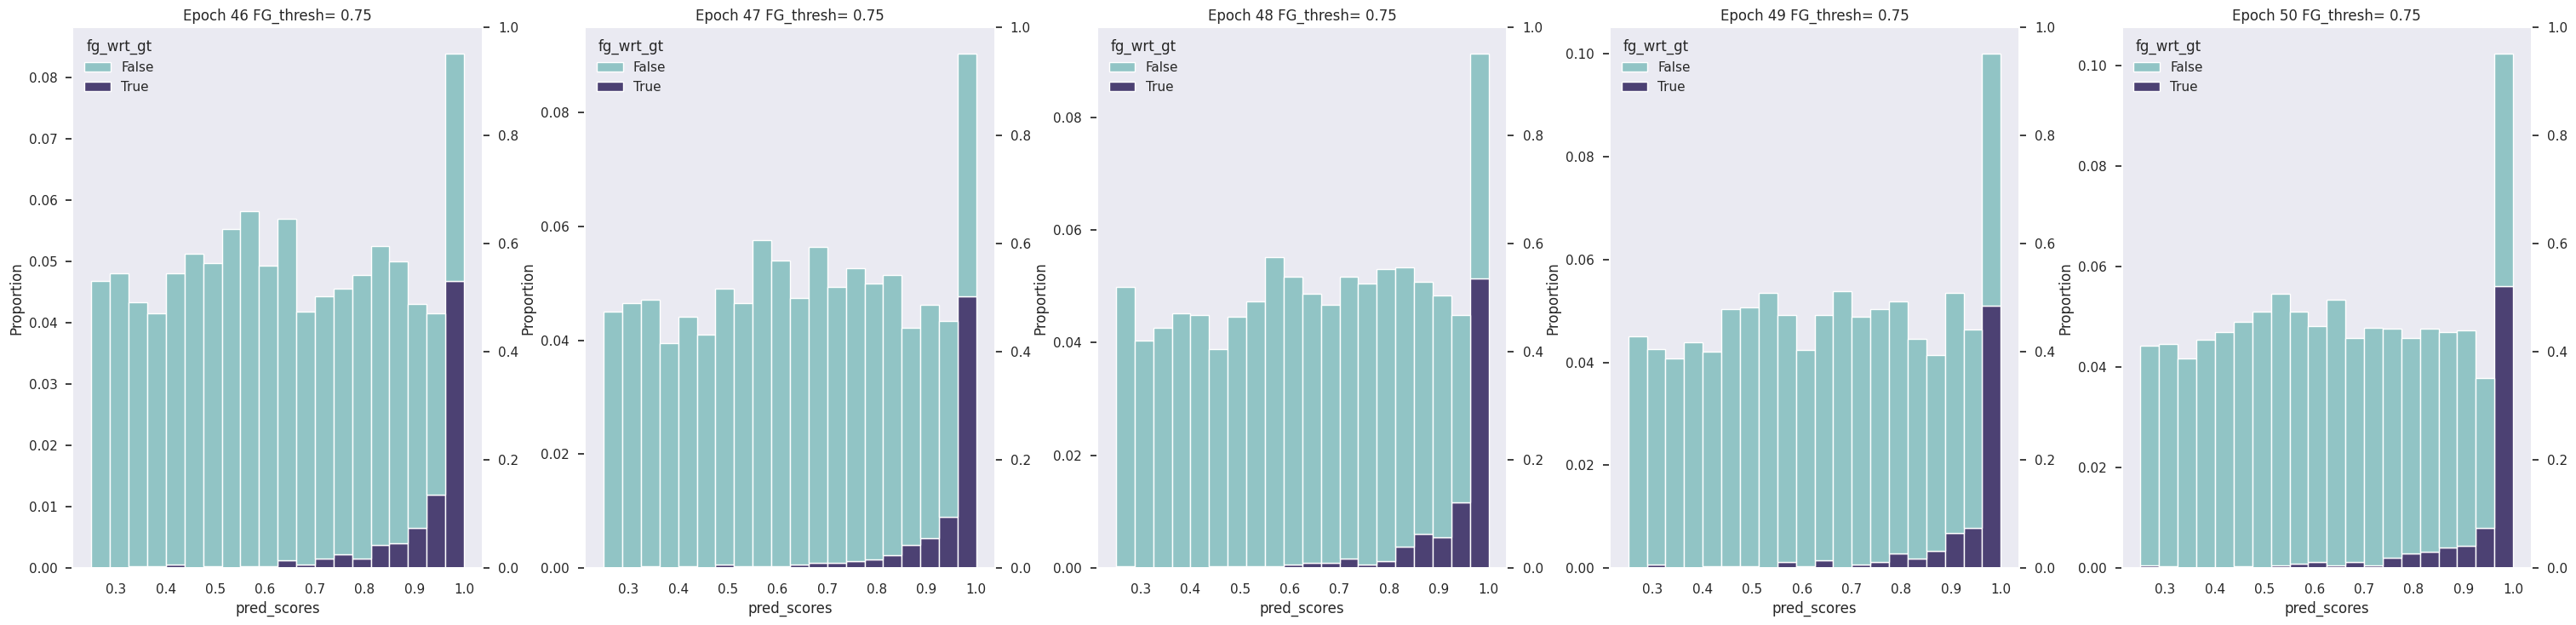

In [119]:
plot_epoch(grouped_ot_pred_df,46,51)

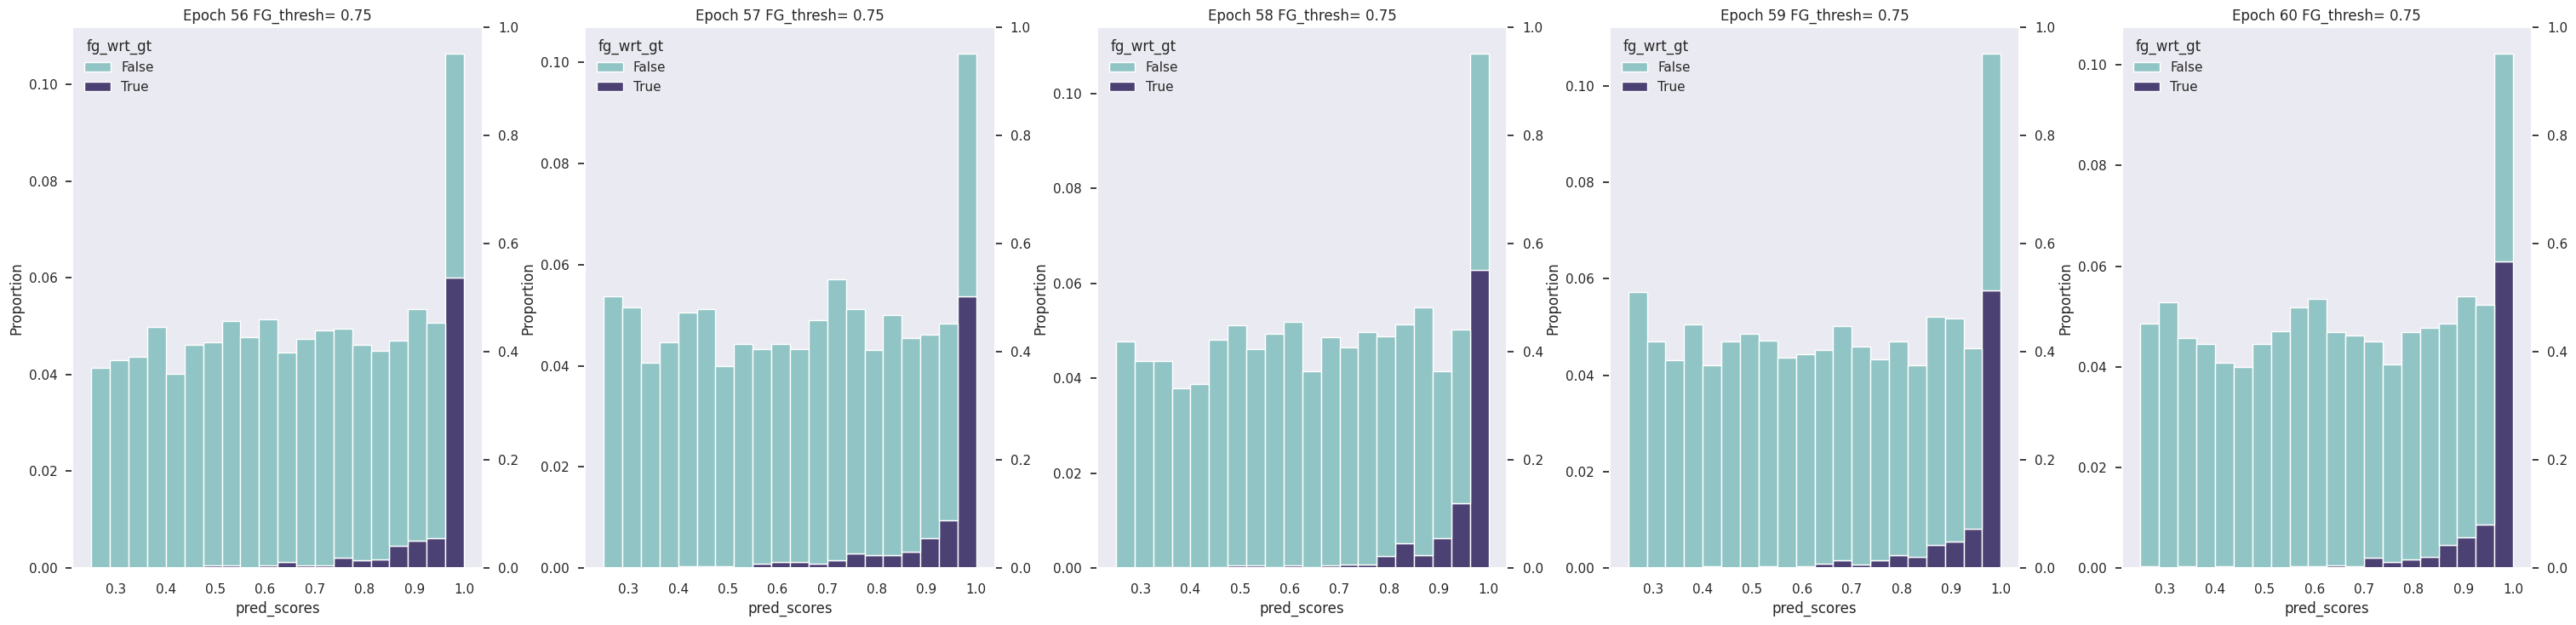

In [120]:
plot_epoch(grouped_ot_pred_df,56,61)

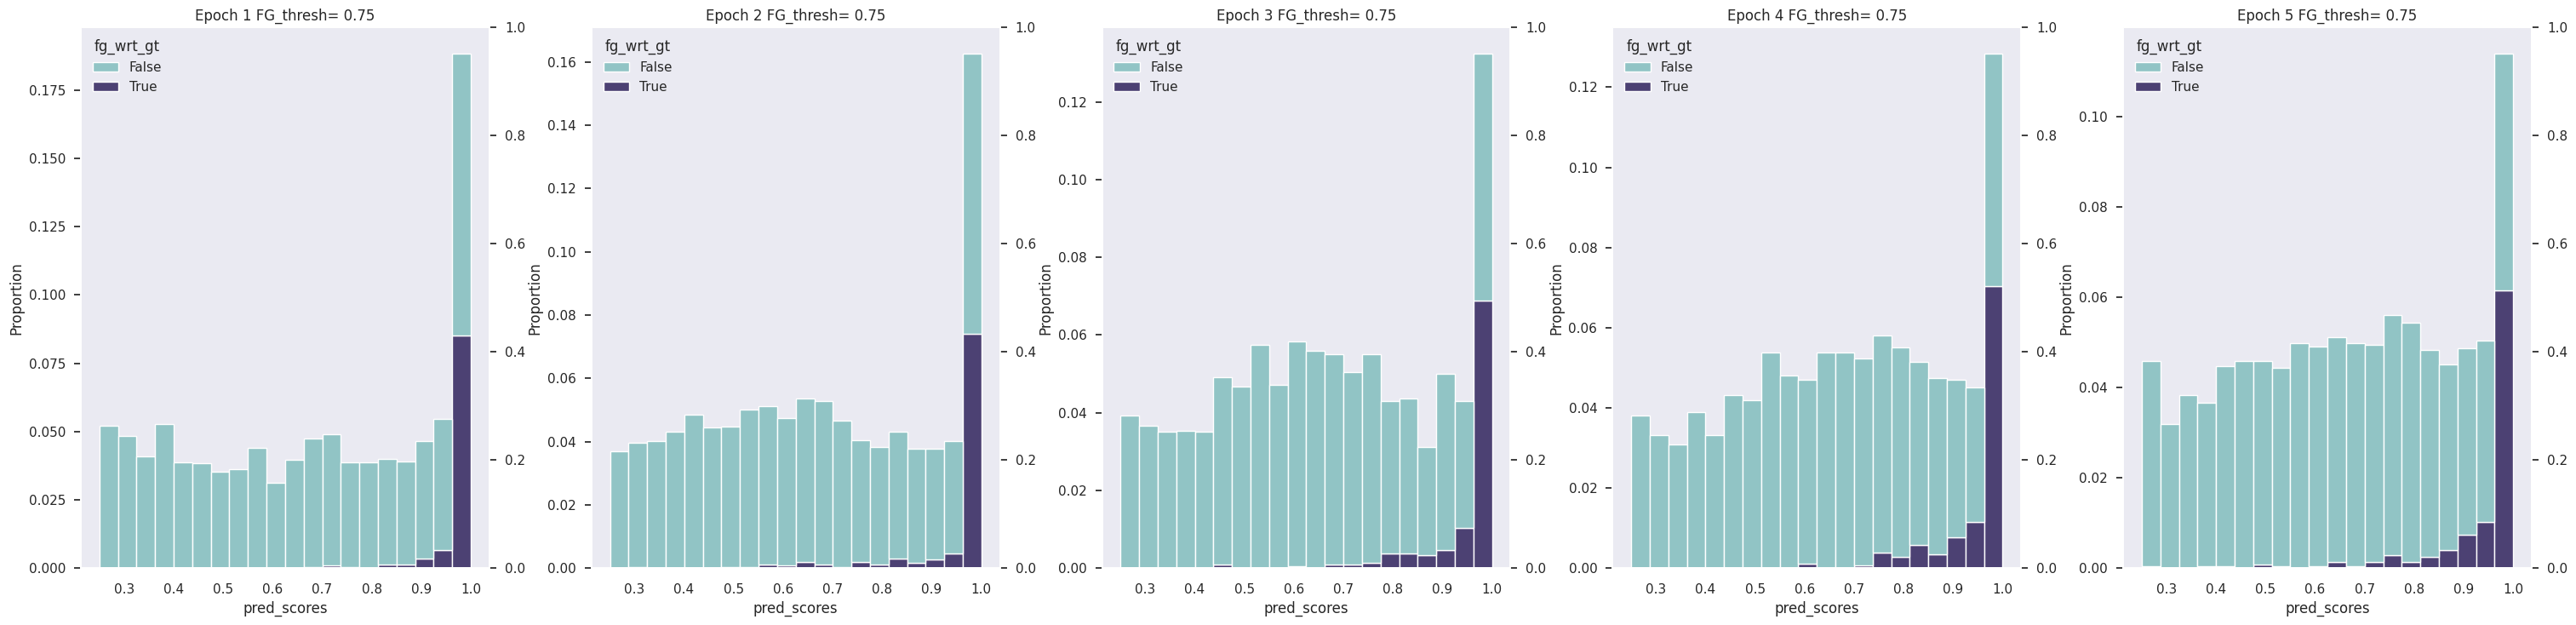

In [121]:
plot_epoch(grouped_ot_pred_car_df,1,6)

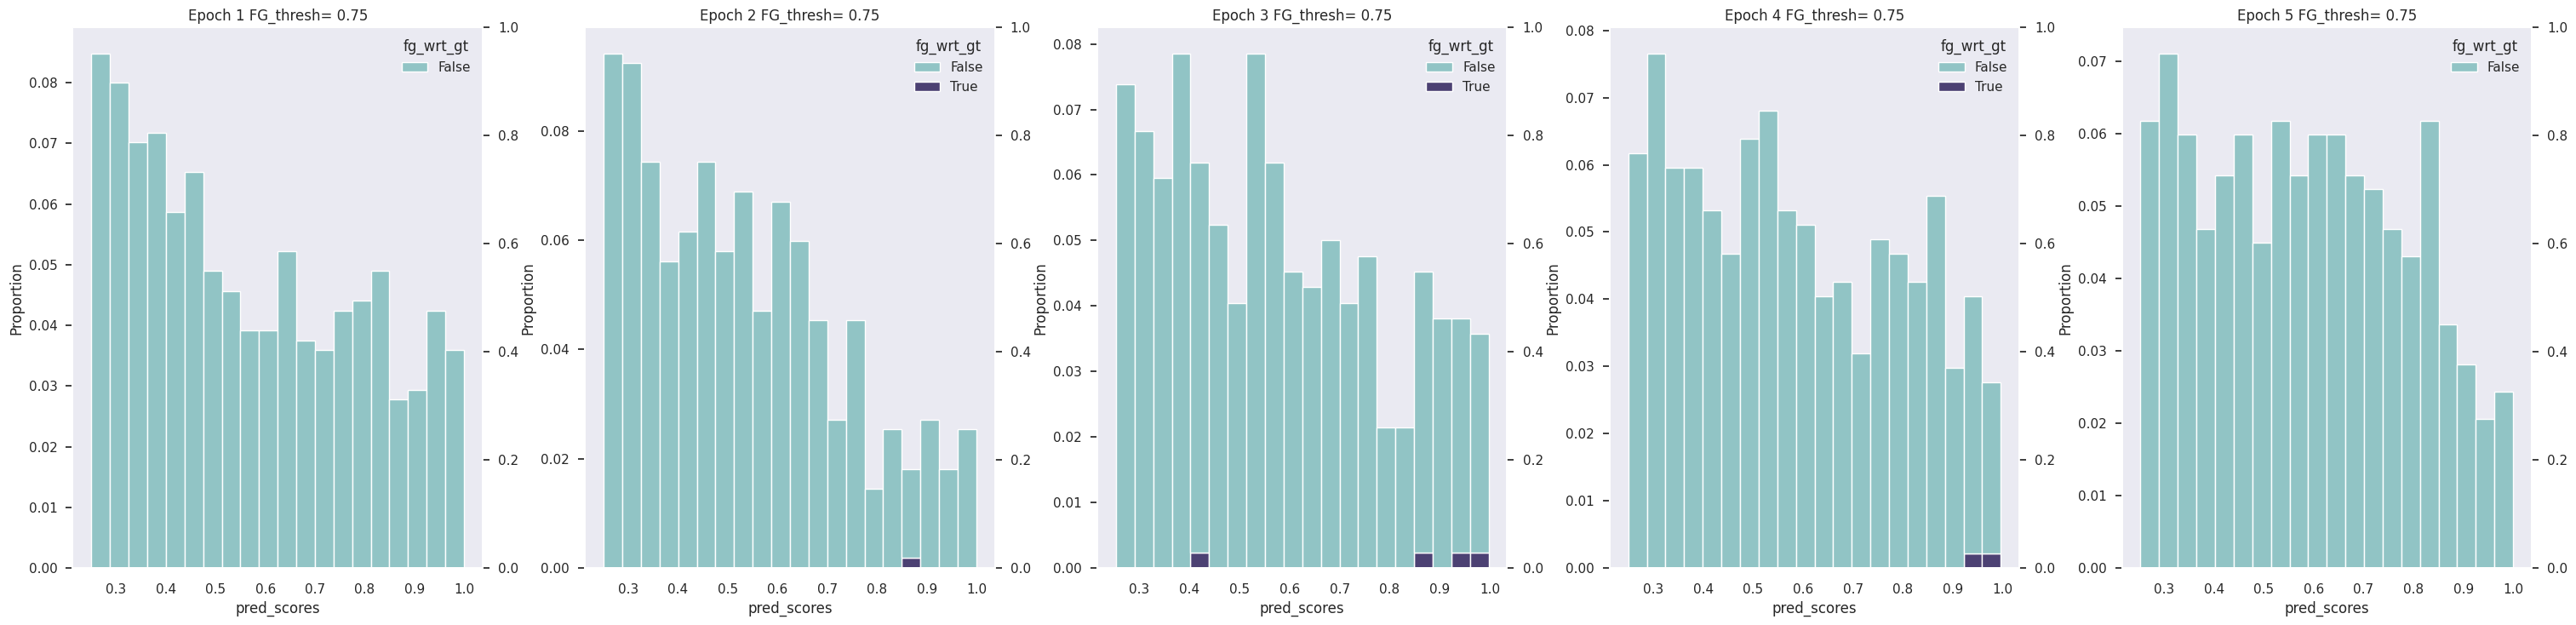

In [122]:
plot_epoch(grouped_ot_pred_ped_df,1,6)

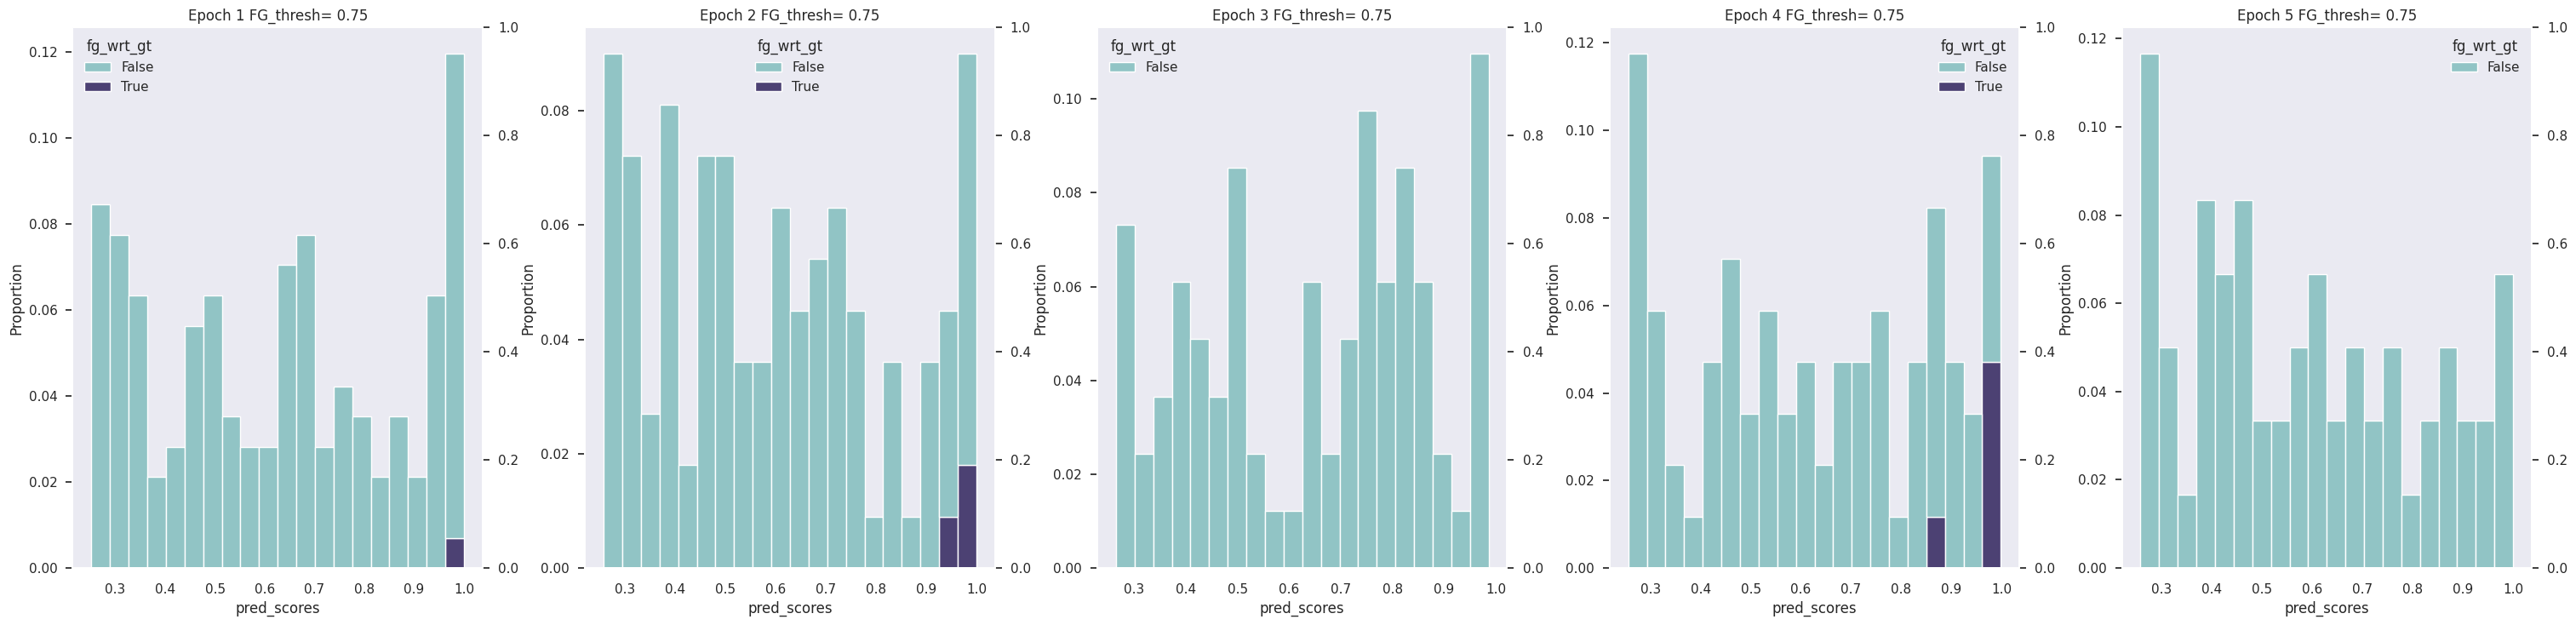

In [123]:
plot_epoch(grouped_ot_pred_cyc_df,1,6)

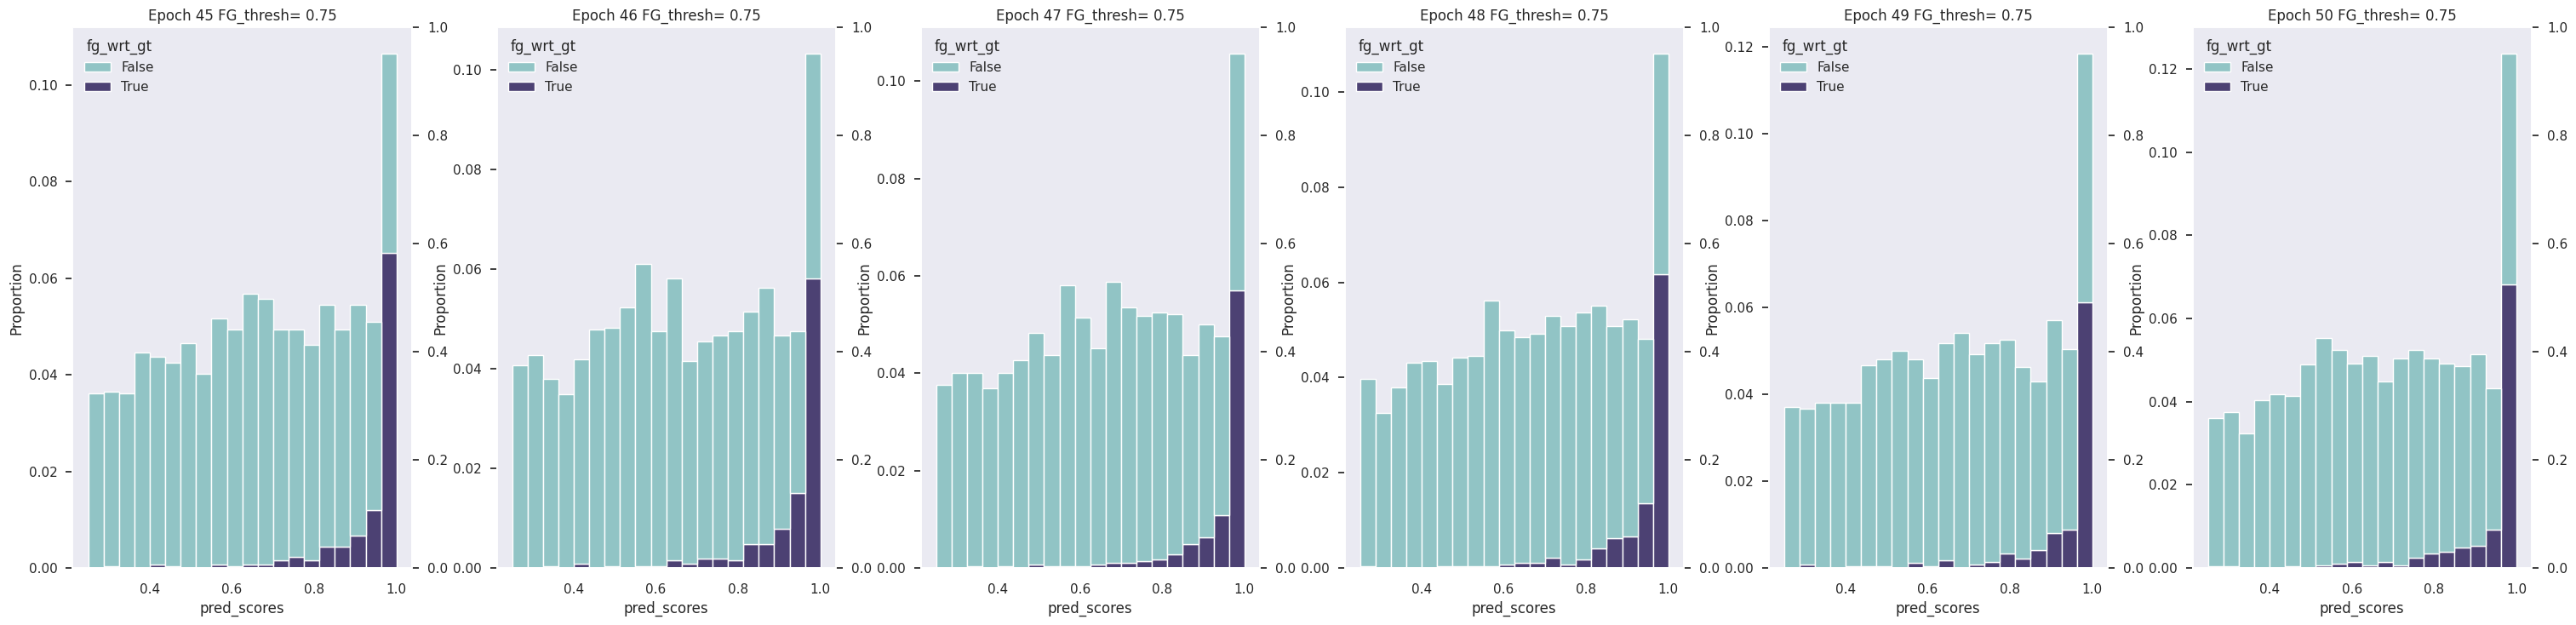

In [124]:
plot_epoch(grouped_ot_pred_car_df,45,51)

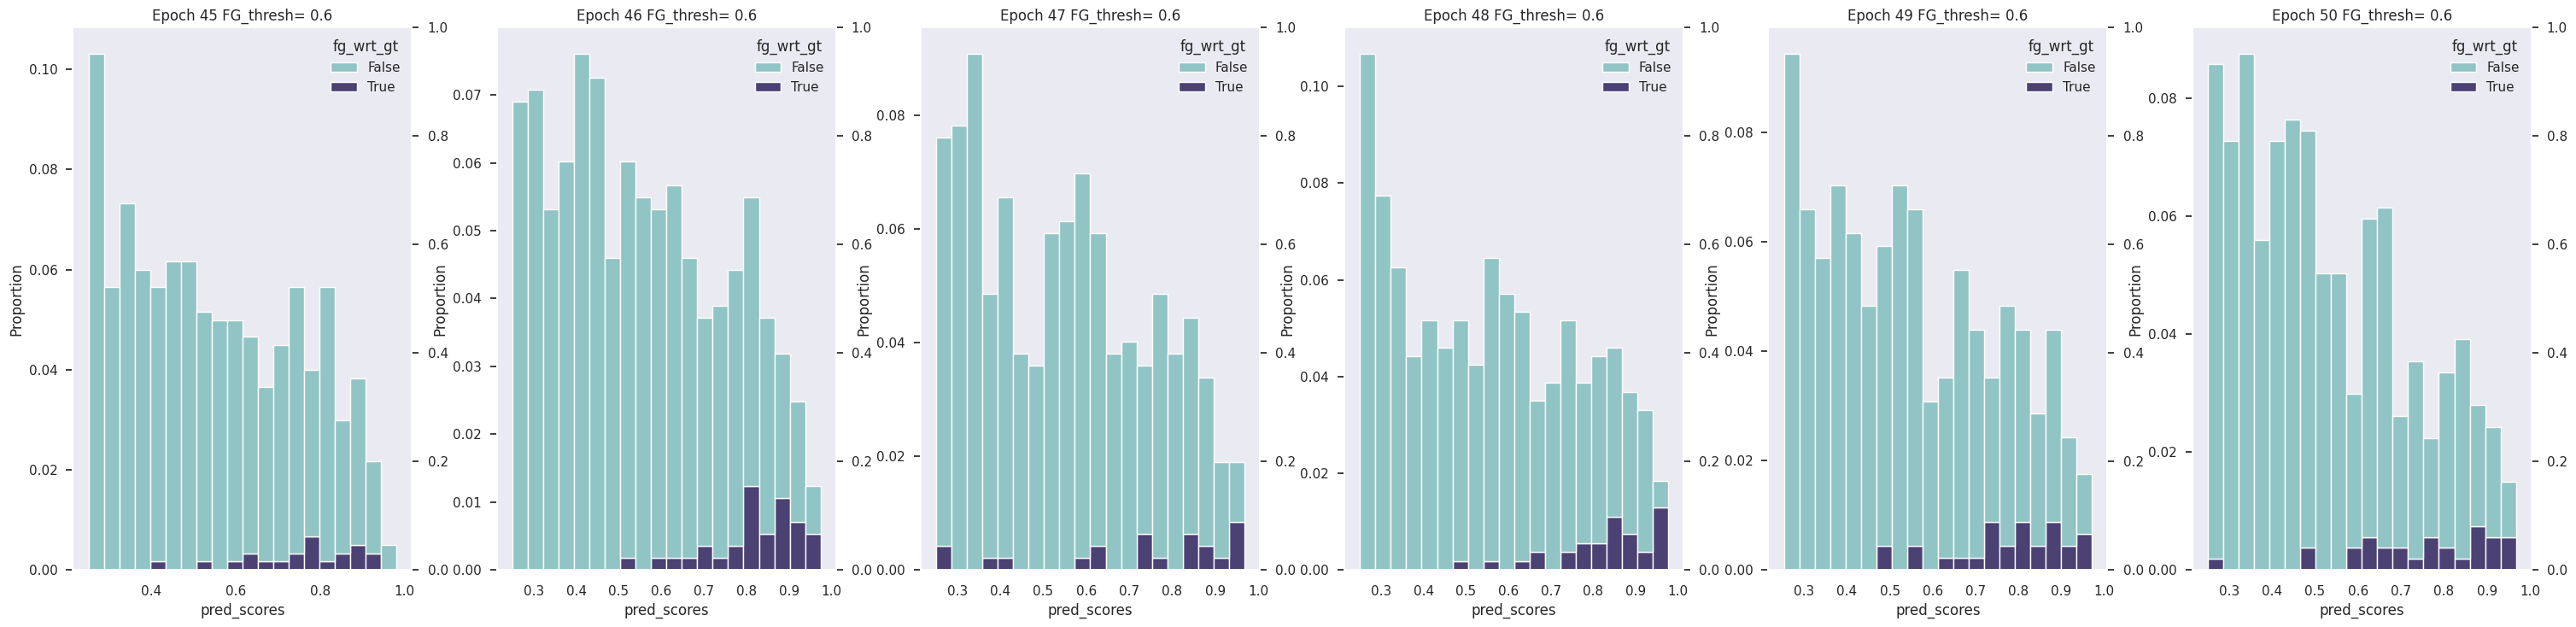

In [50]:
plot_epoch(grouped_ot_pred_ped_df,45,51)

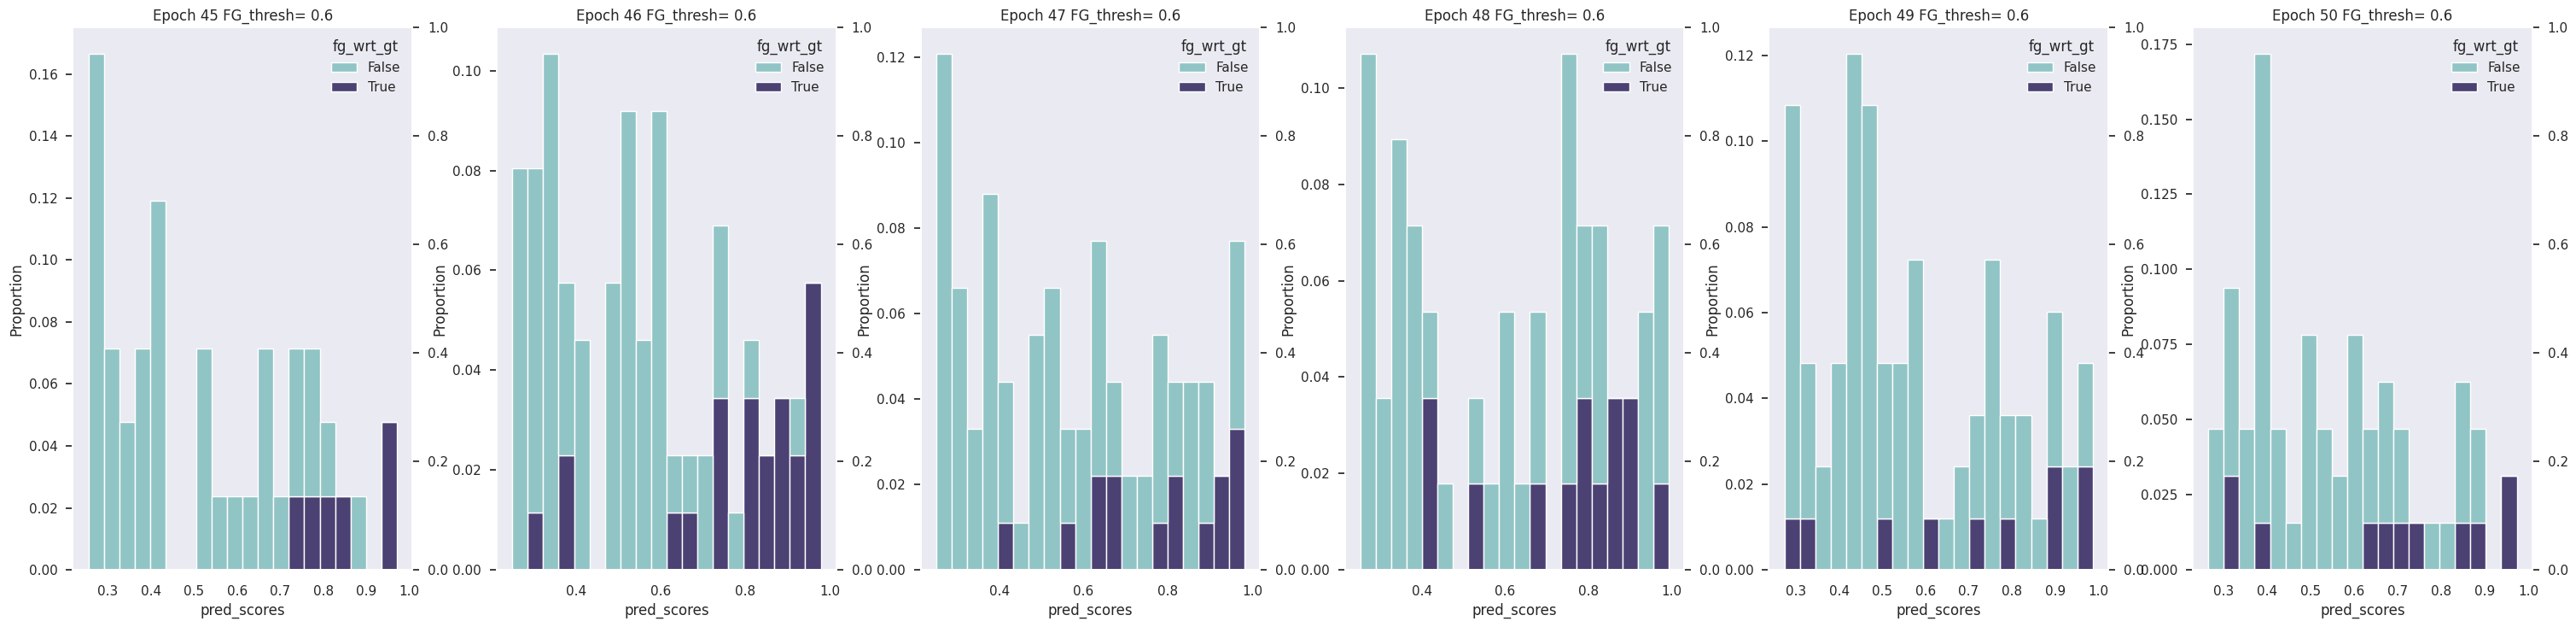

In [51]:
plot_epoch(grouped_ot_pred_cyc_df,45,51)

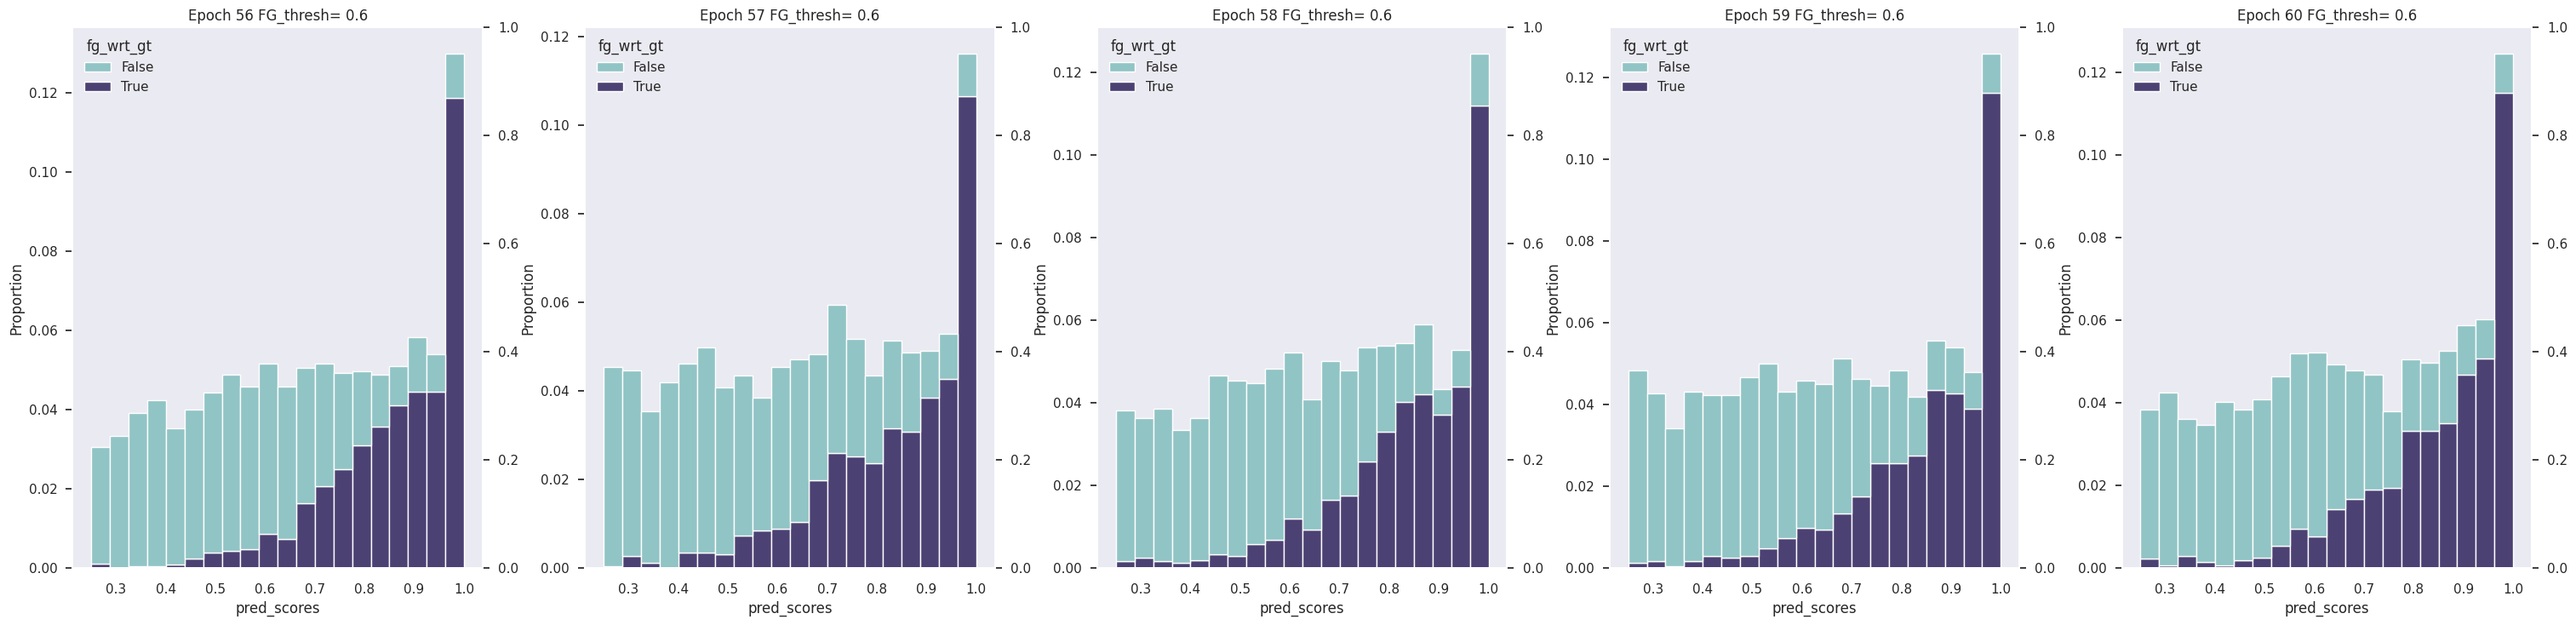

In [52]:
plot_epoch(grouped_ot_pred_car_df,56,61)

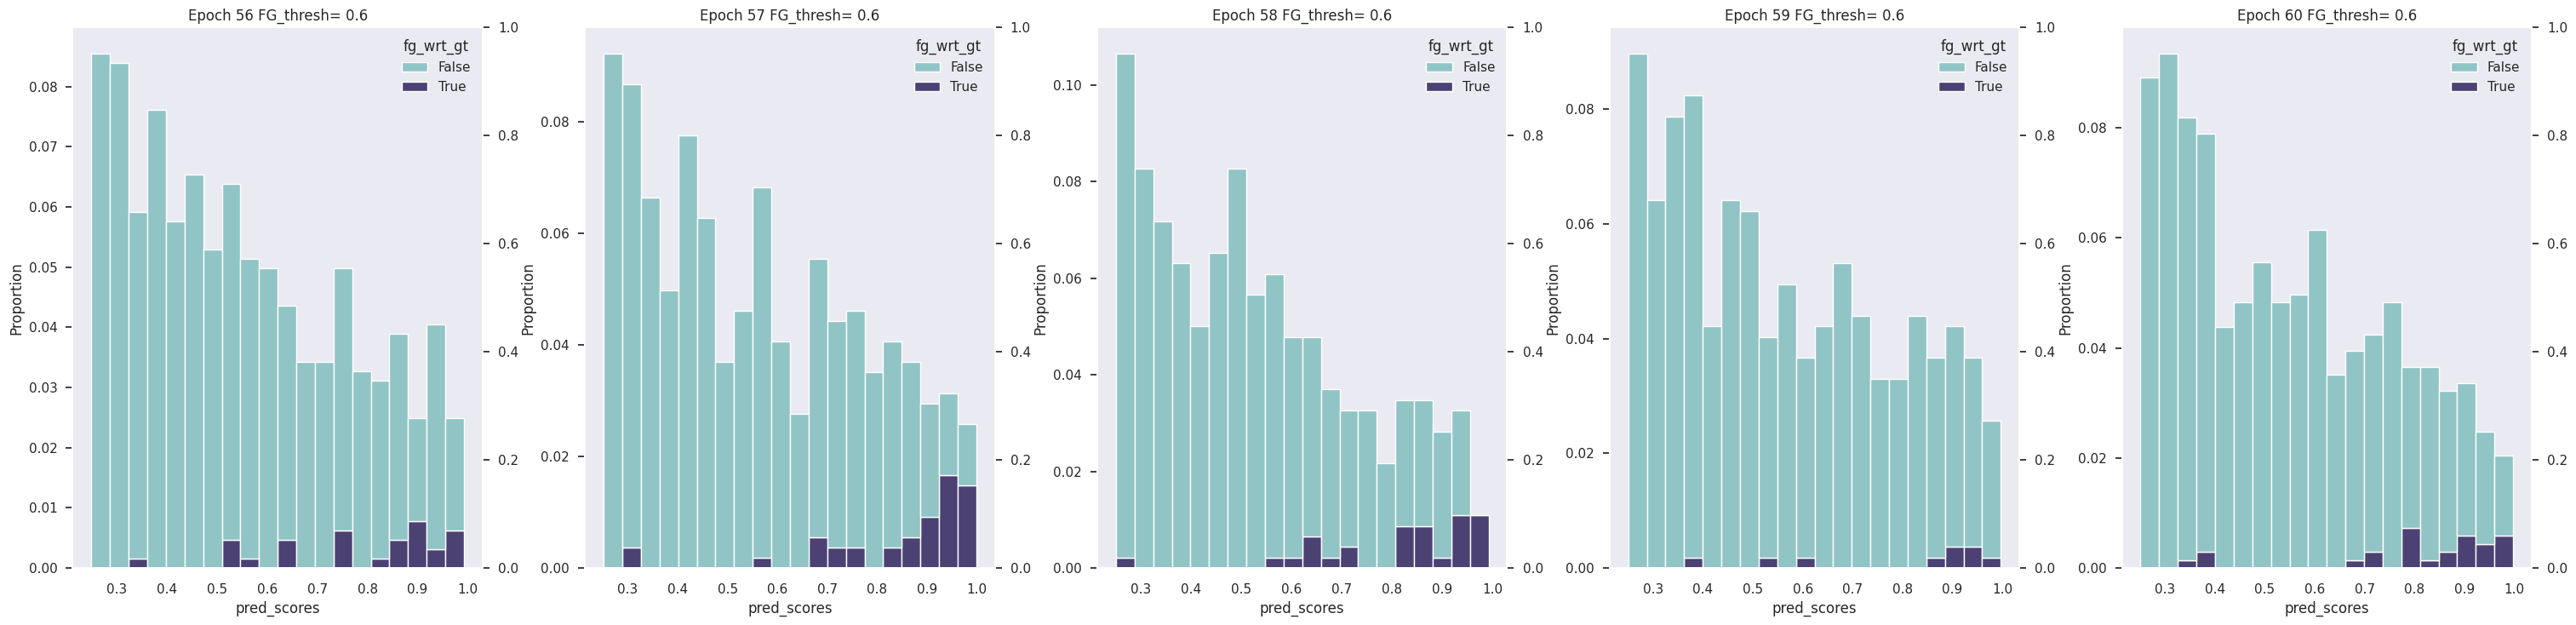

In [53]:
plot_epoch(grouped_ot_pred_ped_df,56,61)

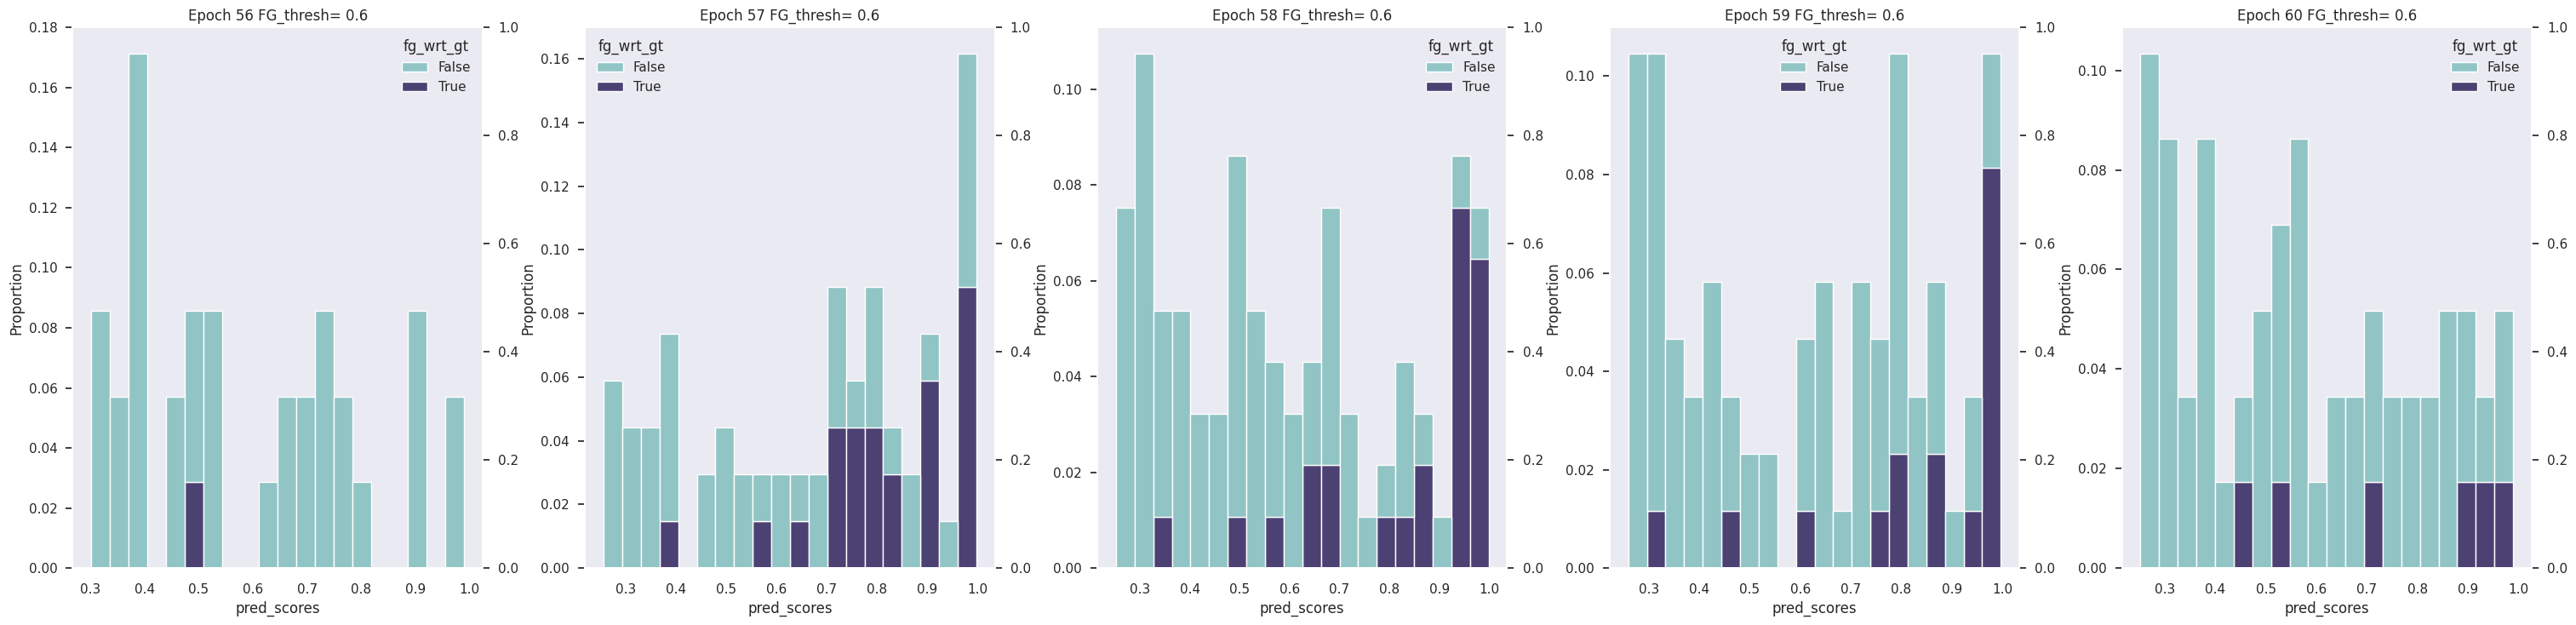

In [54]:
plot_epoch(grouped_ot_pred_cyc_df,56,61)

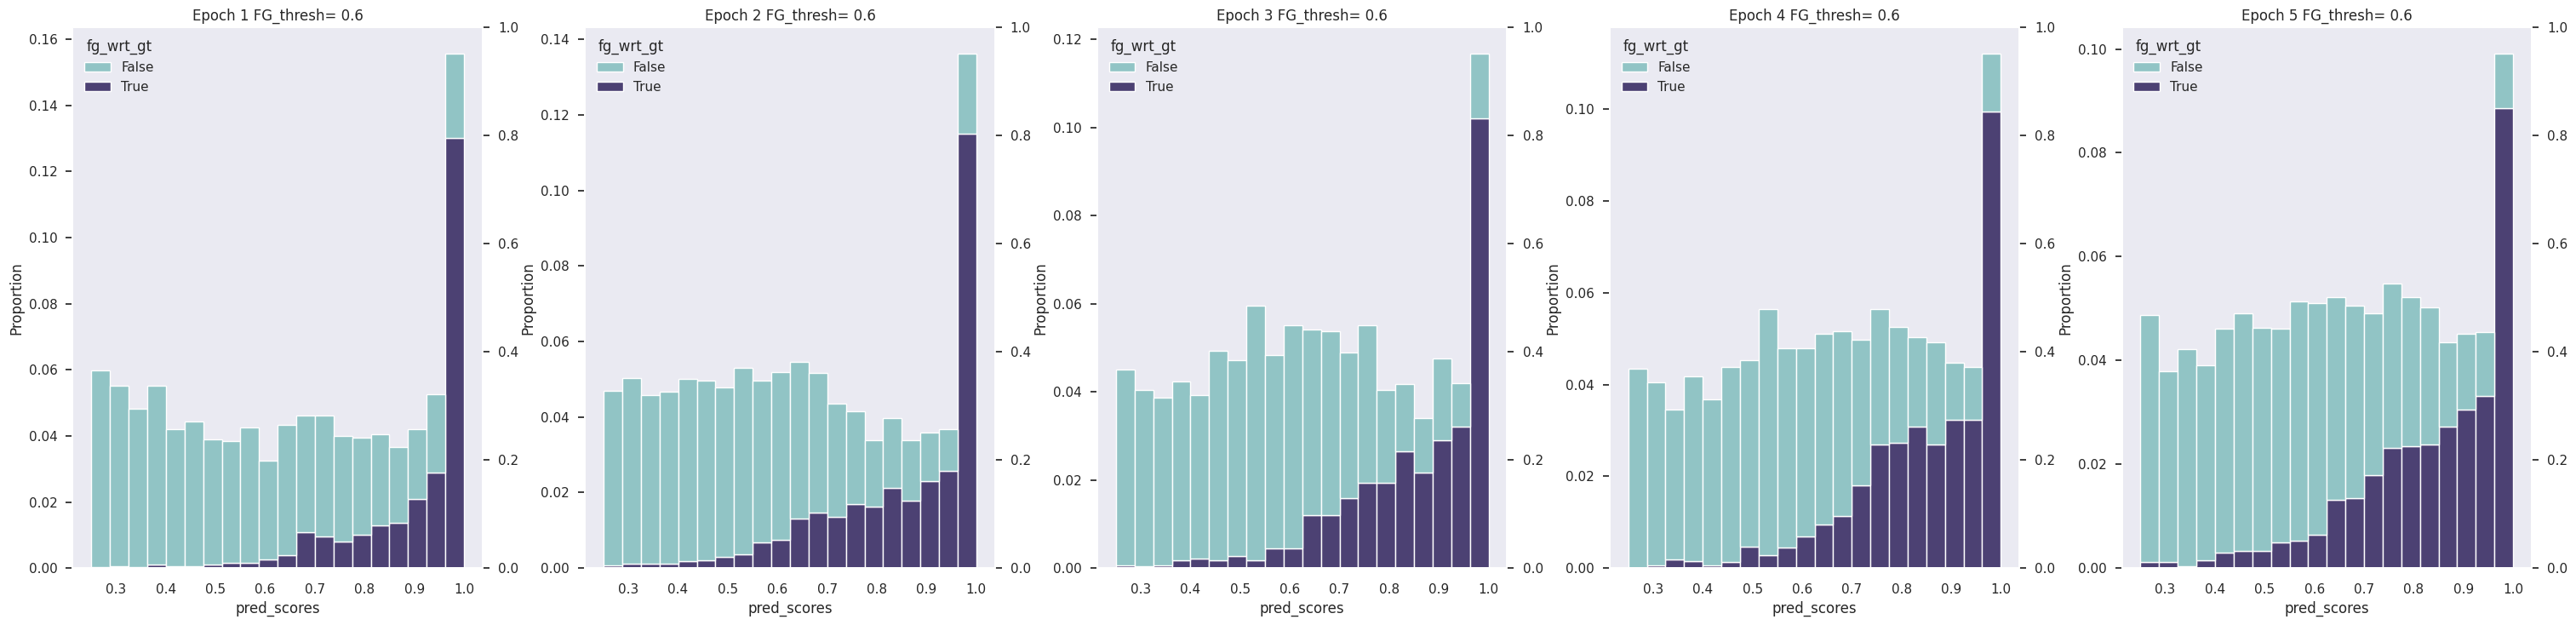

In [55]:

def plot_epoch(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    # for i in range(0,3):
    # with PdfPages('plots.pdf') as pdf:
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):

        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(grouped_ot_pred_df,1,6)

In [3]:
import numpy as np

def gaussian(row):
    x = row['pred_scores']
    # mu = row['mean']
    # sigma =8*row['variance']
    mu = 0.5
    sigma = 0.11
    exponent =  -1*(x - mu)**2 / 2*sigma**2
    scaler = 1/(1-mu)
    return scaler * np.exp(exponent)

def thresholding(row):
    row['gaussian'] = 1 if row['pred_scores'] >= row['threshold'] else row['gaussian']
    return row['gaussian']

In [4]:
def tp_fp_fn_tn(df,title):
    fg_gt_thresh = [0.7, 0.5, 0.5]
    fg_pl_thresh = 0.75
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    palette = {'tp':p[2],'fp':p[0],'fn':p[3], 'tn':p[-2]}
    f, axes = plt.subplots(1,3, figsize=(15,4))
    for i in range(0,3):
        cls_df = df[df['class_labels'] == i + 1]
        tp_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (fg_pl_thresh <= cls_df['iou_roi_pl'])
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (fg_pl_thresh <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh[i] <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < fg_pl_thresh)
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[i]) & (cls_df['iou_roi_pl'] < fg_pl_thresh)
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'

        sns.histplot(ax=axes[i],data=cls_df, x="iou_roi_pl",hue='type',fill=True, kde=False,stat='count',multiple="stack",legend=True, bins=20, alpha=0.8,palette=palette)
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.title(title)
    plt.show()

In [2]:
stats = iou3d_old_thresh
stats_dict = {
 'iou_roi_gt': stats['iou_roi_gt'],
 'iou_roi_pl': stats['iou_roi_pl'],
 'iteration' : stats['iteration'],
 'class_labels': stats['class_labels'],
 'pred_scores': stats['pred_scores']
 
}
stats_df = pd.DataFrame(stats_dict)
stats_df['type'] = 'none'
stats_df['epoch'] = (stats_df['iteration']) // 24 + 1
stats_df = stats_df[0.3 <= stats_df['iou_roi_pl']]

NameError: name 'iou3d_old_thresh' is not defined

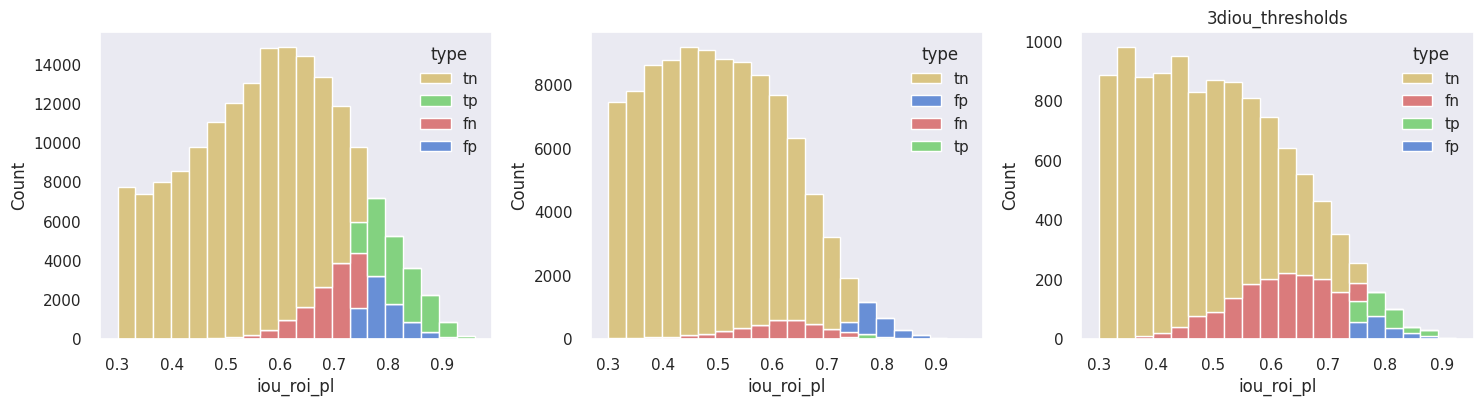

In [138]:
tp_fp_fn_tn(stats_df,'3diou_thresholds')

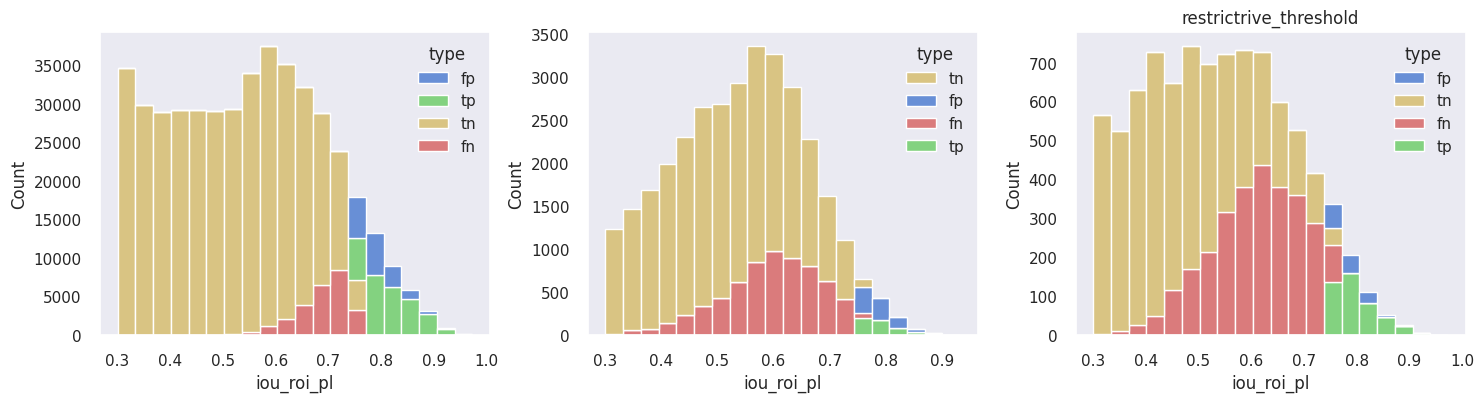

In [136]:
stats = iou3d_df
stats_dict_res = {
 'iou_roi_gt': stats['iou_roi_gt'],
 'iou_roi_pl': stats['iou_roi_pl'],
 'iteration' : stats['iteration'],
 'class_labels': stats['class_labels'],
 'pred_scores': stats['pred_scores']
 
}
stats_df_res = pd.DataFrame(stats_dict_res)
stats_df_res['type'] = 'none'
stats_df_res['epoch'] = (stats_df_res['iteration']) // 24 + 1
stats_df_res = stats_df_res[0.3 <= stats_df_res['iou_roi_pl']]
tp_fp_fn_tn(stats_df_res,'restrictrive_threshold')

In [58]:
p = sns.color_palette("muted")
p

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [59]:
def plot_epoch_iou(df,cls,start,end):

    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    fg_gt_thresh = [0.7,0.5,0.5]
    fg_pl_thresh = [0.65, 0.45, 0.4]
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    # group by each epoch
    grouped_df = df.groupby('epoch')
    cls_id = cls_map[cls]
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    palette = {'tp':p[2],'fp':p[0],'fn':p[3]}
    for i in range(start,end):
        # get particular epoch
        filter_df = grouped_df.get_group(float(i)) 
        cls_df = filter_df[filter_df['class_labels']==(cls_id)] # filter classes and tp fp fn tn classwise
        tp_mask = (fg_gt_thresh[cls_id-1] <= cls_df['iou_roi_gt']) & (fg_pl_thresh[cls_id-1] <= cls_df['iou_roi_pl']) 
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[cls_id-1]) & (fg_pl_thresh[cls_id-1] <= cls_df['iou_roi_pl'])
        fn_mask = (fg_gt_thresh[cls_id-1] <= cls_df['iou_roi_gt']) & (cls_df['iou_roi_pl'] < fg_pl_thresh[cls_id-1])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[cls_id-1]) & (cls_df['iou_roi_pl'] < fg_pl_thresh[cls_id-1])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        cls_df = cls_df[~tn_mask]
        sns.histplot(ax=axes[i-start],data=cls_df,x='iou_roi_pl',hue='type',multiple='stack',stat='count',bins=10,fill=True,alpha=0.8,palette=palette)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()

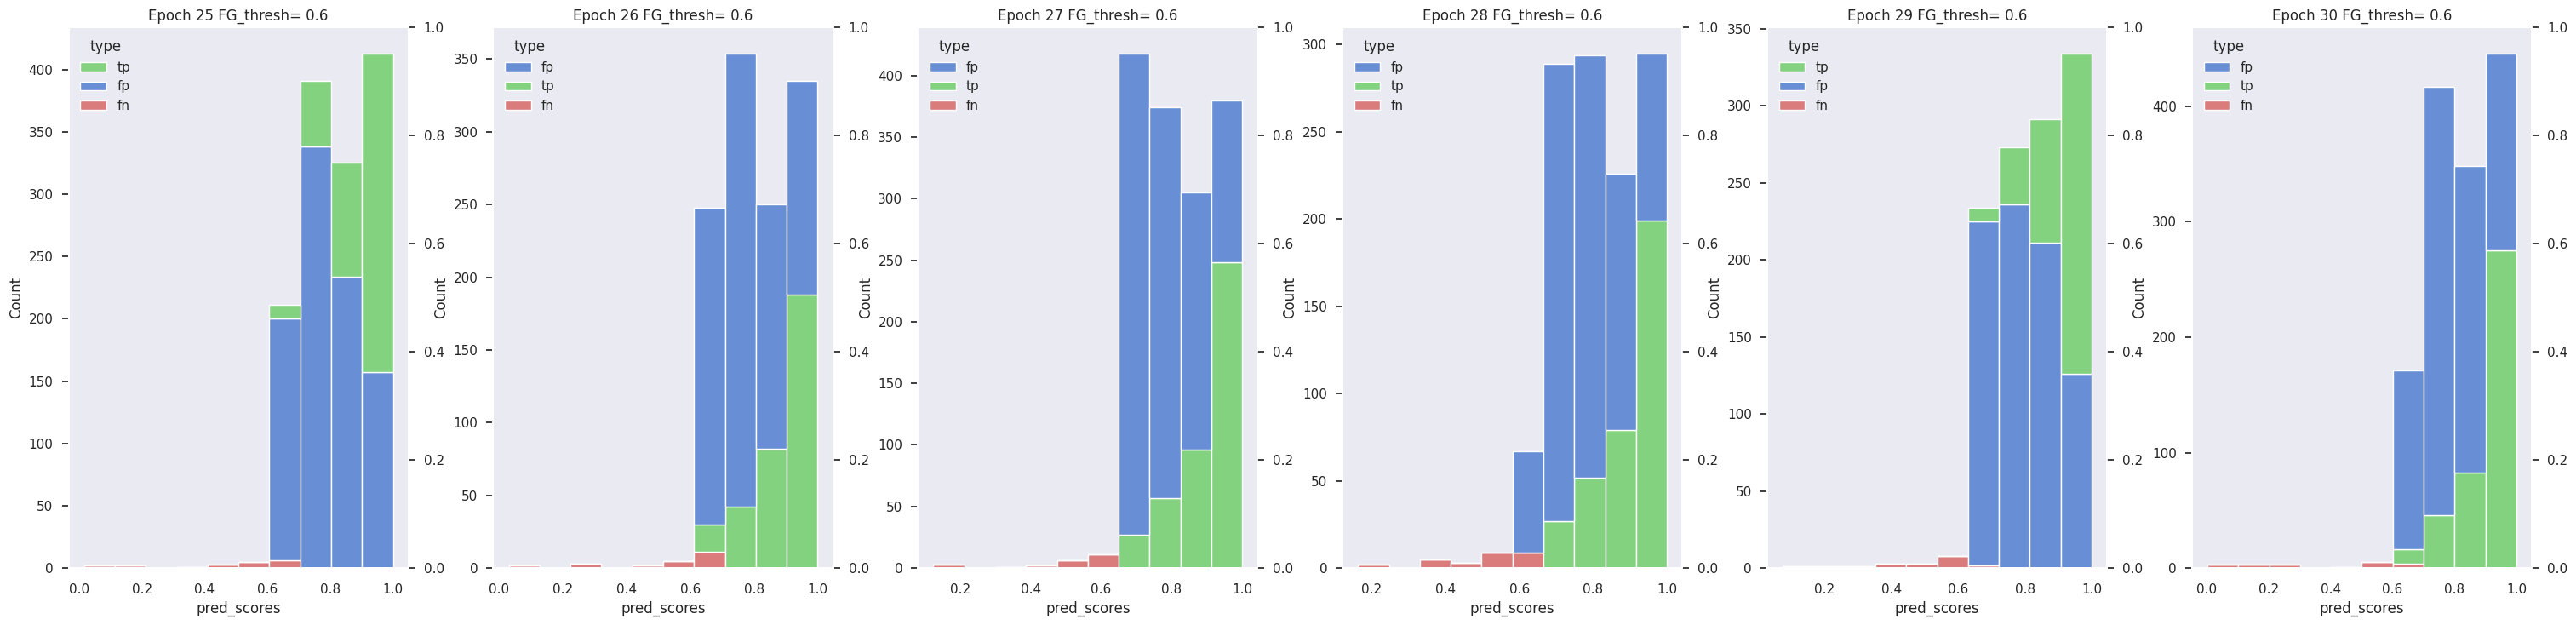

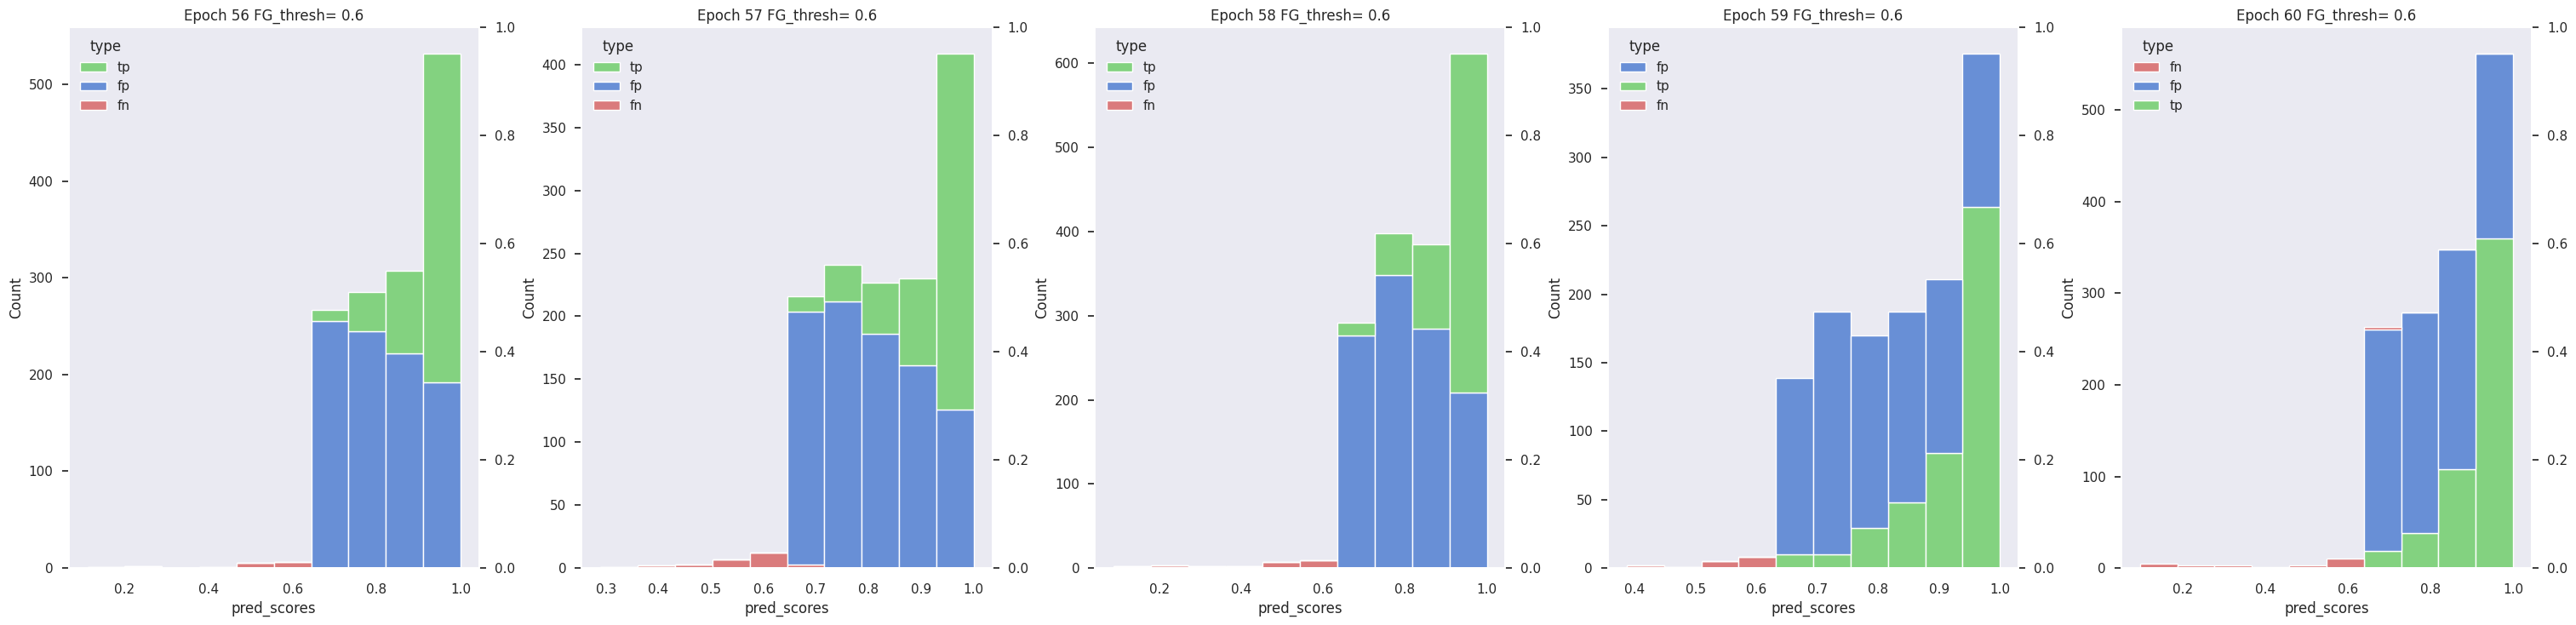

In [60]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_epoch(df,cls,start,end):

    cls_map = {'Car':1,'Ped':2,'Cyc':3}
    fg_gt_thresh = [0.7,0.5,0.5]
    fg_pl_thresh = [0.65, 0.45, 0.4]
    p = sns.color_palette("muted")
    sns.set_theme(style='dark')
    # group by each epoch
    grouped_df = df.groupby('epoch')
    cls_id = cls_map[cls]
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    palette = {'tp':p[2],'fp':p[0],'fn':p[3]}
    for i in range(start,end):
        # get particular epoch
        filter_df = grouped_df.get_group(float(i)) 
        cls_df = filter_df[filter_df['class_labels']==(cls_id)] # filter classes and tp fp fn tn classwise
        tp_mask = (fg_gt_thresh[cls_id-1] <= cls_df['iou_roi_gt']) & (fg_pl_thresh[cls_id-1] <= cls_df['pred_scores']) 
        fp_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[cls_id-1]) & (fg_pl_thresh[cls_id-1] <= cls_df['pred_scores'])
        fn_mask = (fg_gt_thresh[cls_id-1] <= cls_df['iou_roi_gt']) & (cls_df['pred_scores'] < fg_pl_thresh[cls_id-1])
        tn_mask = (cls_df['iou_roi_gt'] < fg_gt_thresh[cls_id-1]) & (cls_df['pred_scores'] < fg_pl_thresh[cls_id-1])
        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        cls_df = cls_df[~tn_mask]
        sns.histplot(ax=axes[i-start],data=cls_df,x='pred_scores',hue='type',multiple='stack',stat='count',bins=10,fill=True,alpha=0.8,palette=palette)
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch(stats_df,'Car',25,31)
plot_epoch(stats_df,'Car',56,61)

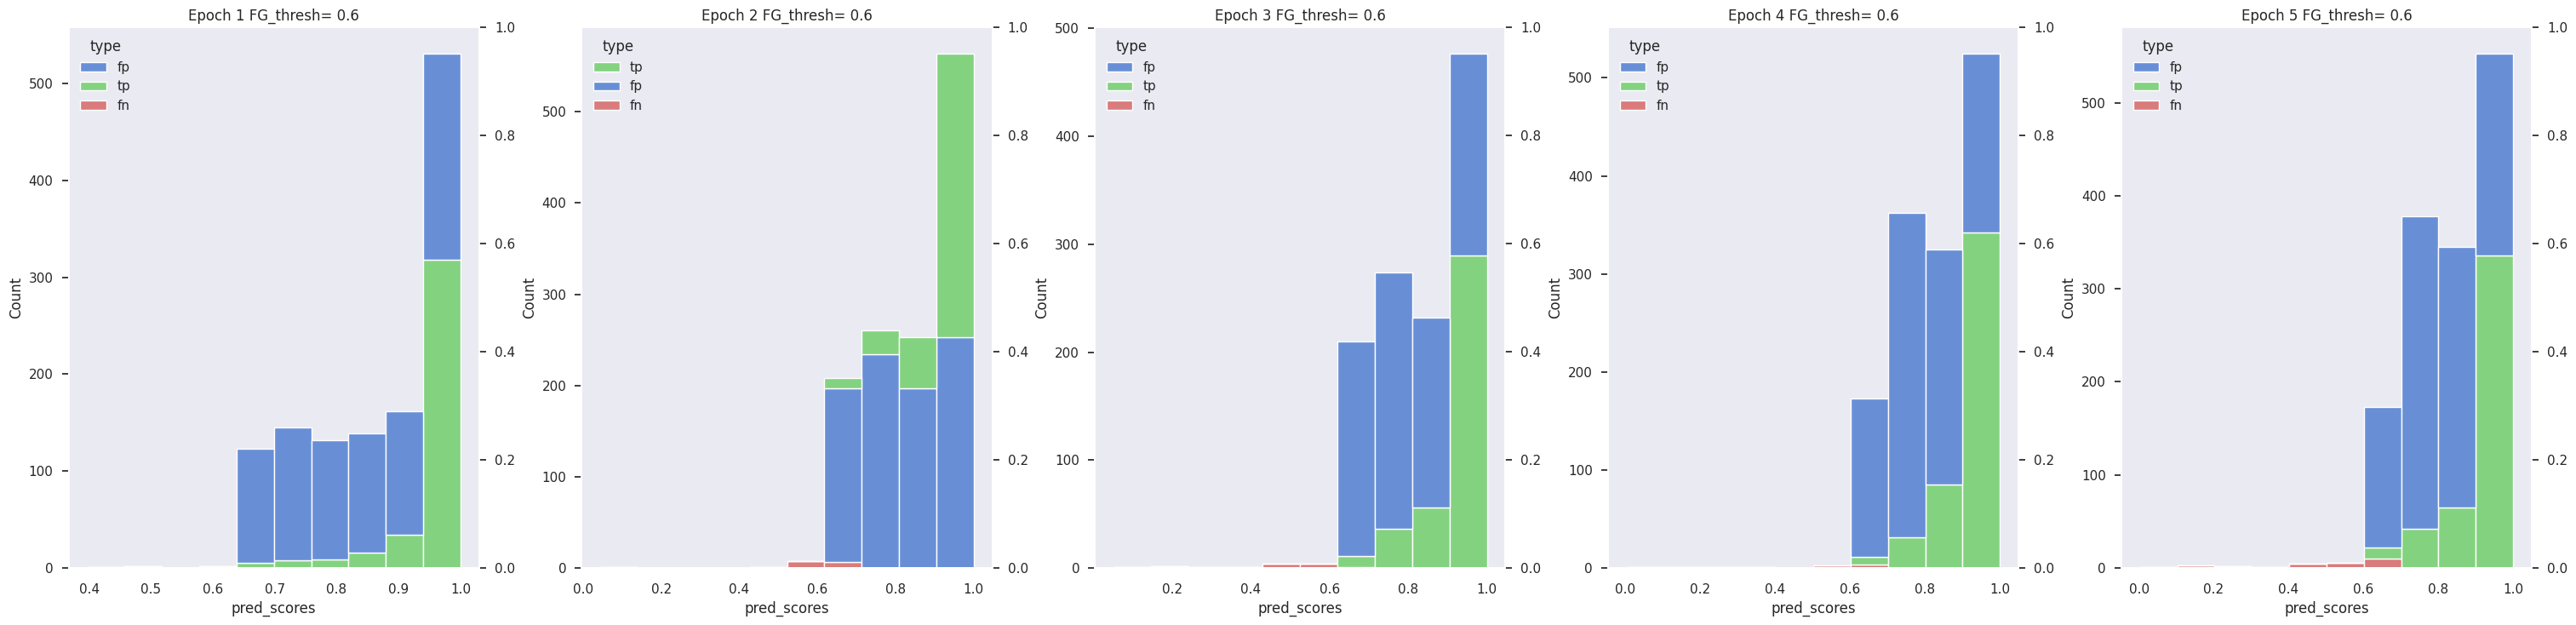

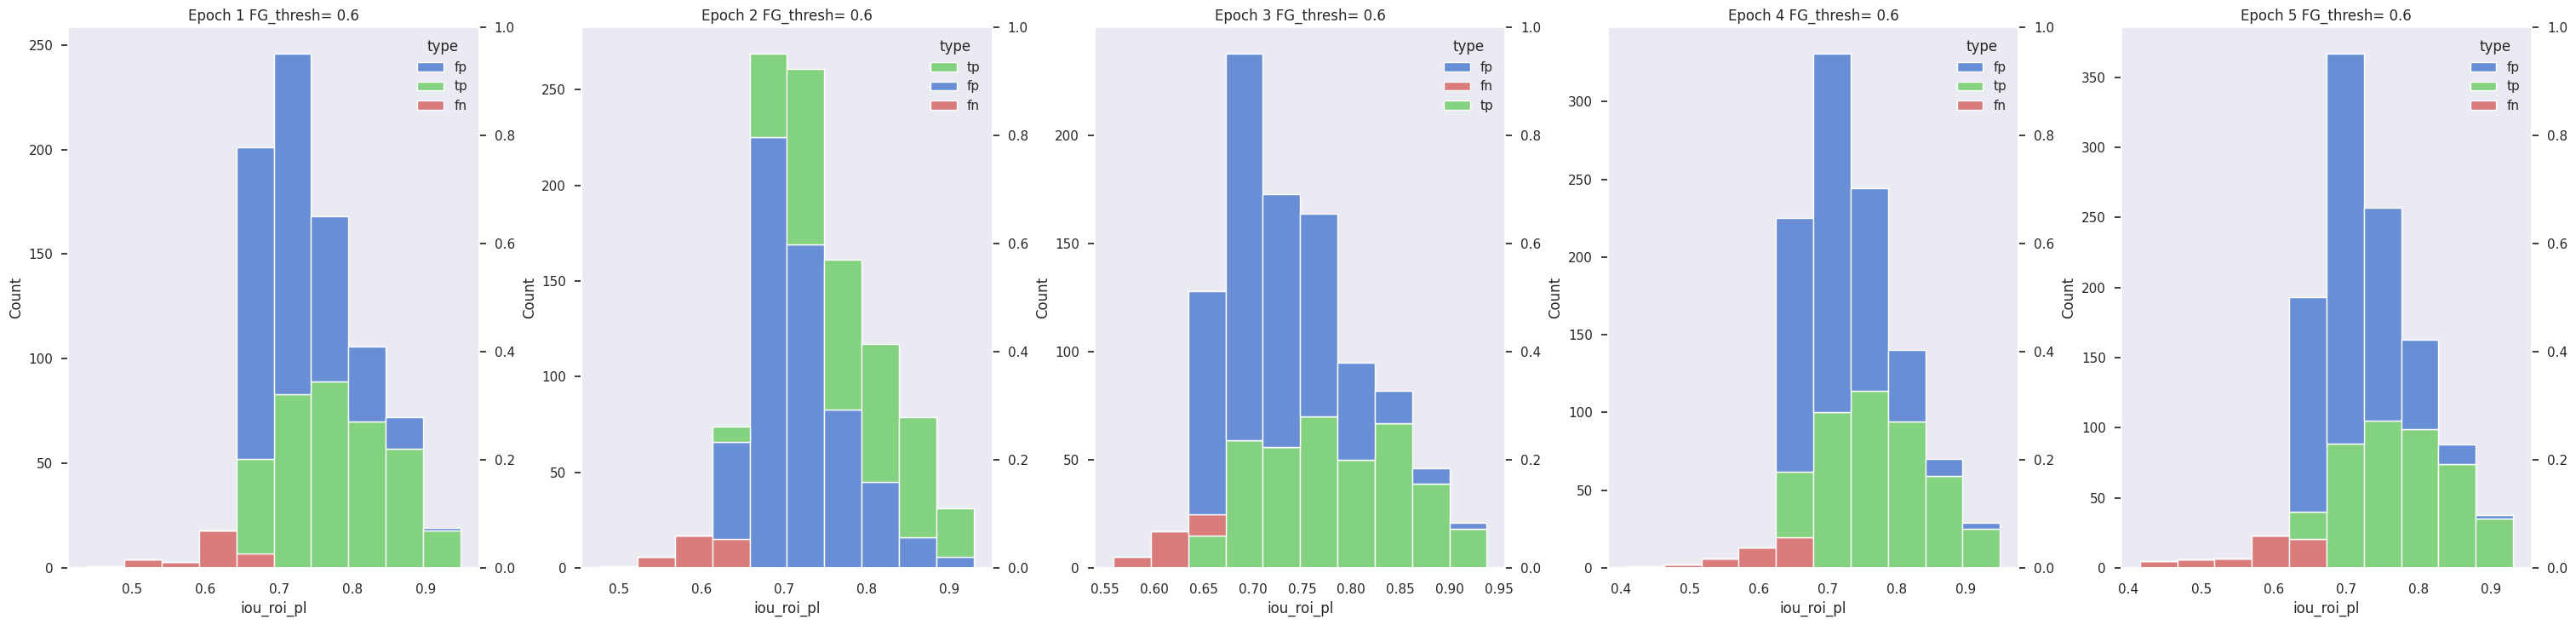

In [61]:
plot_epoch(stats_df,'Car',1,6)
plot_epoch_iou(stats_df,'Car',1,6)

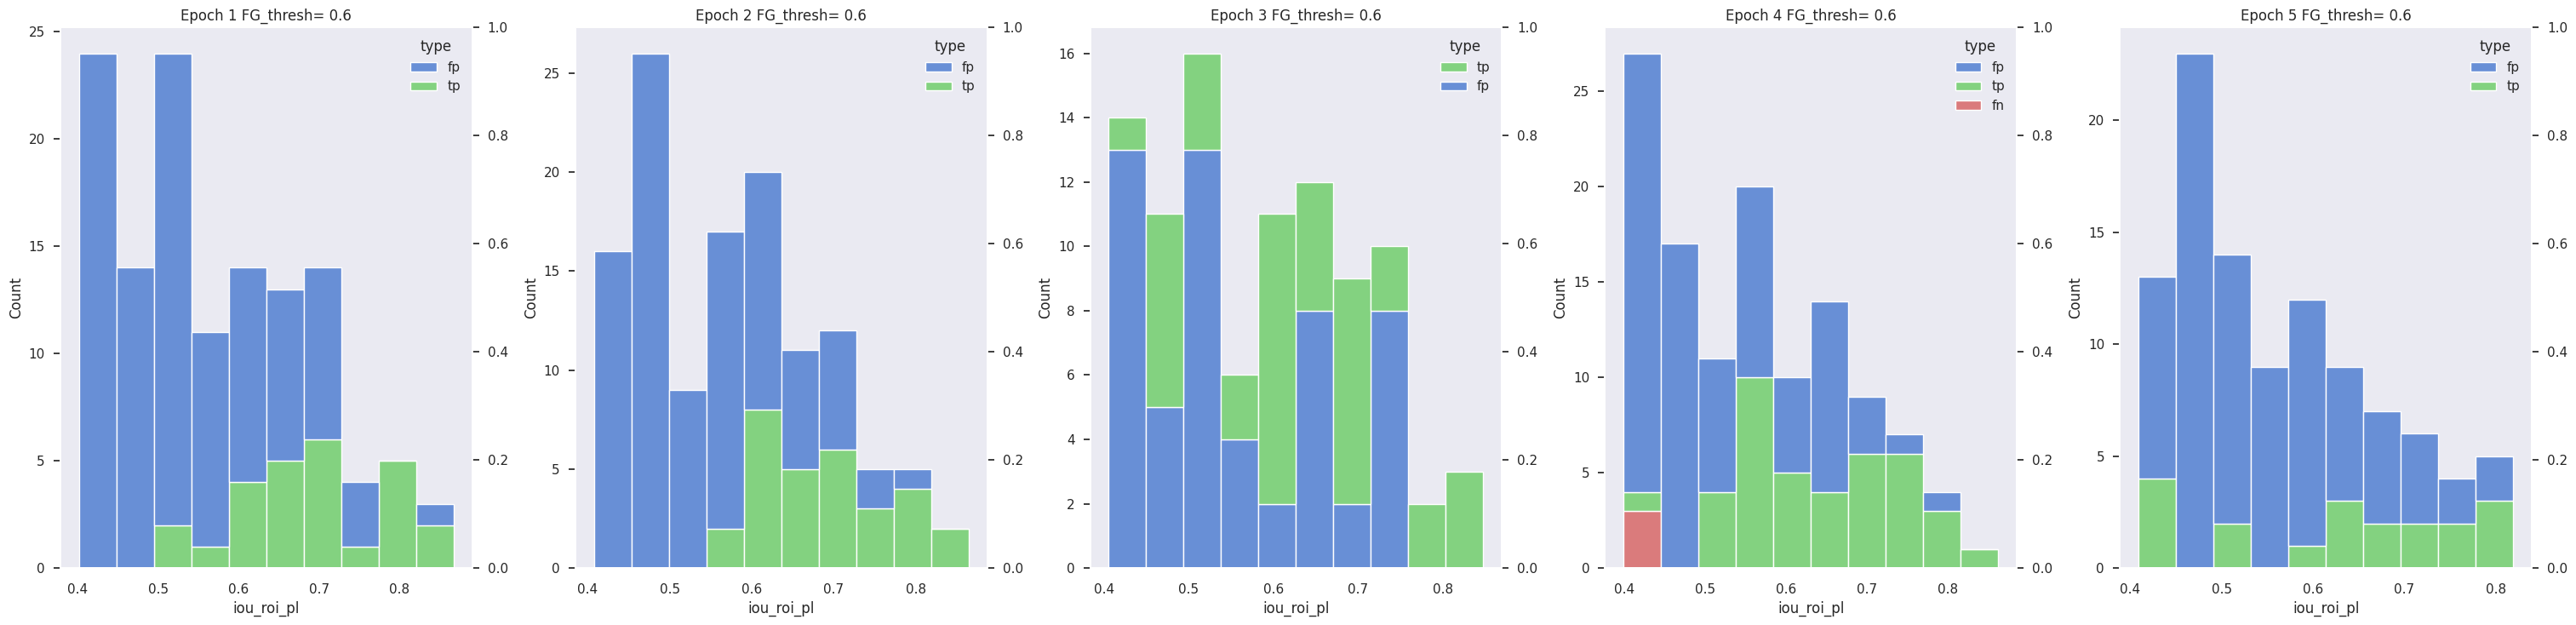

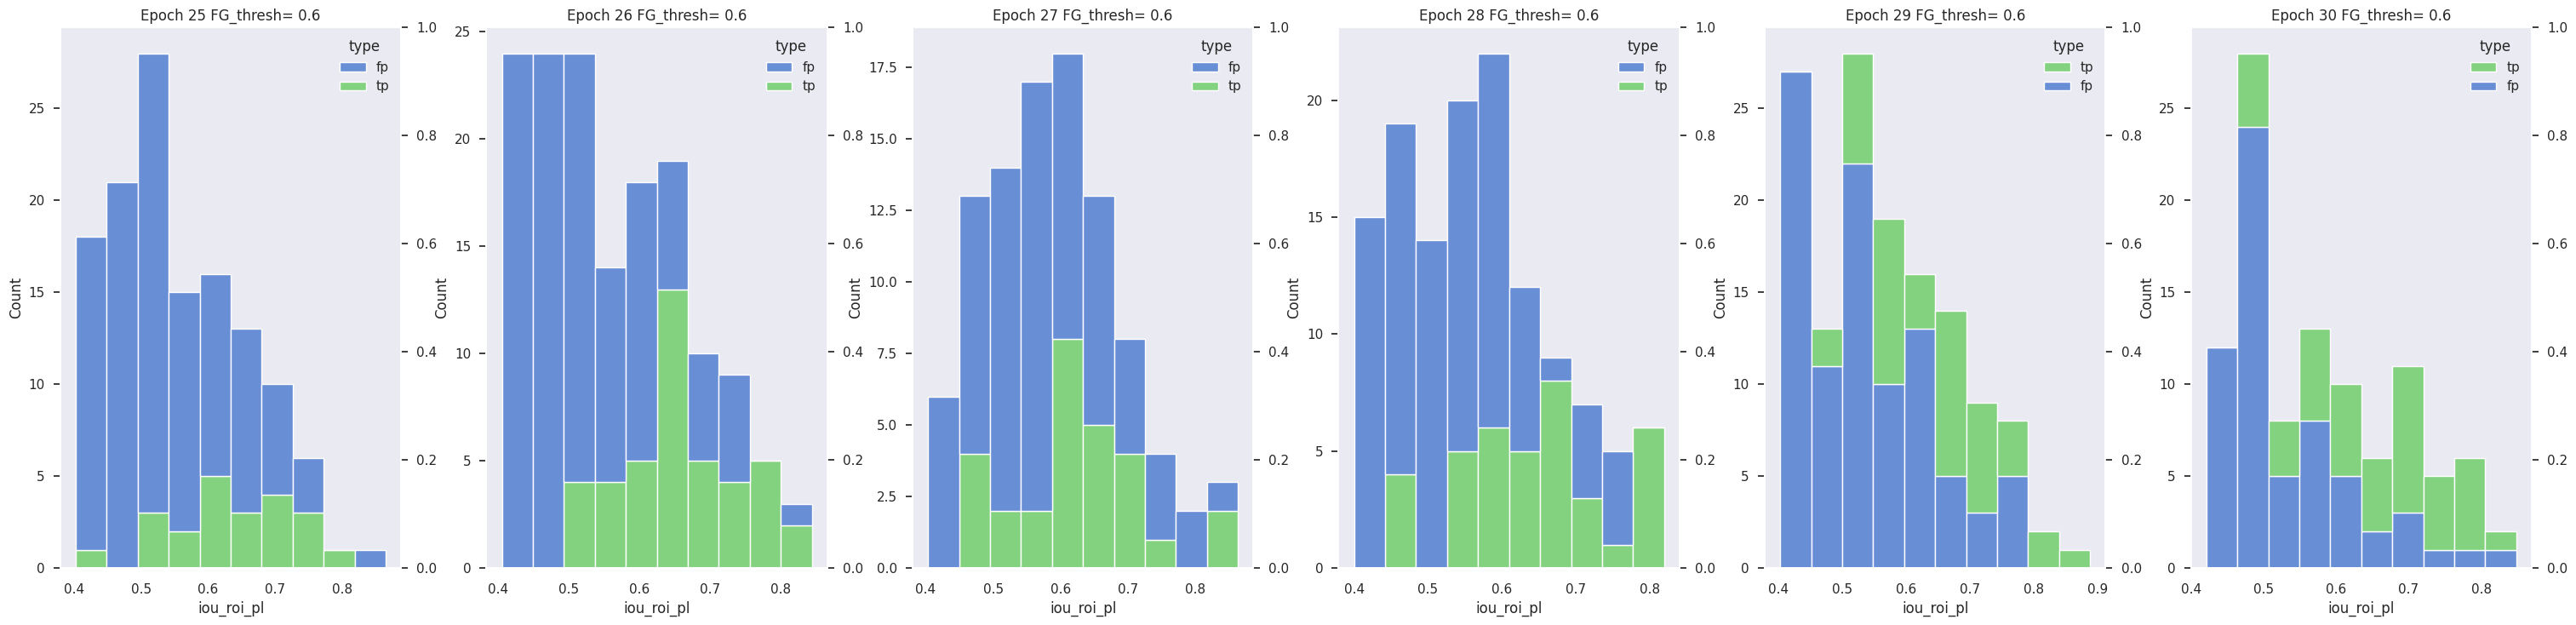

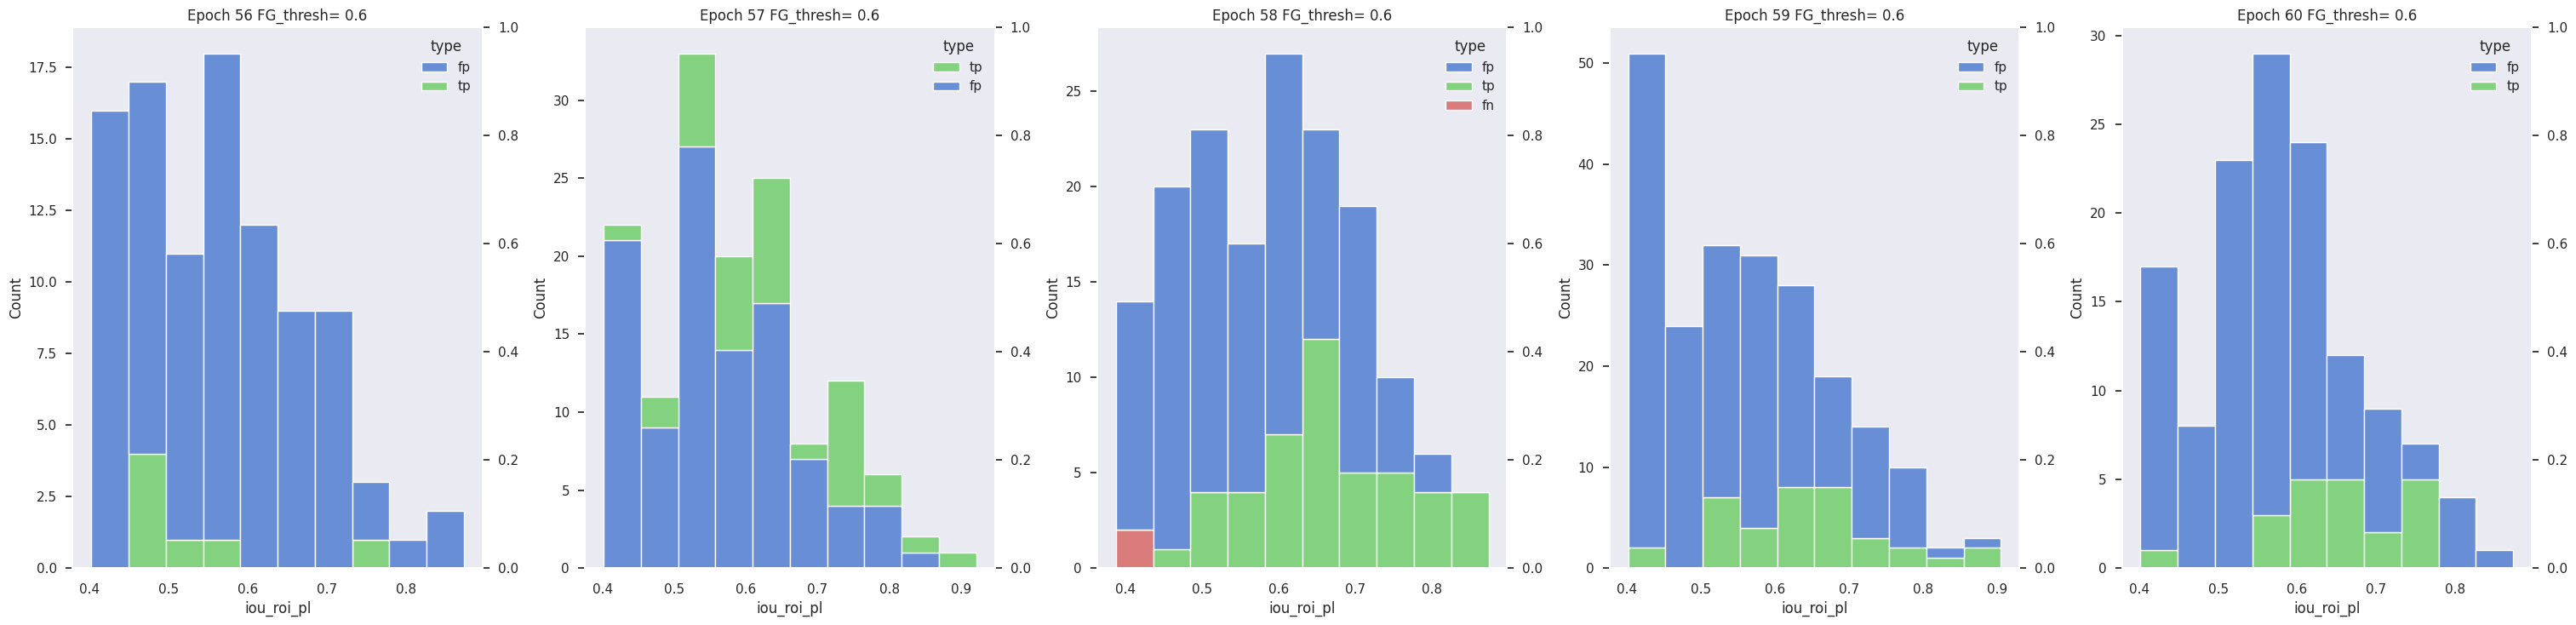

In [62]:
plot_epoch_iou(stats_df,'Cyc',1,6)
plot_epoch_iou(stats_df,'Cyc',25,31)
plot_epoch_iou(stats_df,'Cyc',56,61)

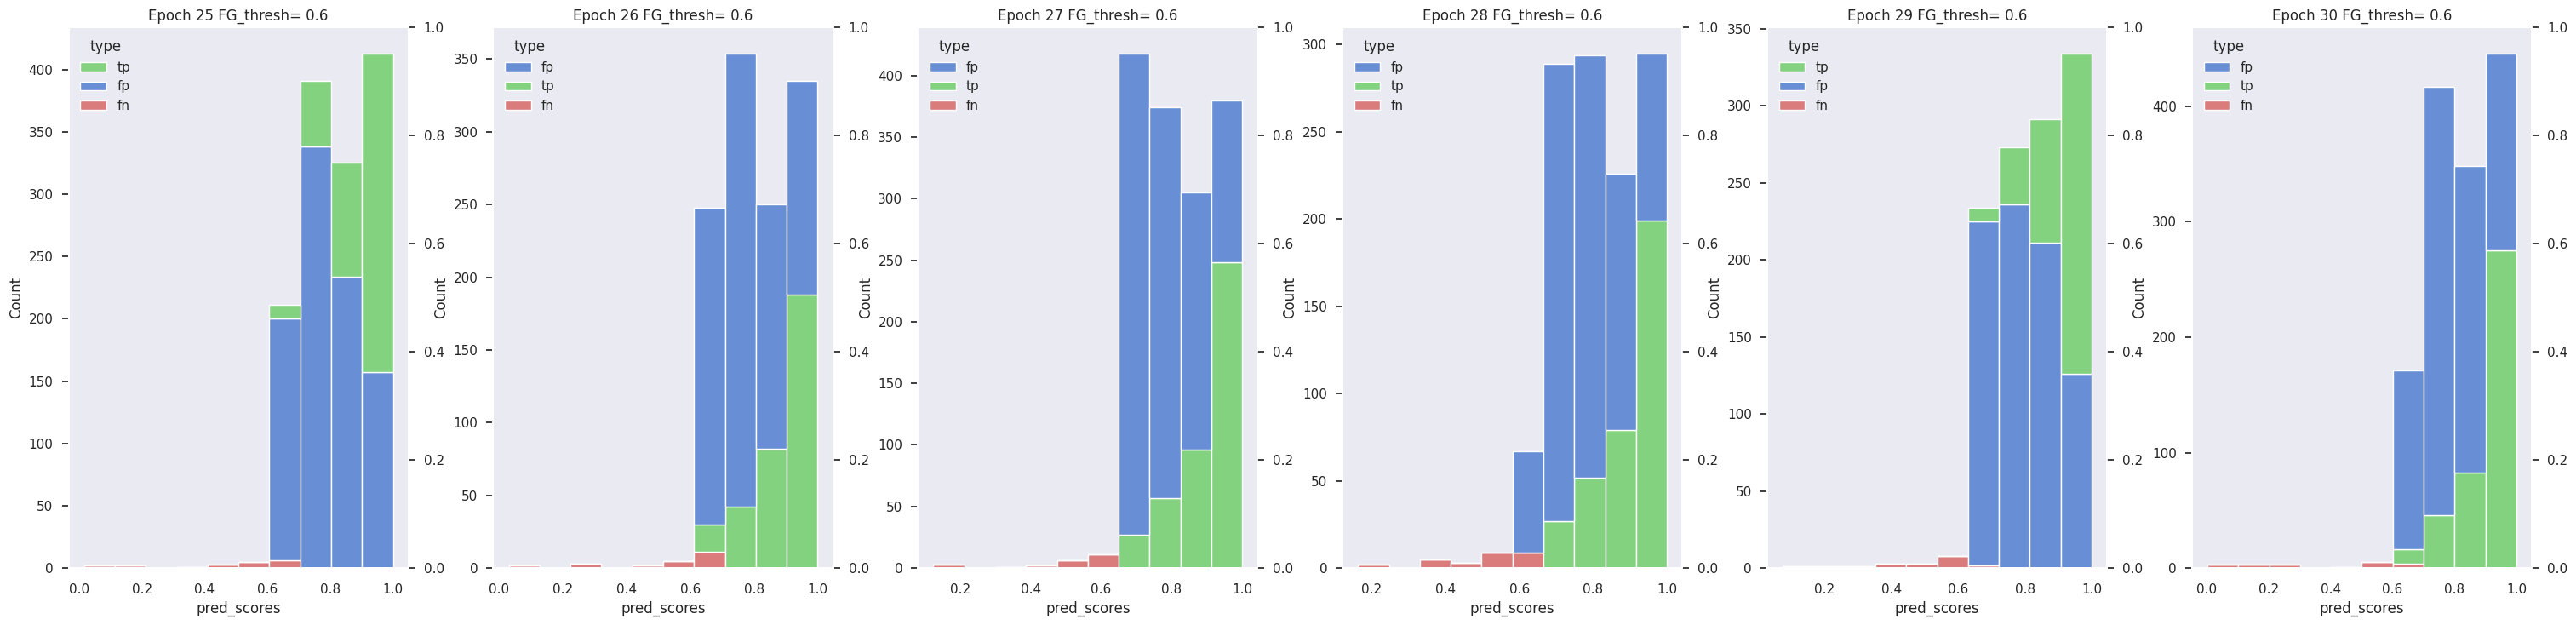

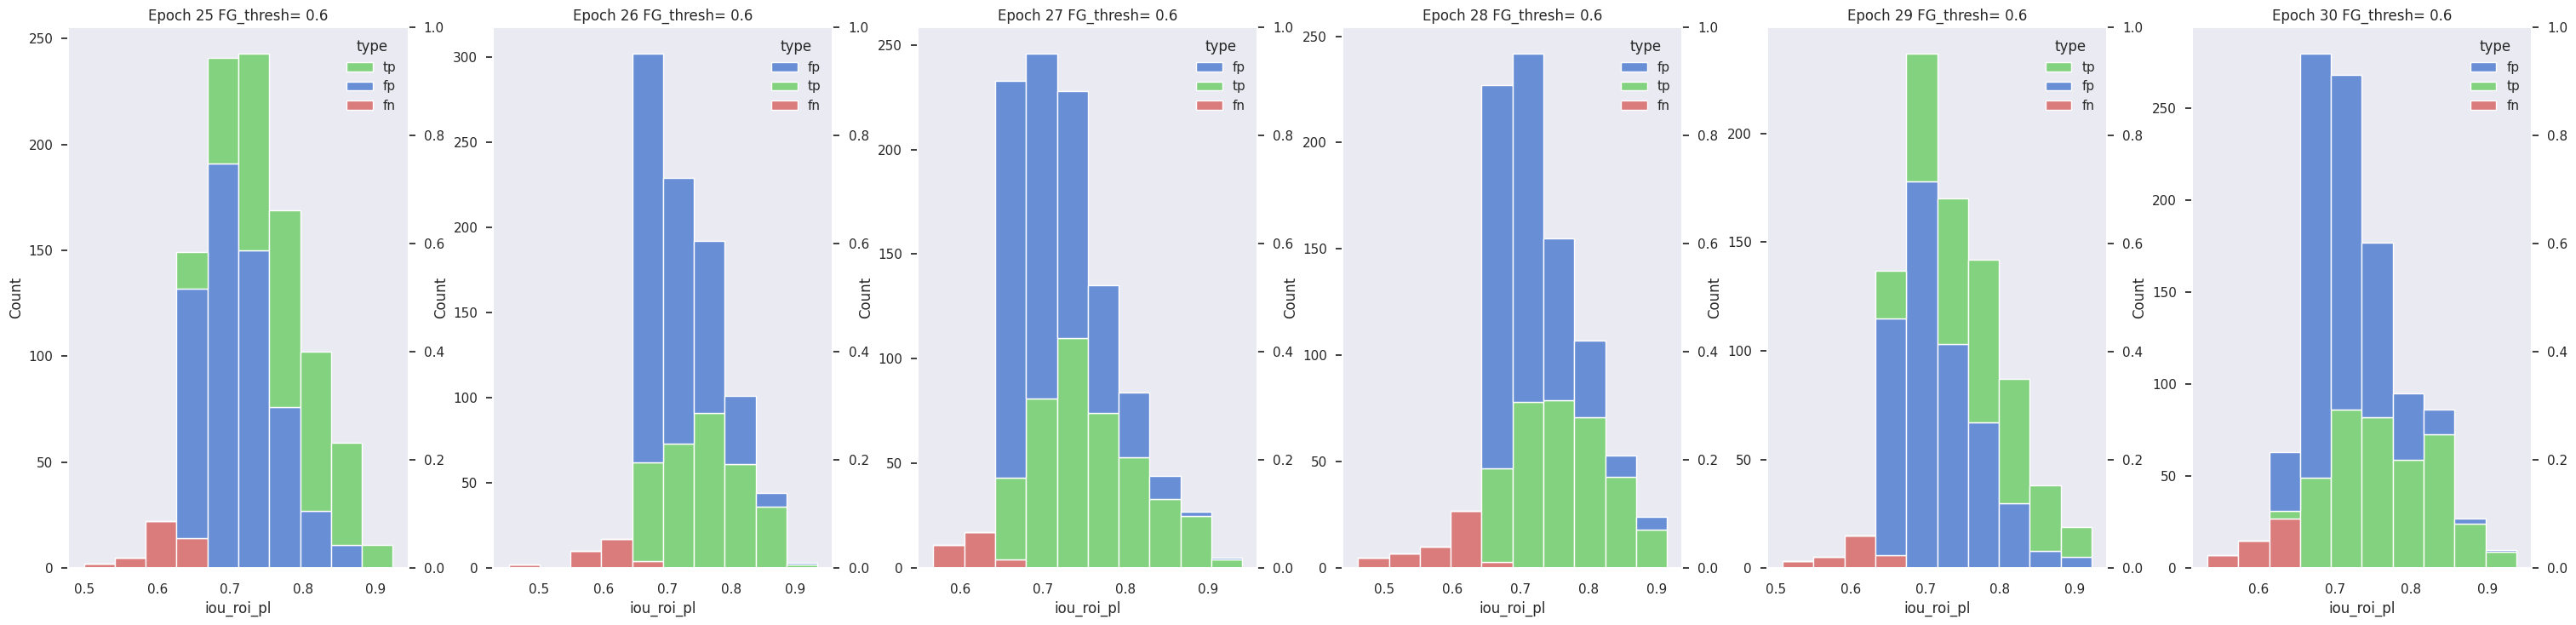

In [63]:

plot_epoch(stats_df,'Car',25,31)
plot_epoch_iou(stats_df,'Car',25,31)

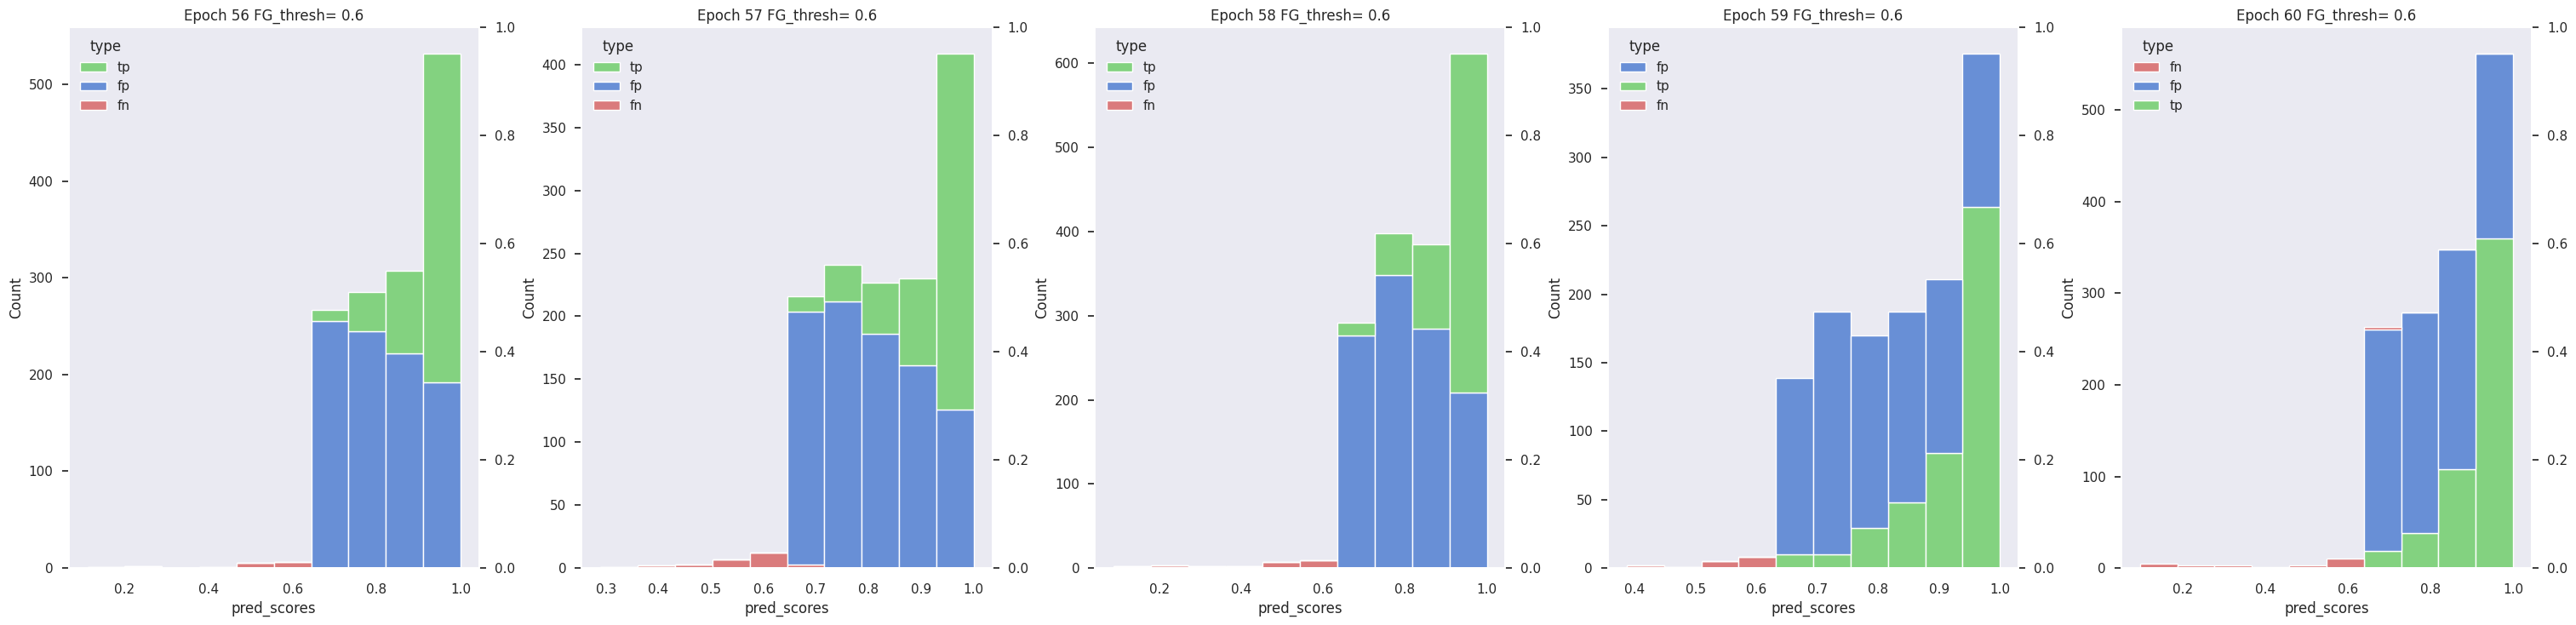

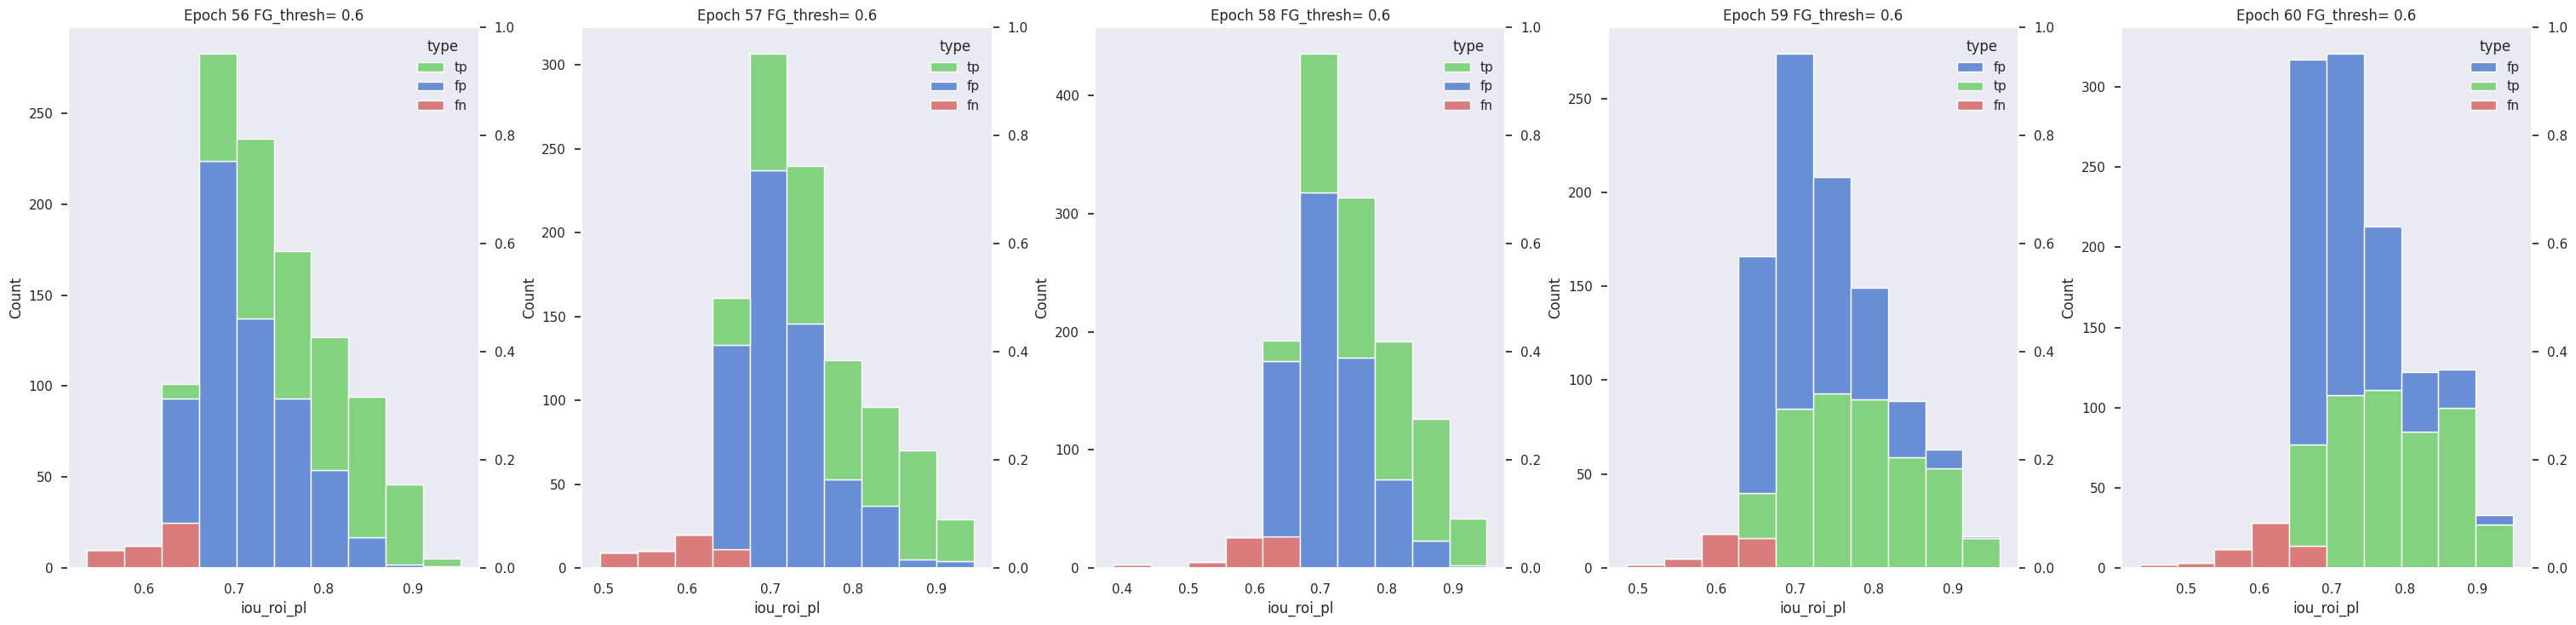

In [64]:
plot_epoch(stats_df,'Car',56,61)
plot_epoch_iou(stats_df,'Car',56,61)

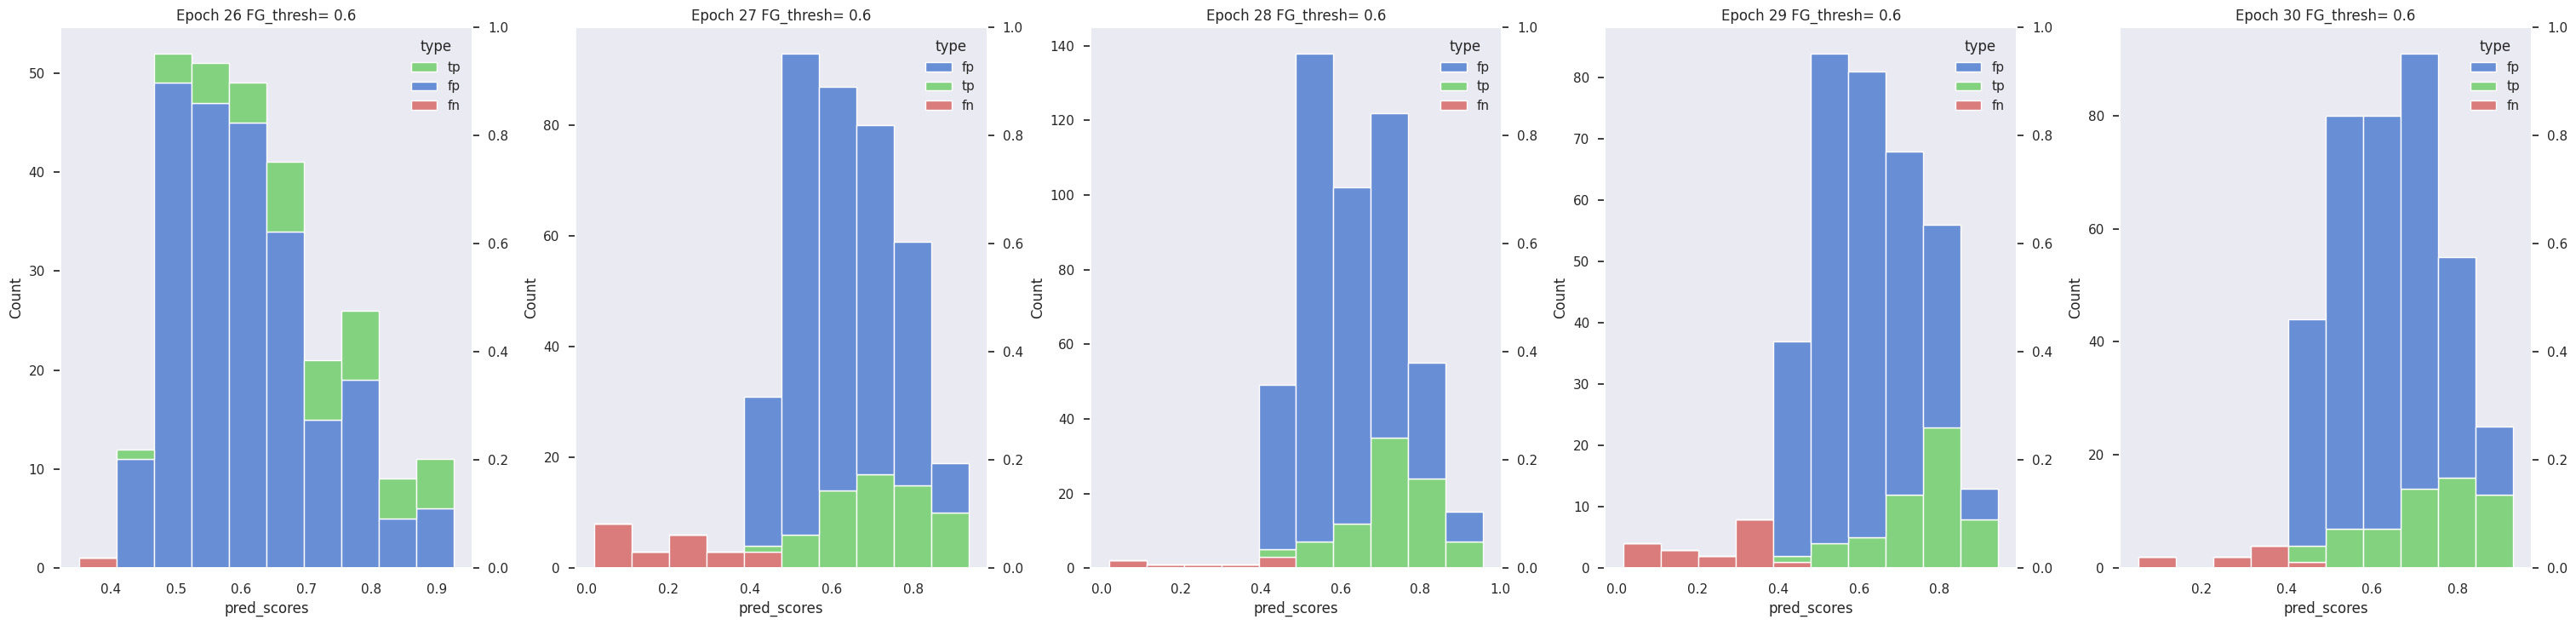

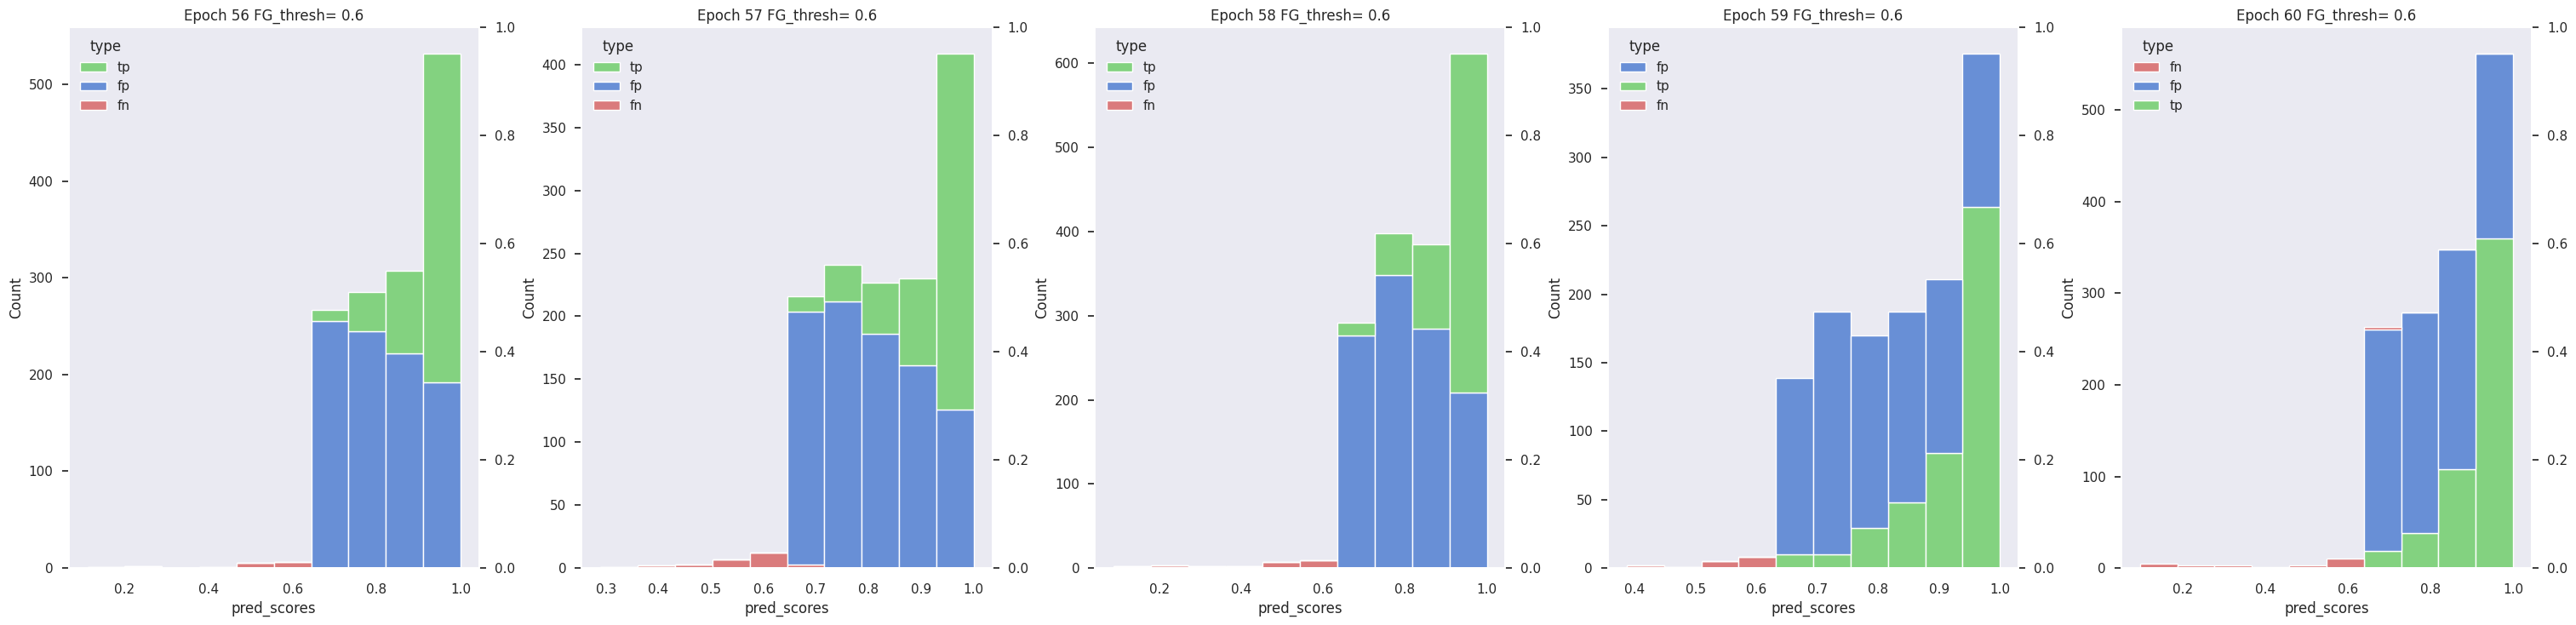

In [65]:
plot_epoch(stats_df,'Ped',26,31)
plot_epoch(stats_df,'Car',56,61)

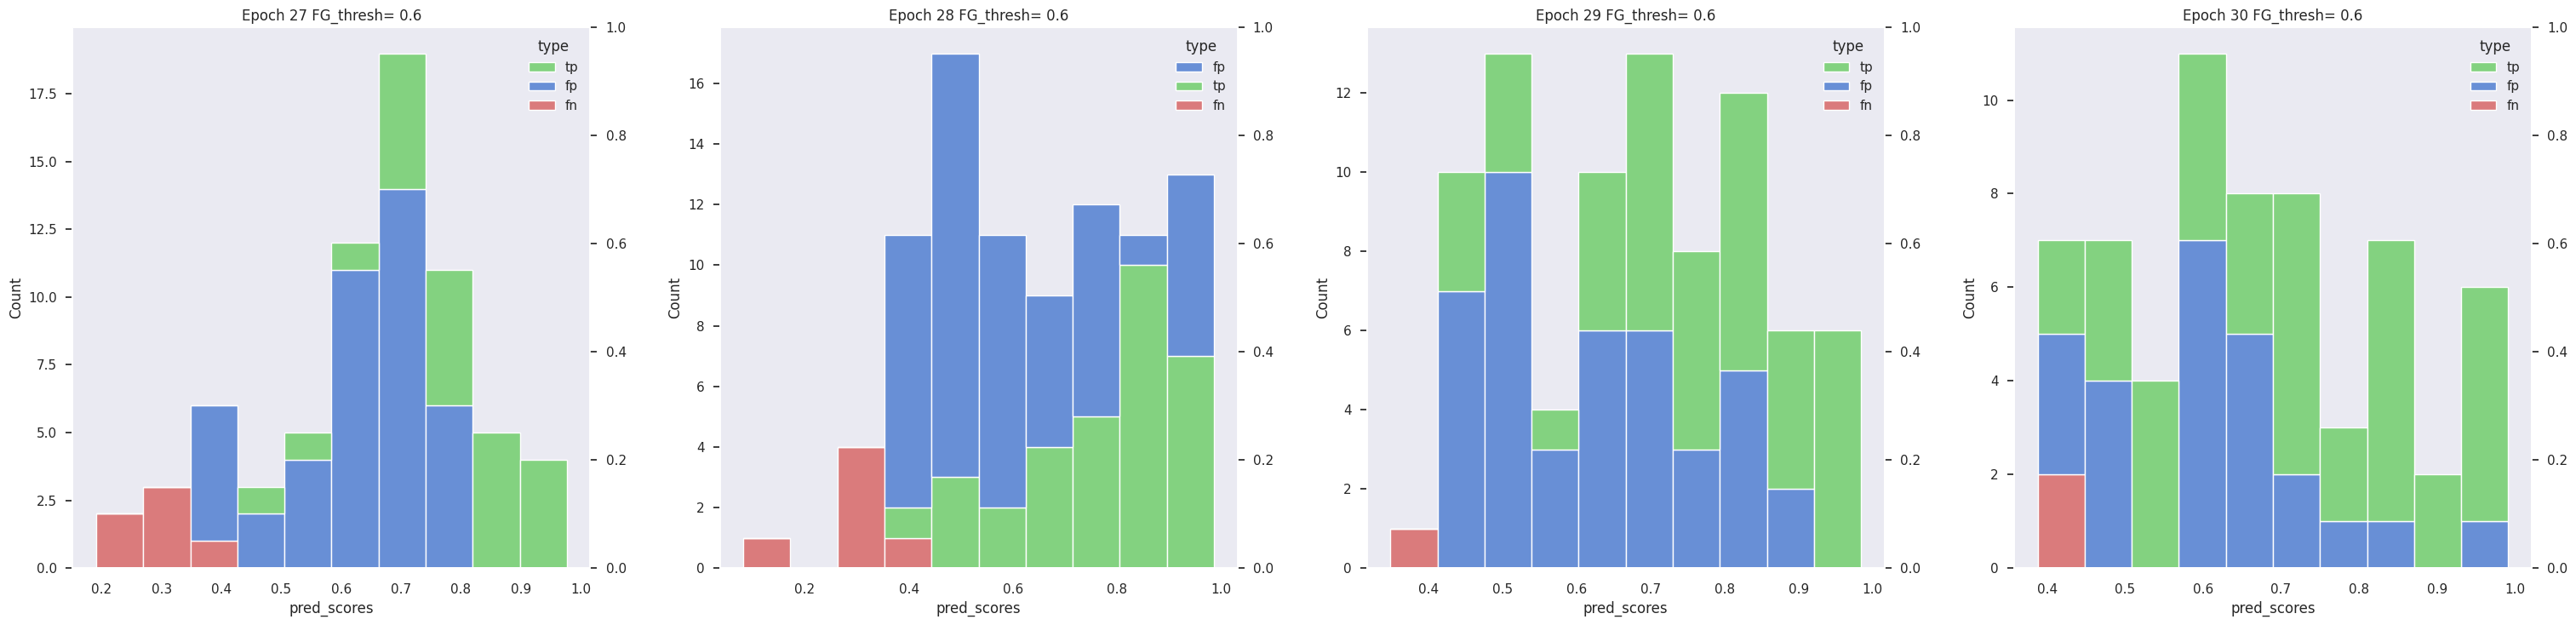

In [66]:
plot_epoch(stats_df,'Cyc',27,31)

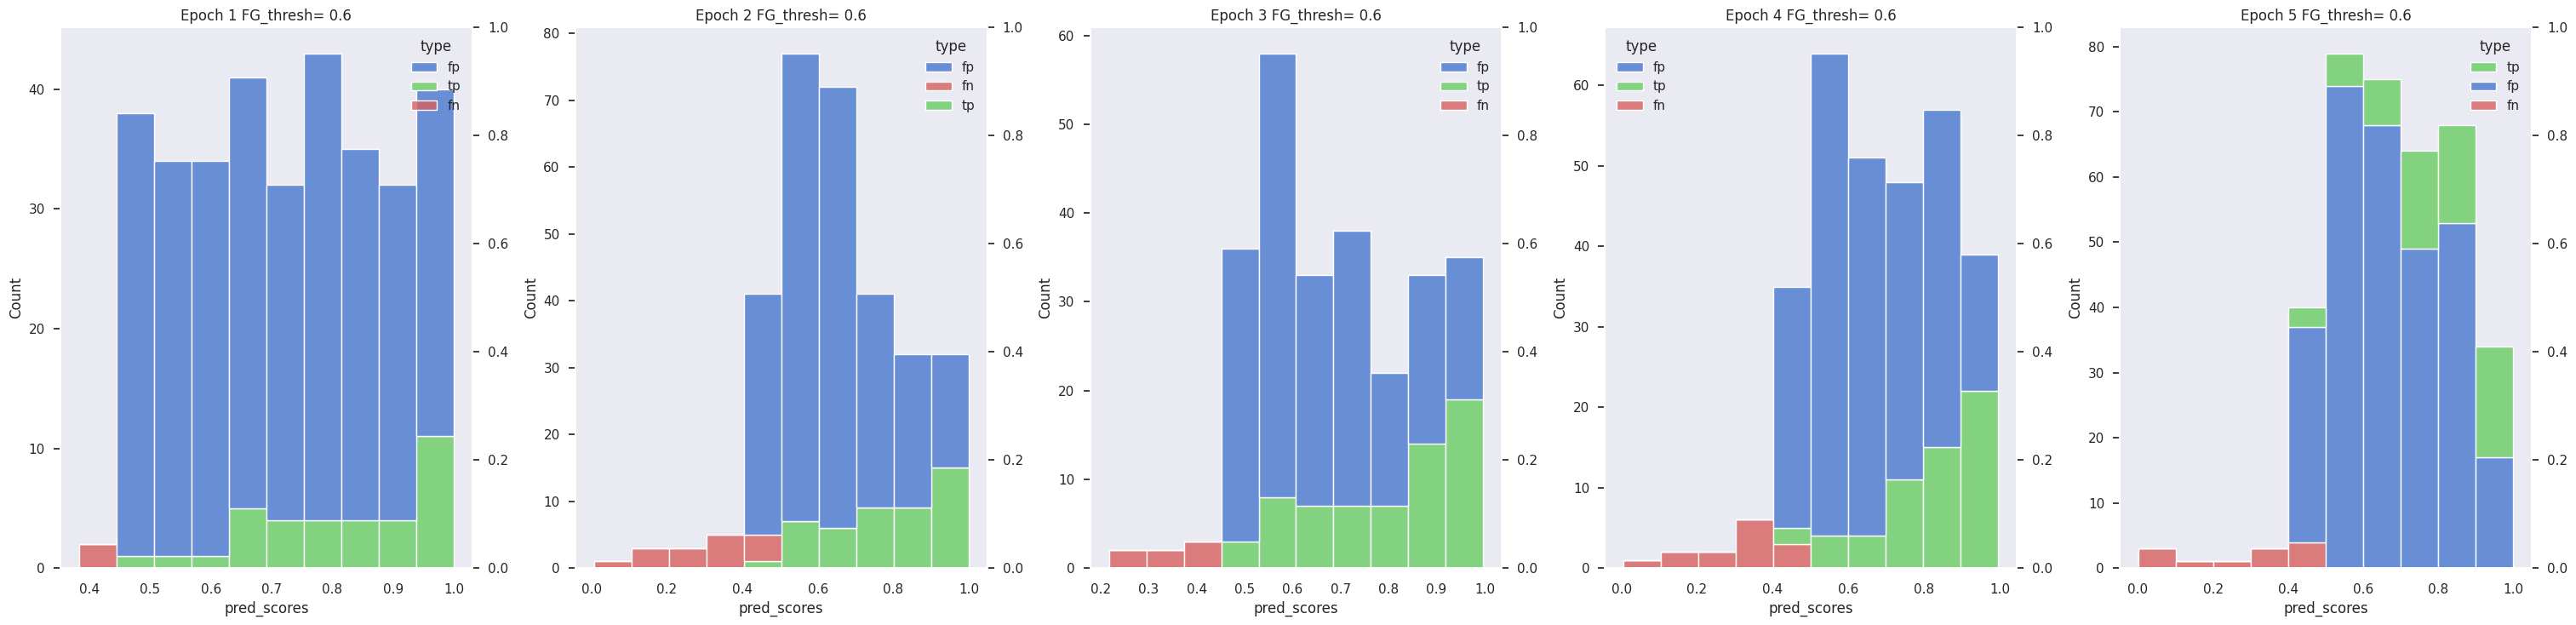

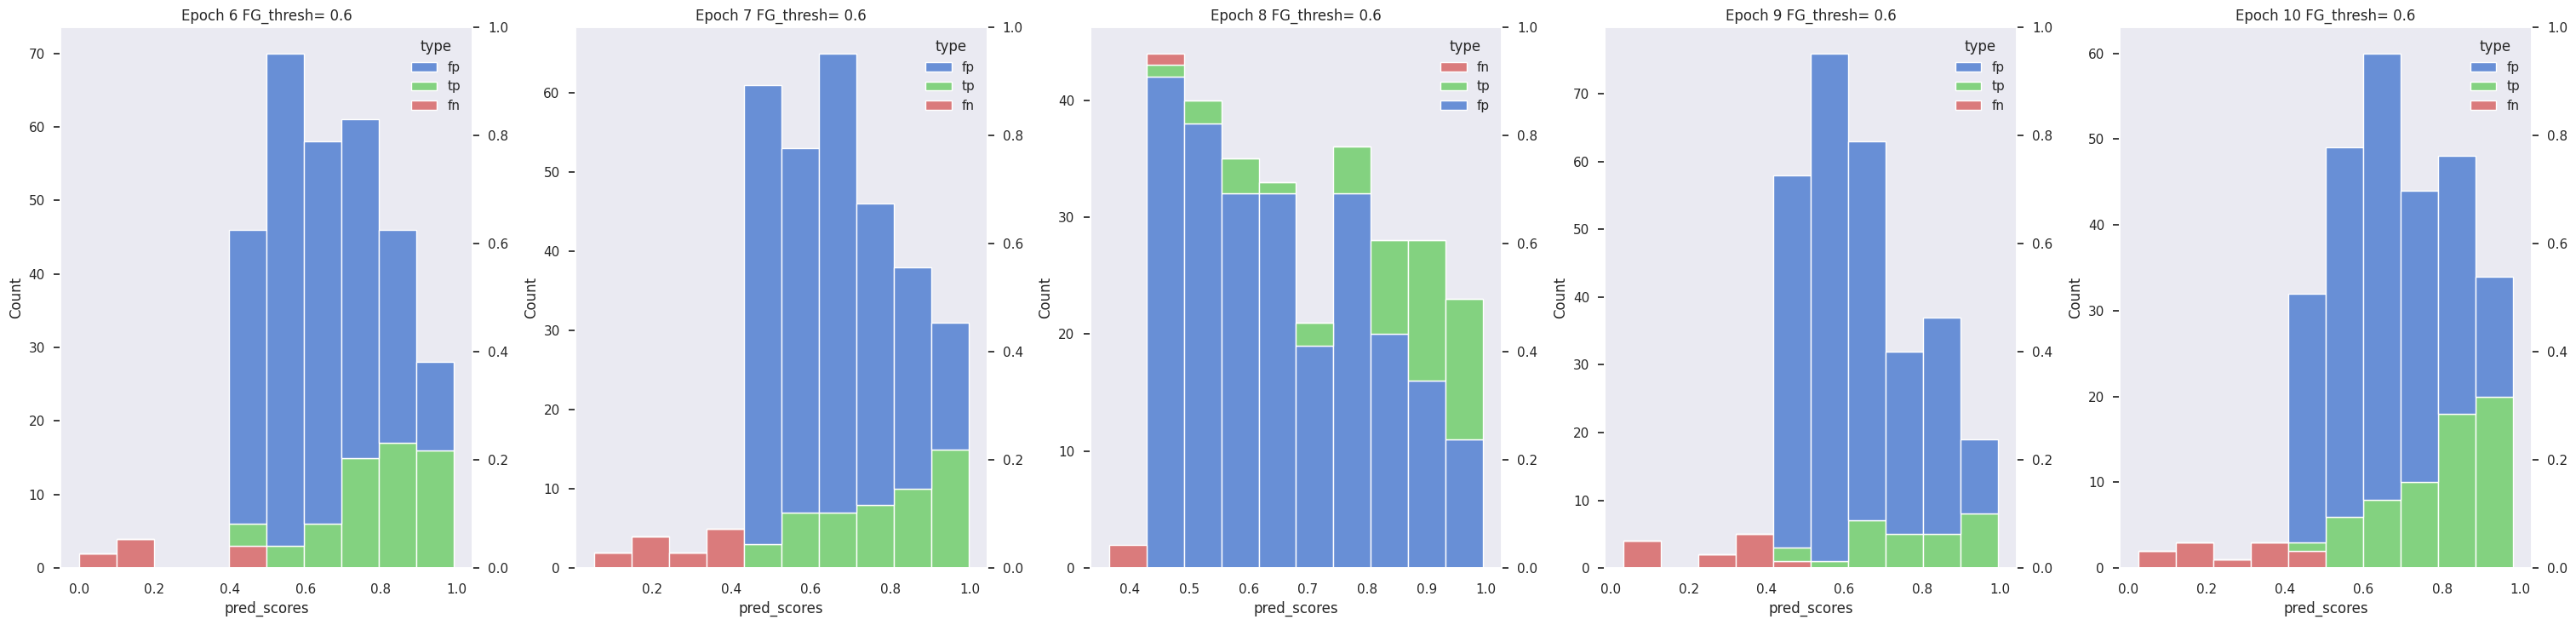

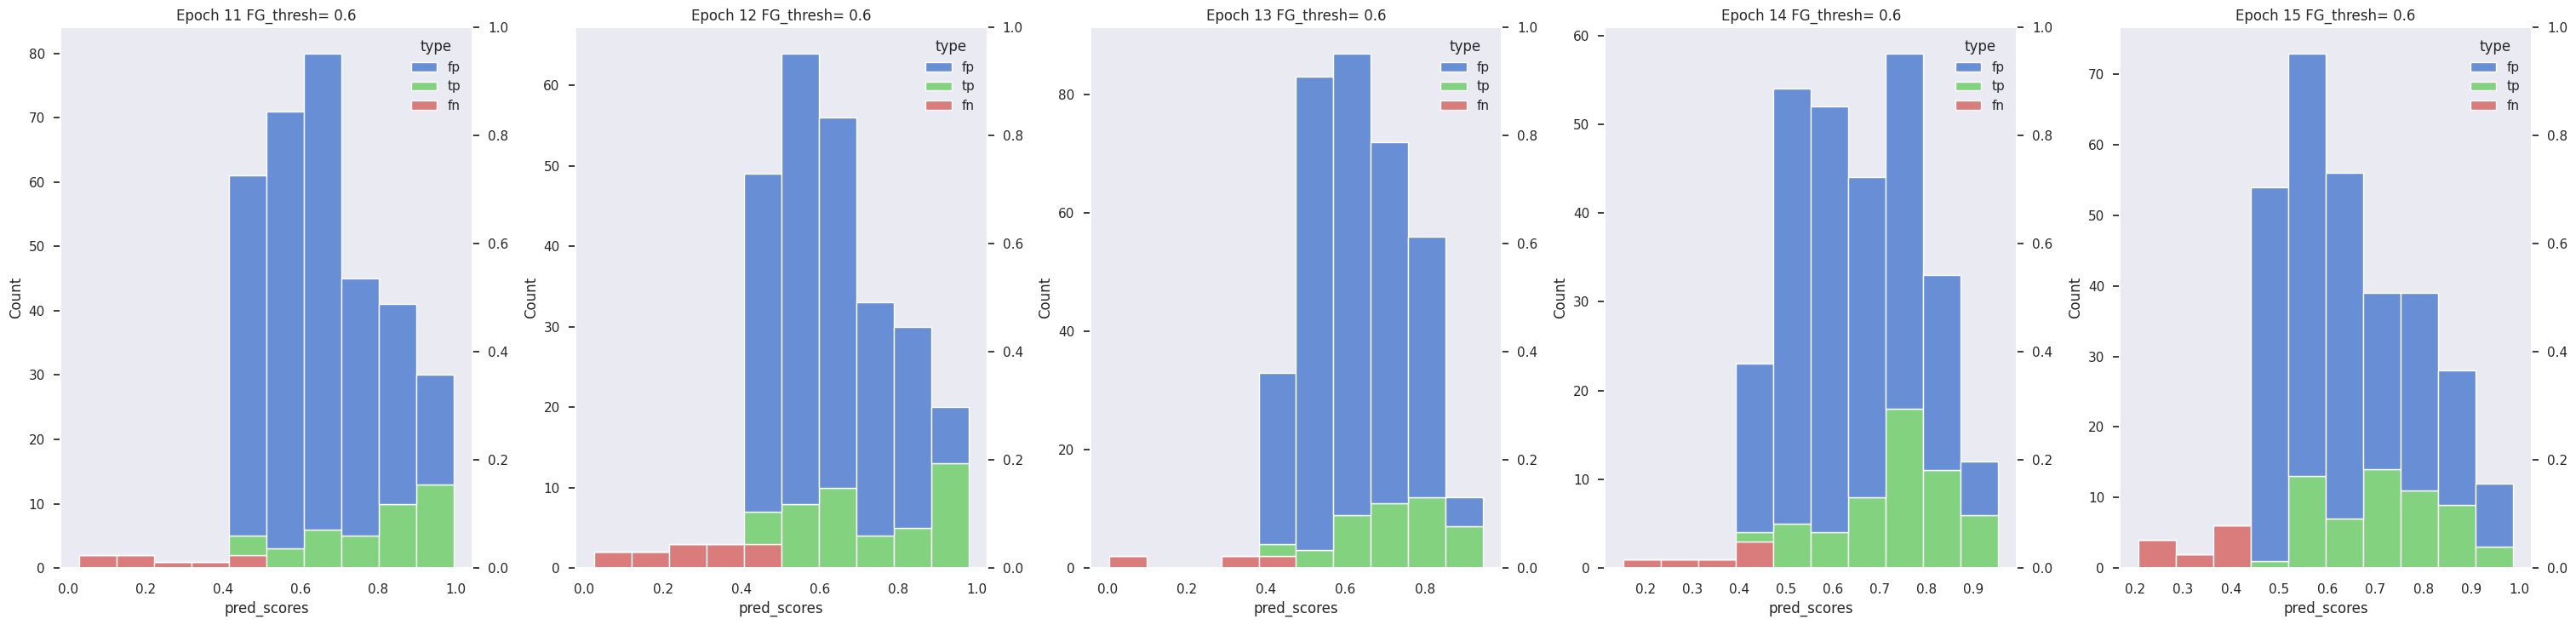

In [67]:
plot_epoch(stats_df,'Ped',1,6)
plot_epoch(stats_df,'Ped',6,11)
plot_epoch(stats_df,'Ped',11,16)

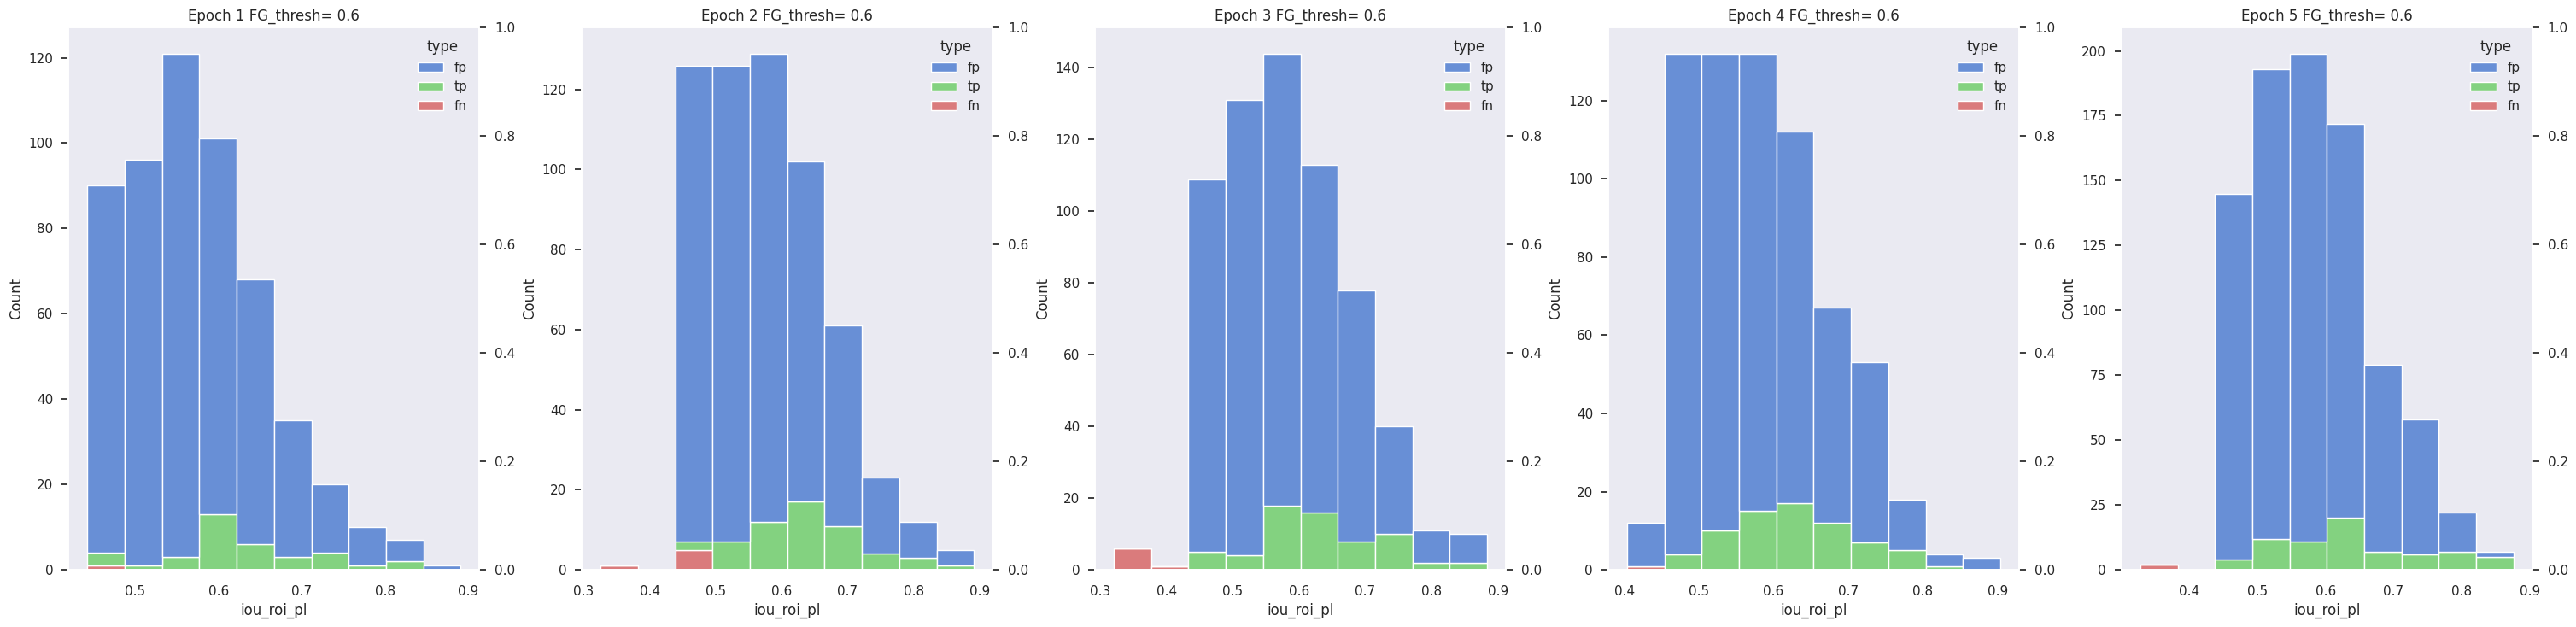

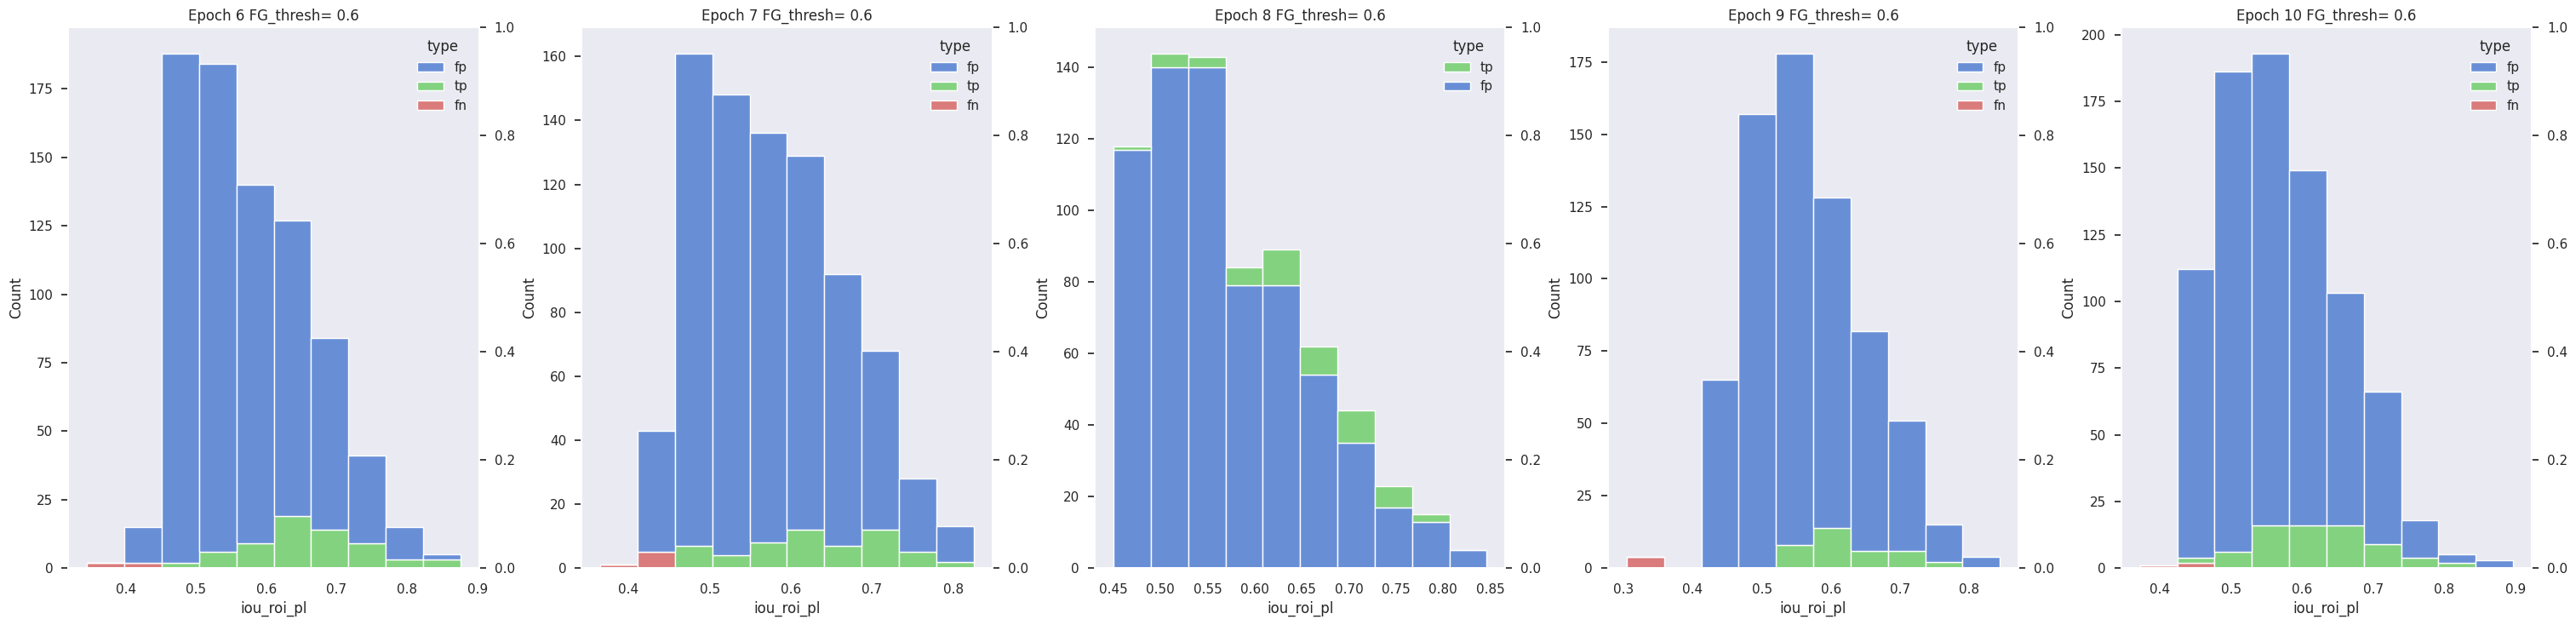

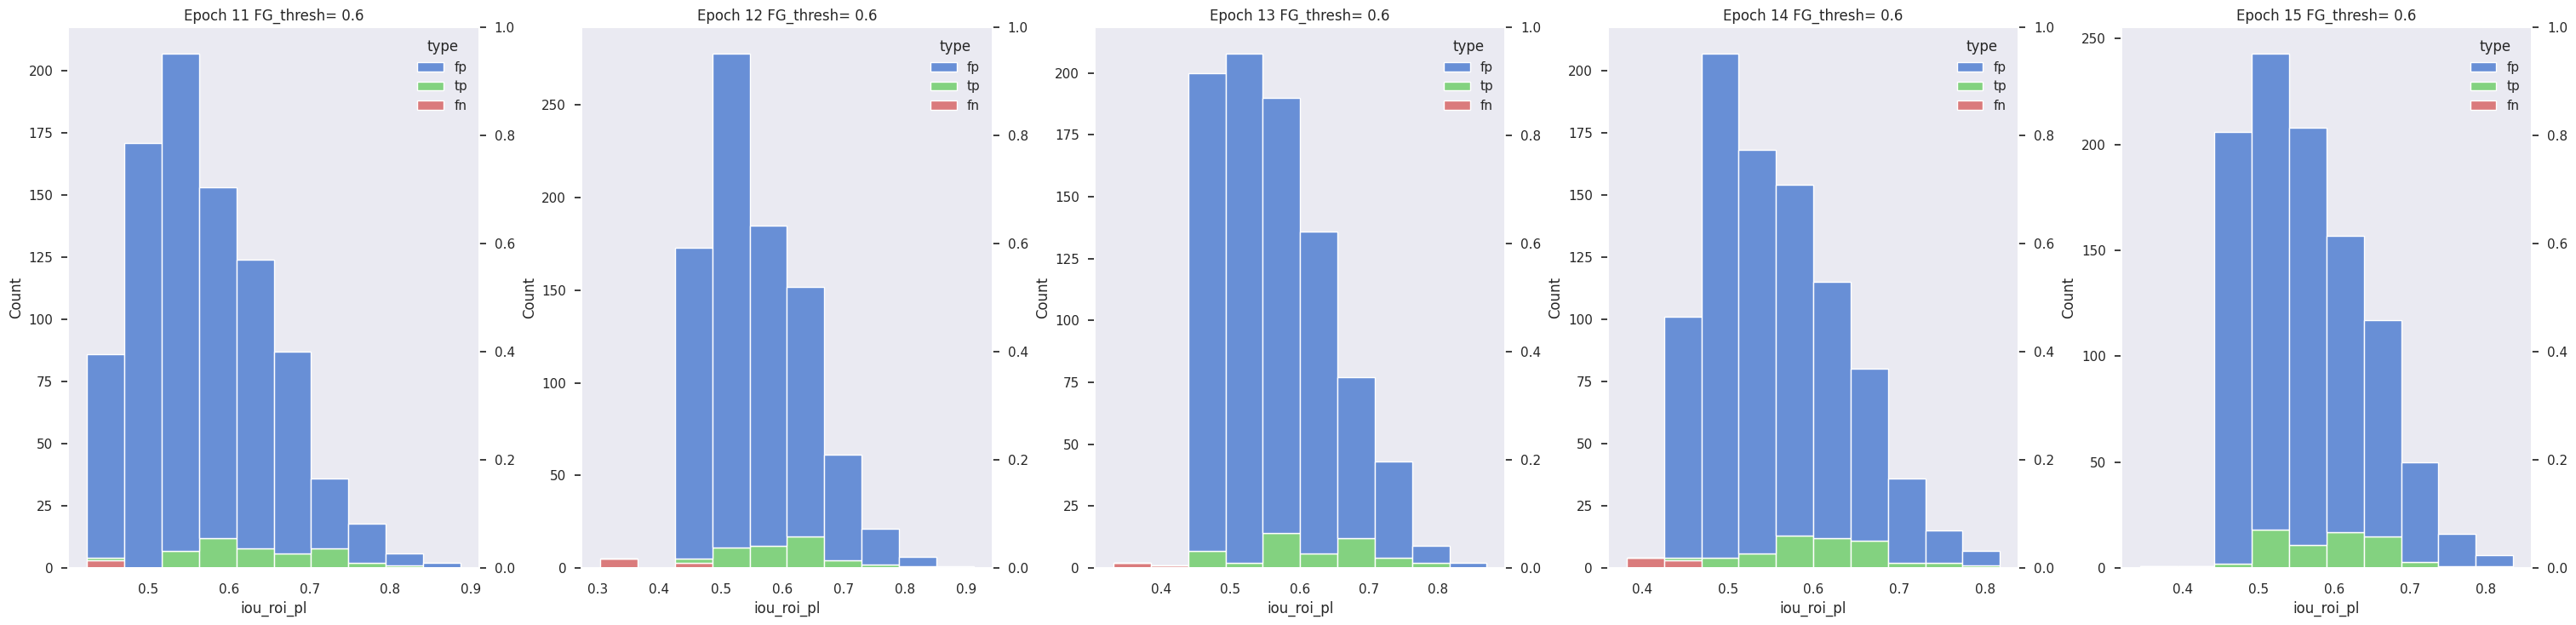

In [68]:
plot_epoch_iou(stats_df,'Ped',1,6)
plot_epoch_iou(stats_df,'Ped',6,11)
plot_epoch_iou(stats_df,'Ped',11,16)

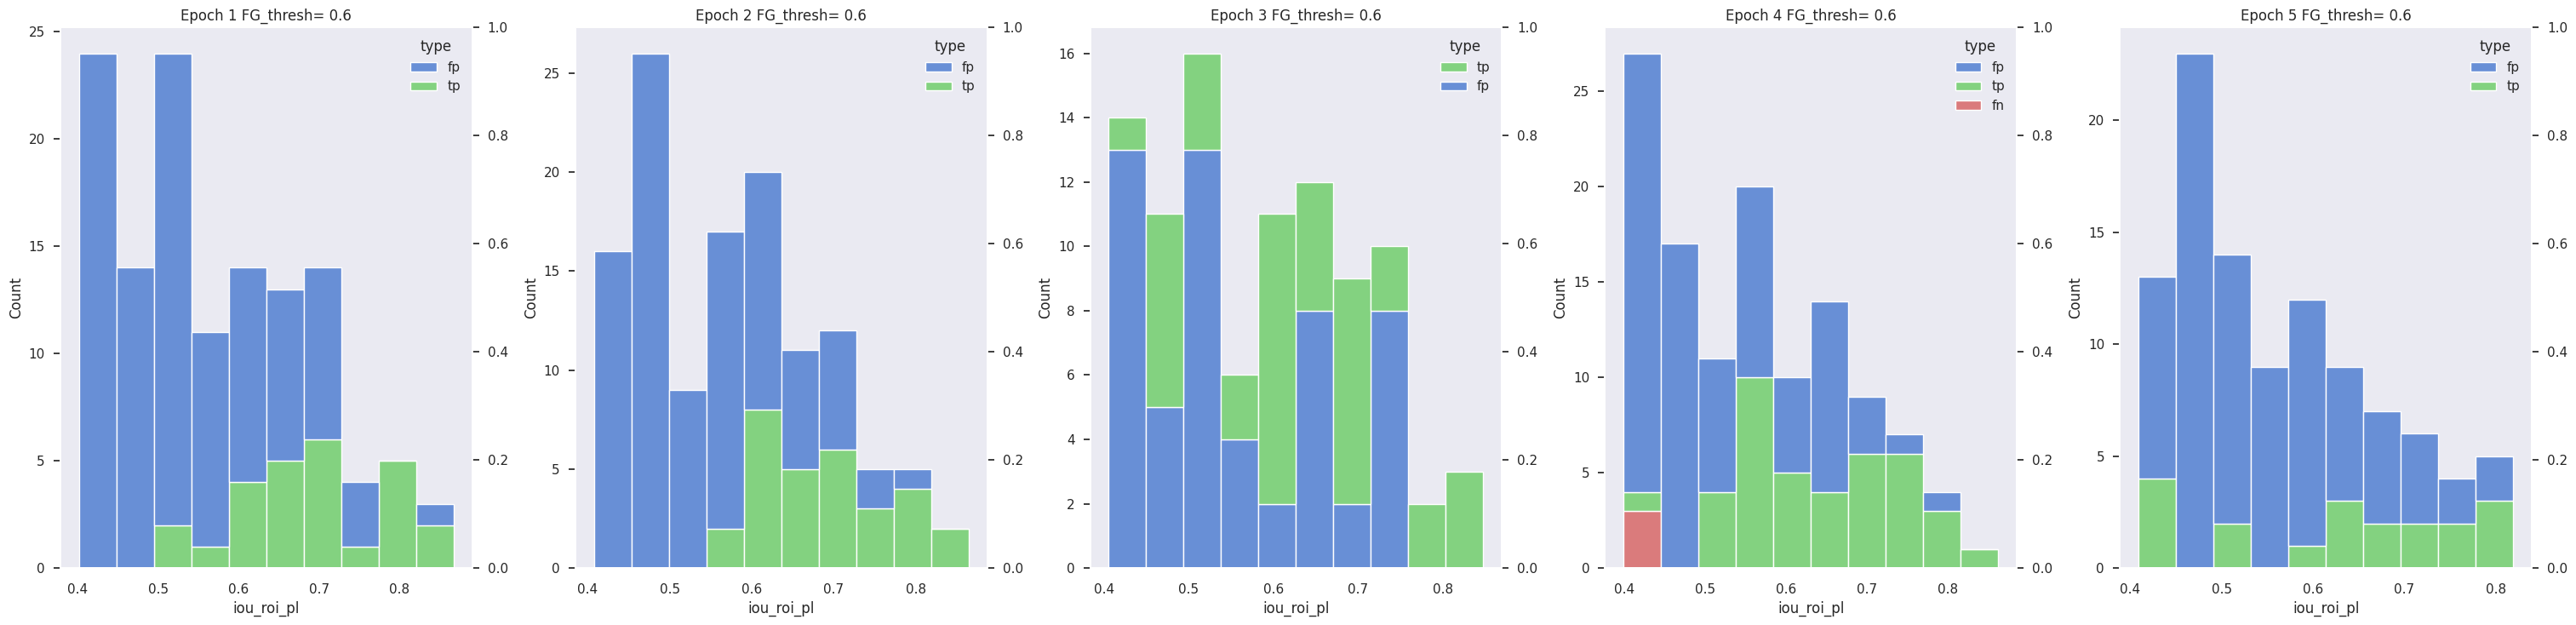

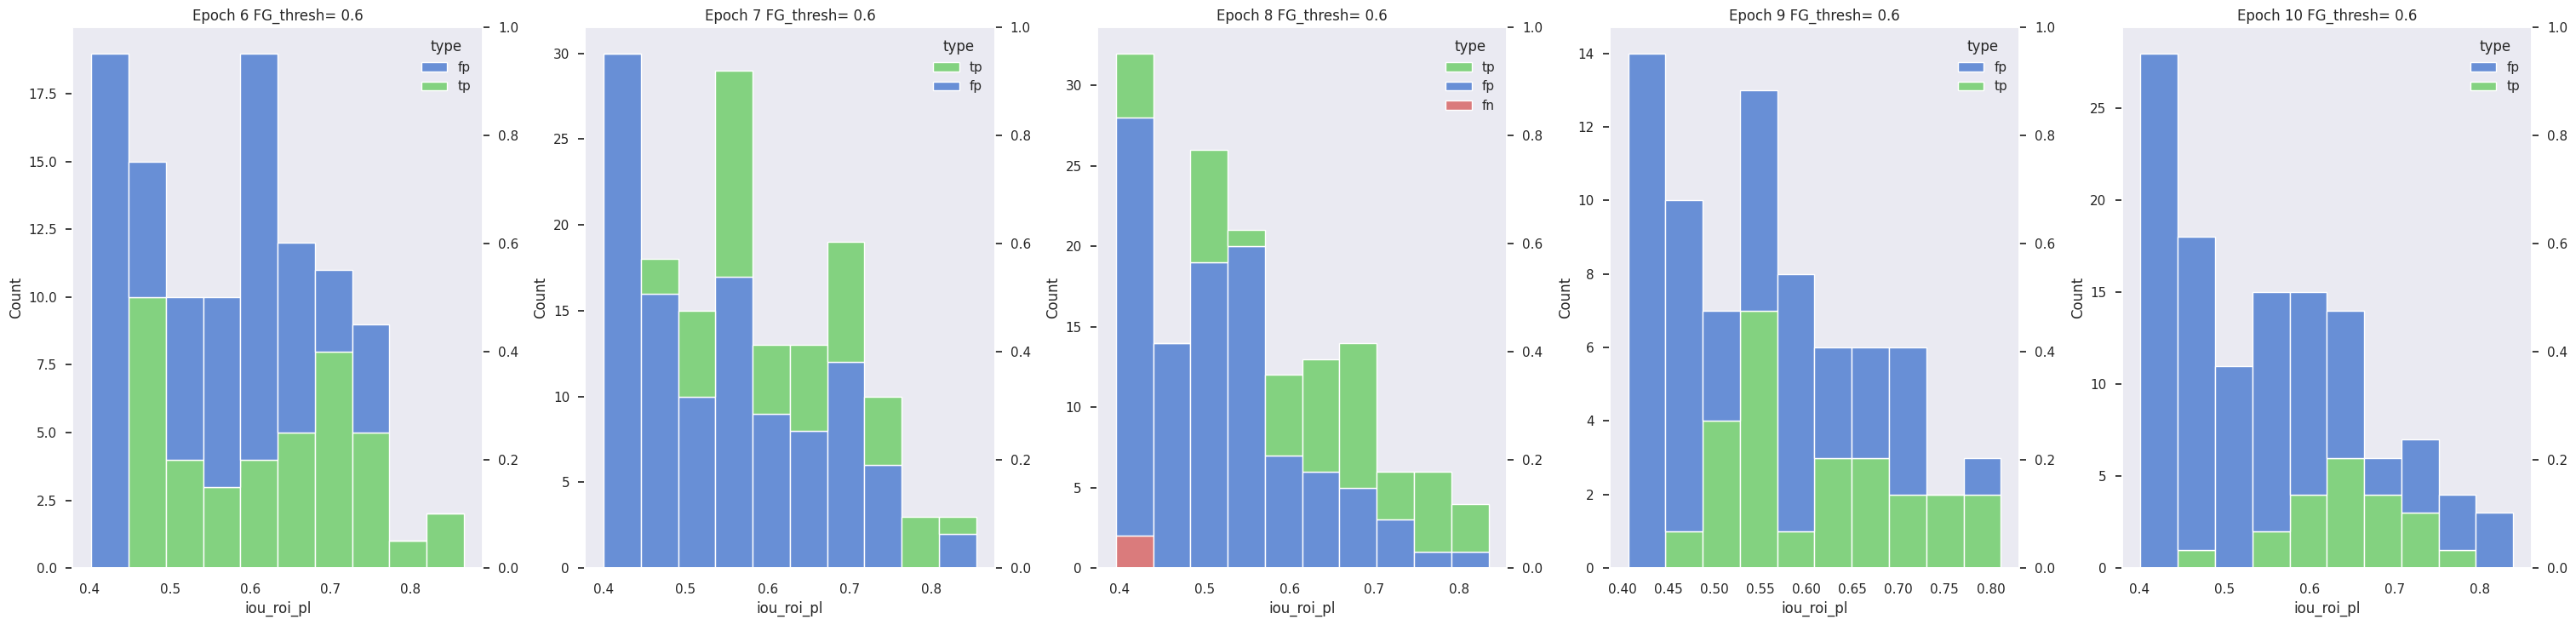

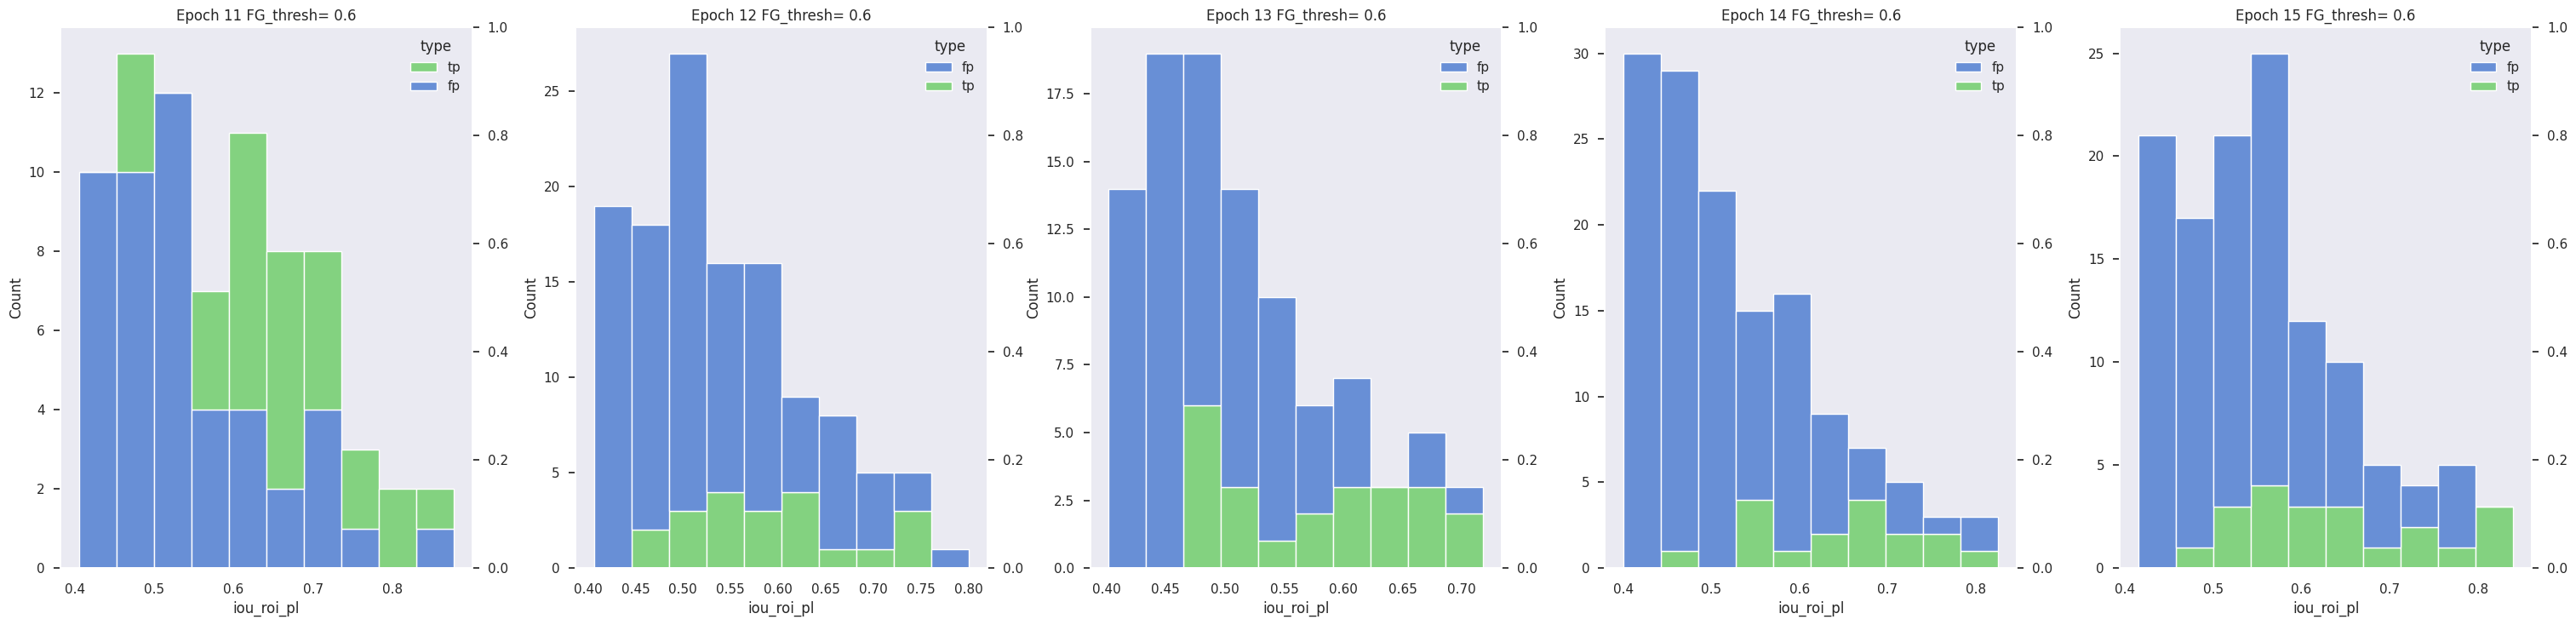

In [69]:
plot_epoch_iou(stats_df,'Cyc',1,6)
plot_epoch_iou(stats_df,'Cyc',6,11)
plot_epoch_iou(stats_df,'Cyc',11,16)

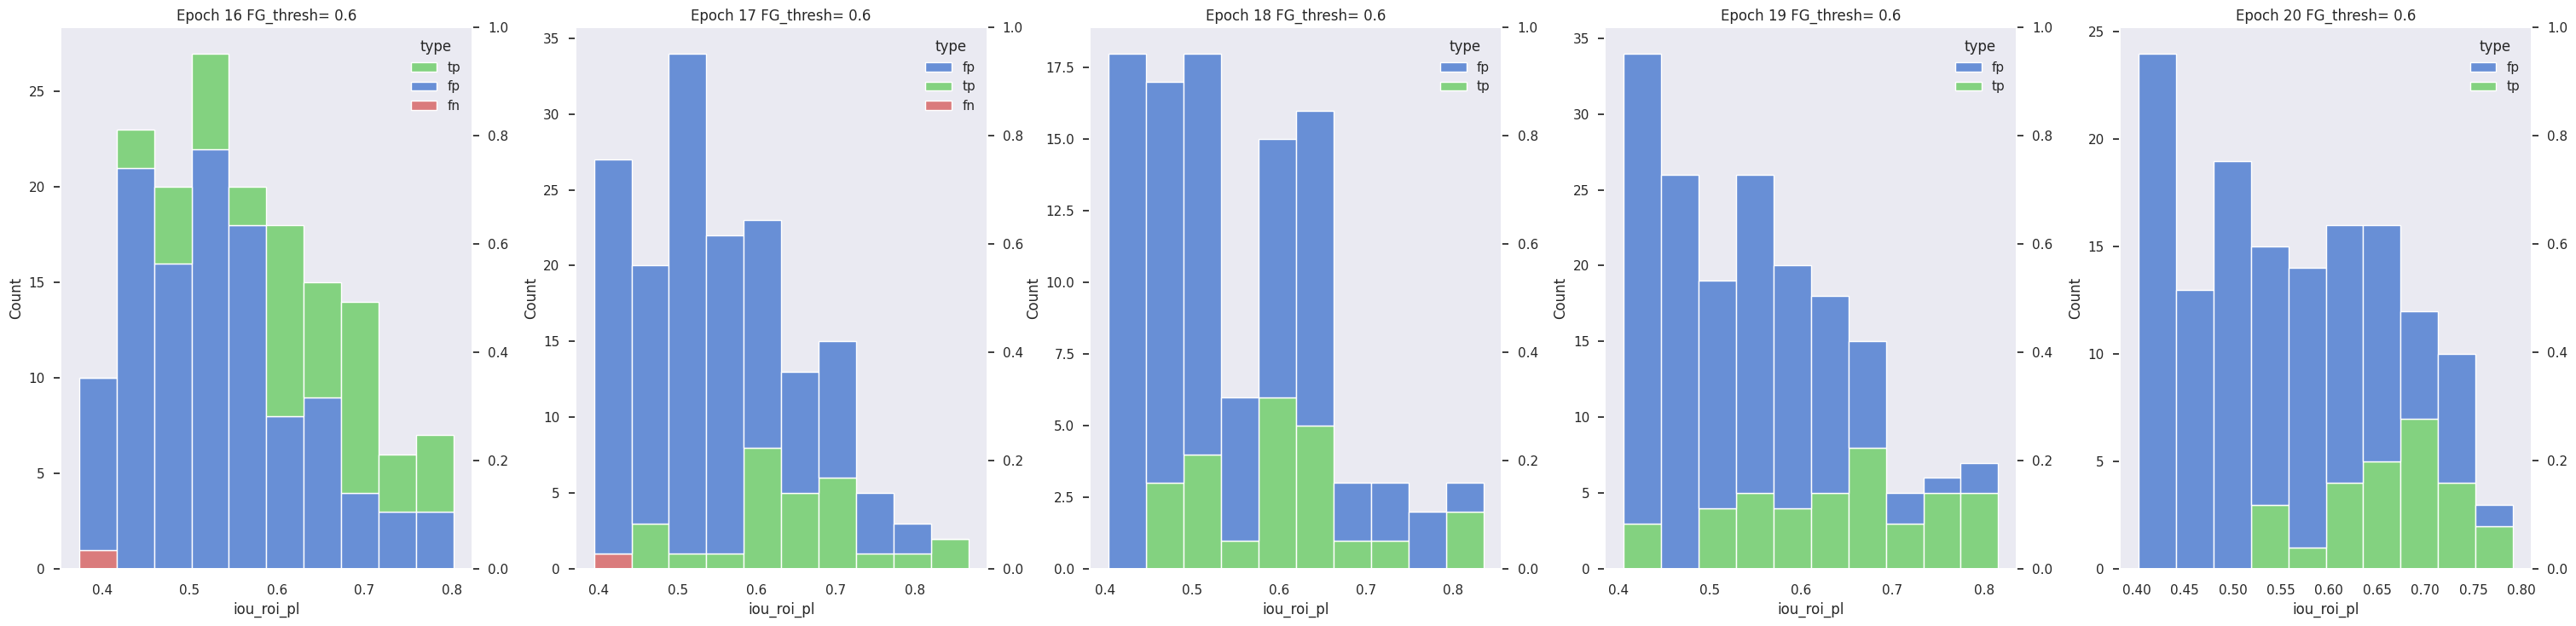

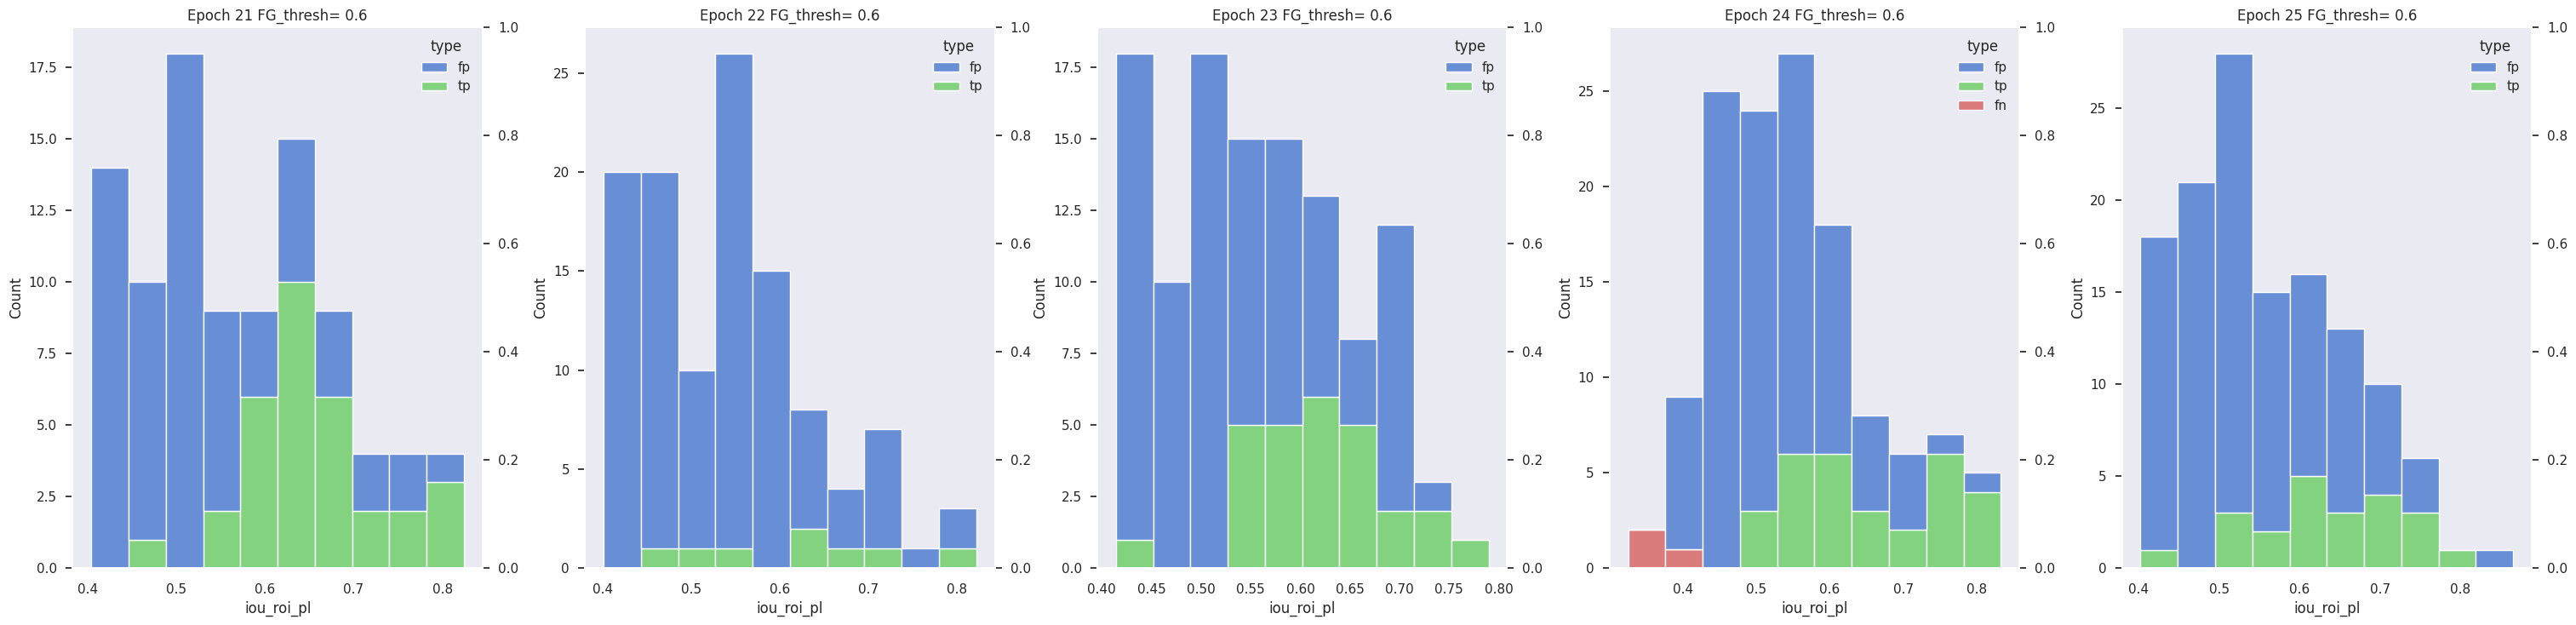

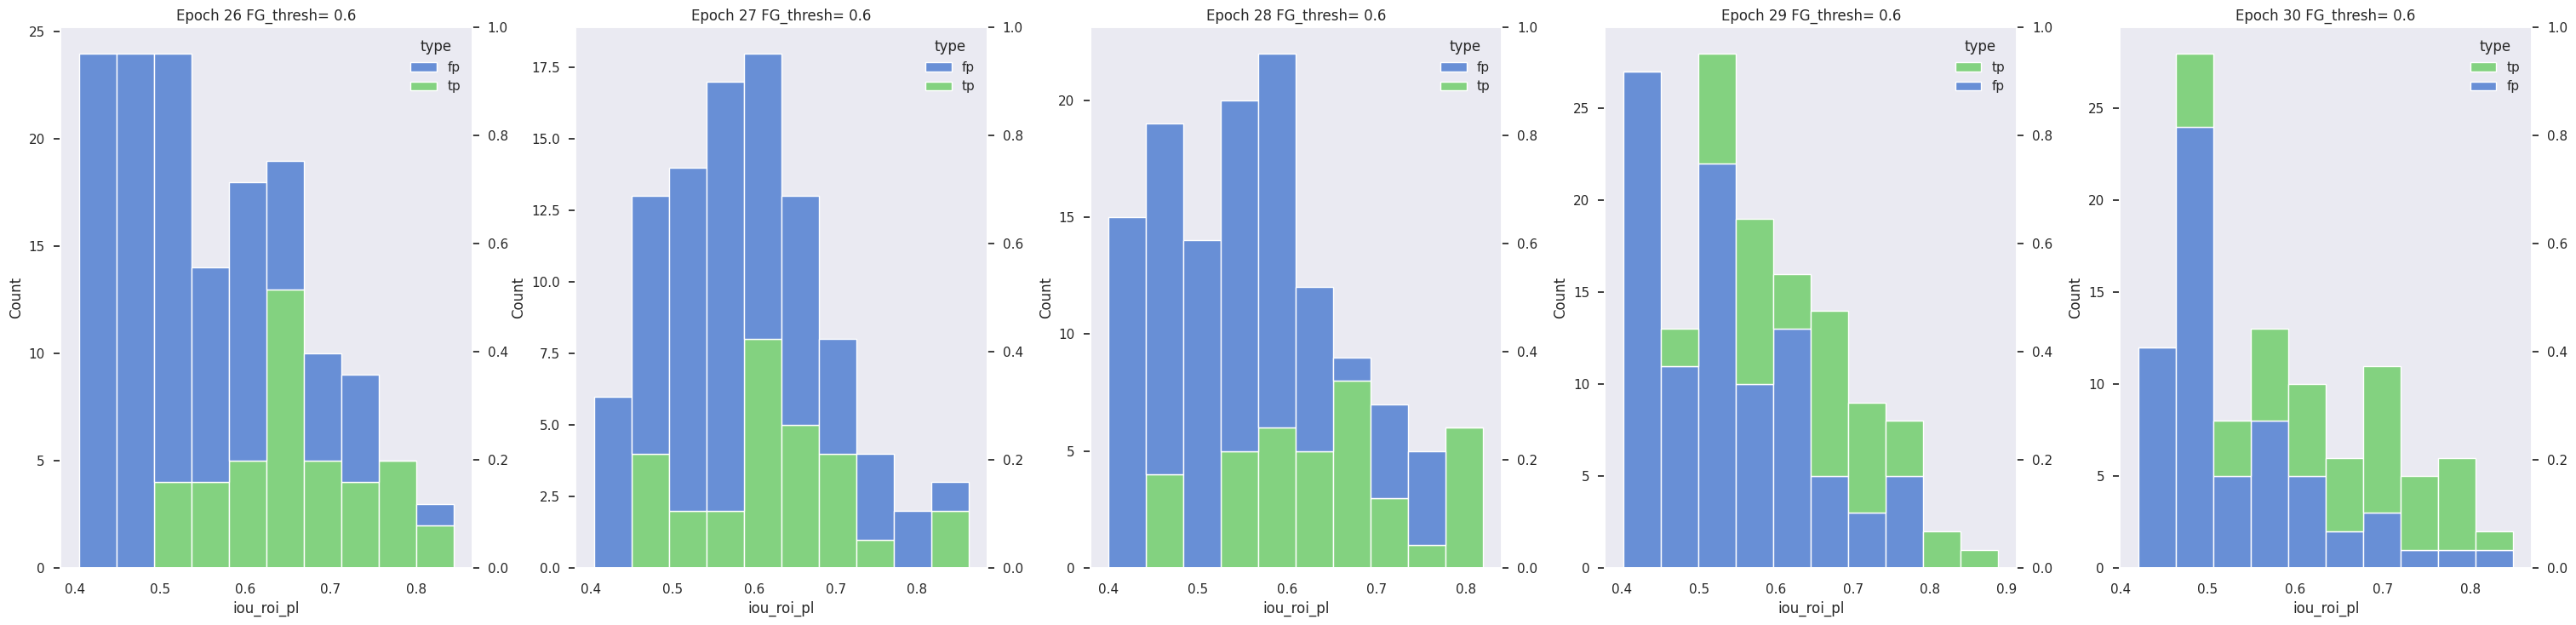

In [70]:
plot_epoch_iou(stats_df,'Cyc',16,21)
plot_epoch_iou(stats_df,'Cyc',21,26)
plot_epoch_iou(stats_df,'Cyc',26,31)

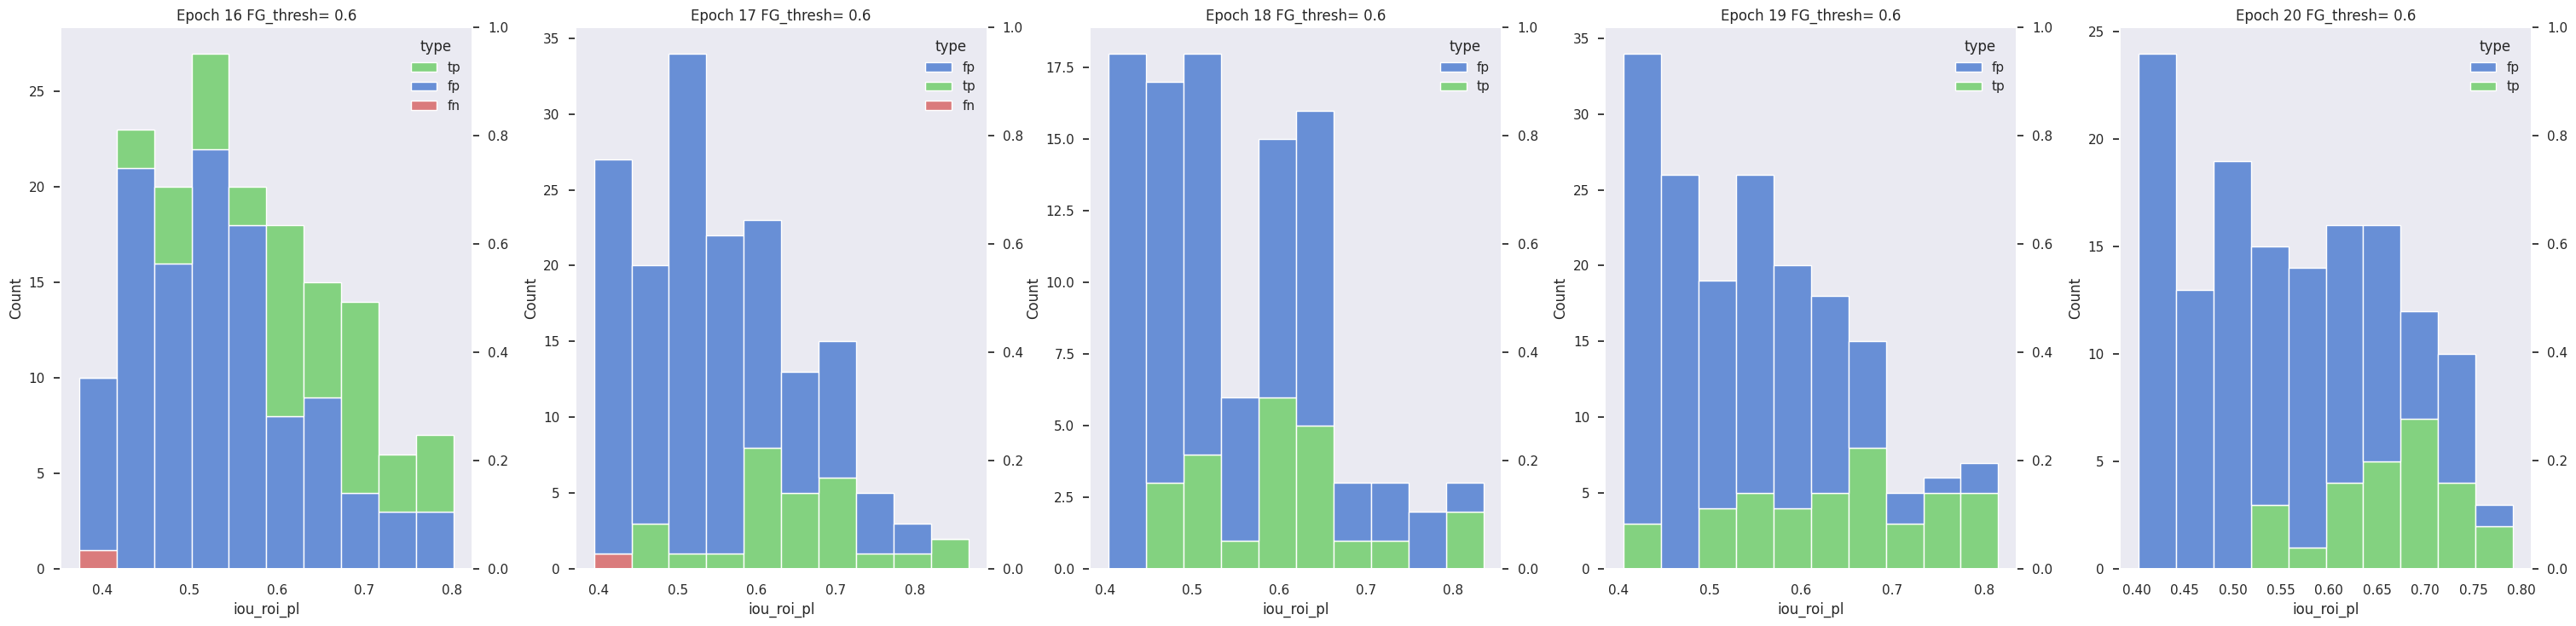

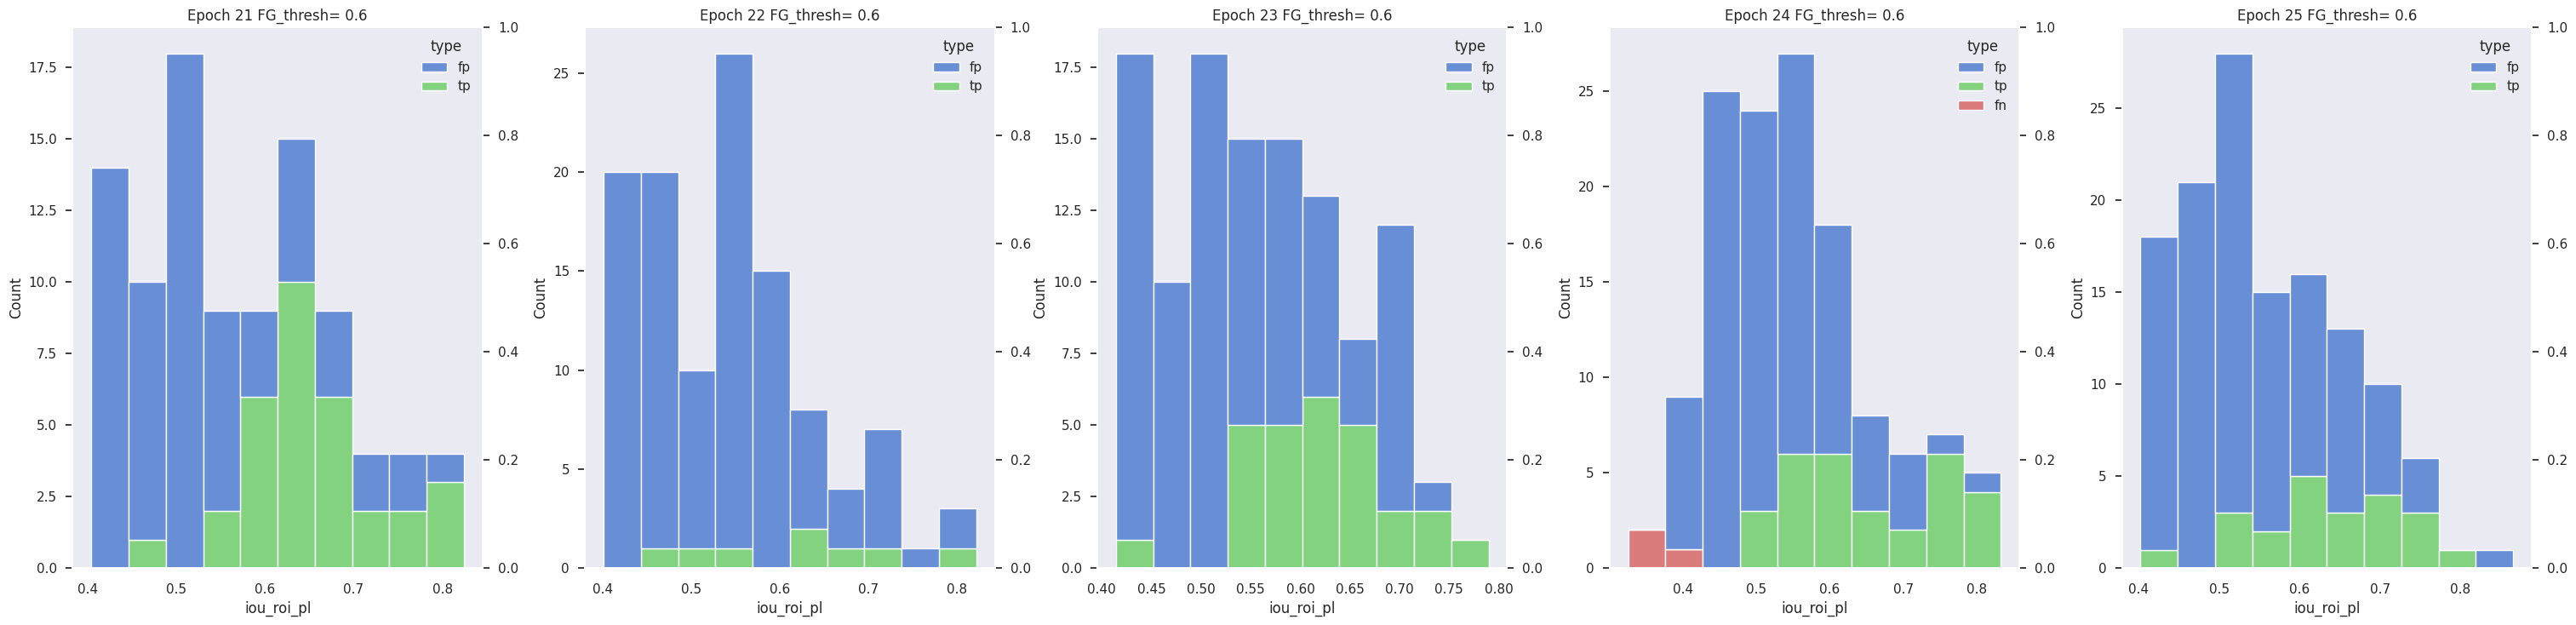

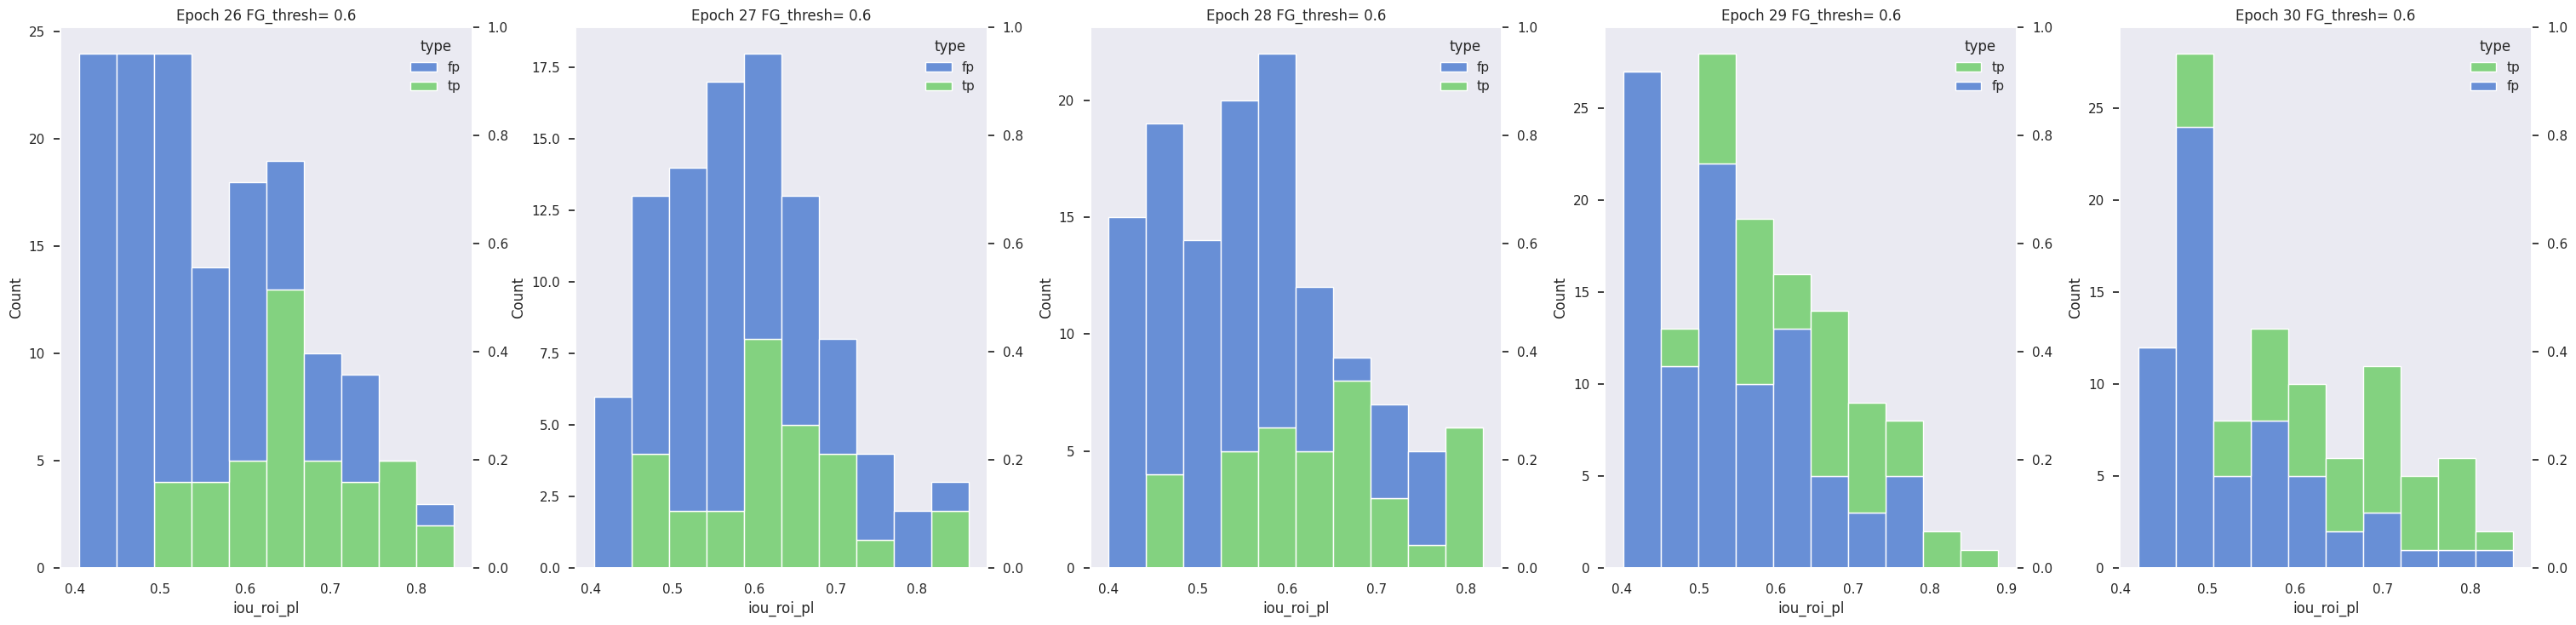

In [71]:
plot_epoch_iou(stats_df,'Cyc',16,21)
plot_epoch_iou(stats_df,'Cyc',21,26)
plot_epoch_iou(stats_df,'Cyc',26,31)

In [72]:
iou3d_ot_iou_df['variance'] = iou3d_ot_iou_df.groupby('epoch')['pred_scores'].transform('var')
iou3d_ot_iou_df['mean'] = iou3d_ot_iou_df.groupby('epoch')['pred_scores'].transform('mean')

In [73]:
iou3d_ot_iou_df

iou_roi_gt  iou_roi_pl  iteration  class_labels  pred_scores  \
0         0.594777    0.697189        0.0             1     0.924146   
1         0.686190    0.640282        0.0             1     0.880578   
2         0.000000    0.721479        0.0             1     0.771008   
3         0.000000    0.742094        0.0             2     0.814994   
4         0.000000    0.570624        0.0             1     0.601770   
...            ...         ...        ...           ...          ...   
707619    0.000000    0.259483     1439.0             3     0.001075   
707621    0.000000    0.545347     1439.0             2     0.049681   
707622    0.000000    0.430275     1439.0             2     0.370118   
707623    0.000000    0.369041     1439.0             3     0.003732   
707624    0.000000    0.545347     1439.0             2     0.051741   

        threshold  roi_scores  epoch  correct  fg_wrt_gt  variance      mean  
0             0.6    0.036497    1.0    False      False  0.115062  0.530350  
1             0.6    0.043485    1.0     True       True  0.115062  0.530350  
2             0.6    0.829503    1.0    False      False  0.115062  0.530350  
3             0.6    0.491779    1.0    False      False  0.115062  0.530350  
4             0.6    0.057287    1.0    False      False  0.115062  0.530350  
...           ...         ...    ...      ...        ...       ...       ...  
707619        0.6    0.034821   60.0    False      False  0.115940  0.423004  
707621        0.6    0.316081   60.0    False      False  0.115940  0.423004  
707622        0.6    0.096573   60.0    False      False  0.115940  0.423004  
707623        0.6    0.064122   60.0    False      False  0.115940  0.423004  
707624        0.6    0.316081   60.0    False      False  0.115940  0.423004  

[318283 rows x 12 columns]

In [74]:
iou3d_ot_iou_df['gaussian'] = iou3d_ot_iou_df.apply(gaussian,axis=1)
iou3d_ot_iou_df['gaussian'] = iou3d_ot_iou_df.apply(thresholding,axis=1)
grouped_ot_iouweights_df = iou3d_ot_iou_df.groupby('epoch')

In [75]:
iou3d_ot_iou_df['bins'] = iou3d_ot_iou_df['pred_scores'].apply(lambda x: round(x,1))

In [76]:
df = grouped_ot_iouweights_df.get_group(1)
iter_df = df[(df['bins'] == 0.9) & (df['class_labels']==1)]
iter_df[iter_df['fg_wrt_gt']==True].shape[0]/iter_df.shape[0]

0.6067415730337079

In [77]:
iou3d_ot_iou_df_thresh = iou3d_ot_iou_df[iou3d_ot_iou_df['pred_scores']>=0.4]
grouped_thresh_df = iou3d_ot_iou_df_thresh.groupby('epoch')

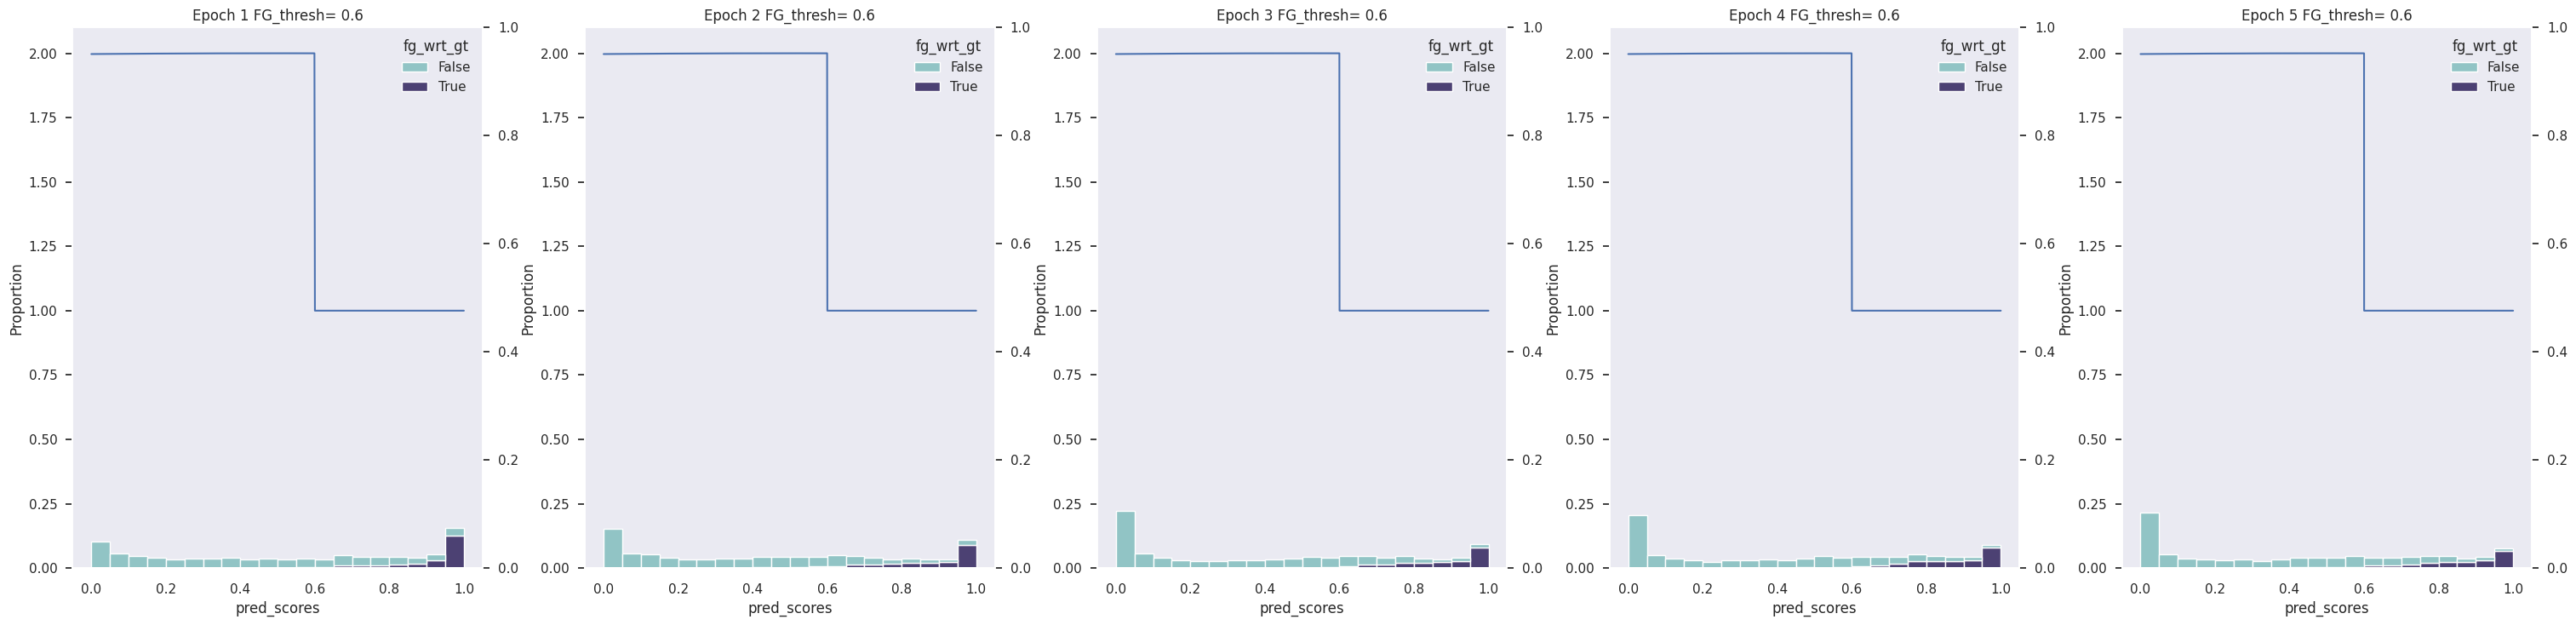

In [78]:
def plot_epoch_with_gaussian(grouped_df,start,end):
    p =sns.cubehelix_palette(start=.5, rot=-.5)
    palette = [p[1],p[4]]
    sns.set_theme(style='dark')
    f, axes = plt.subplots(1,end-start, figsize=(30,7.5))
    for i in range(start,end):
        # sns.histplot(ax=axes[0],data=grouped_ot_iou_df.get_group(float(i)),x='iou_roi_pl',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,legend=True,palette=palette,alpha=1.0)
        sns.histplot(ax=axes[i-start],data=grouped_df.get_group(float(i)),x='pred_scores',hue='fg_wrt_gt',multiple='stack',stat='proportion',bins=20,fill=True,palette=palette,alpha=1.0)
        sns.lineplot(ax=axes[i-start],x=grouped_df.get_group(float(i))['pred_scores'],y=grouped_df.get_group(float(i))['gaussian'])
        axes[i-start].set_title(f'Epoch {i} FG_thresh= {threshold}')
        f.tight_layout()
        f.subplots_adjust(wspace=0.25, hspace=0.2)
        ax2 = axes[i-start].twinx()
        ax2.set_ylim(0, 1)
    plt.show()
plot_epoch_with_gaussian(grouped_ot_iouweights_df,1,6)

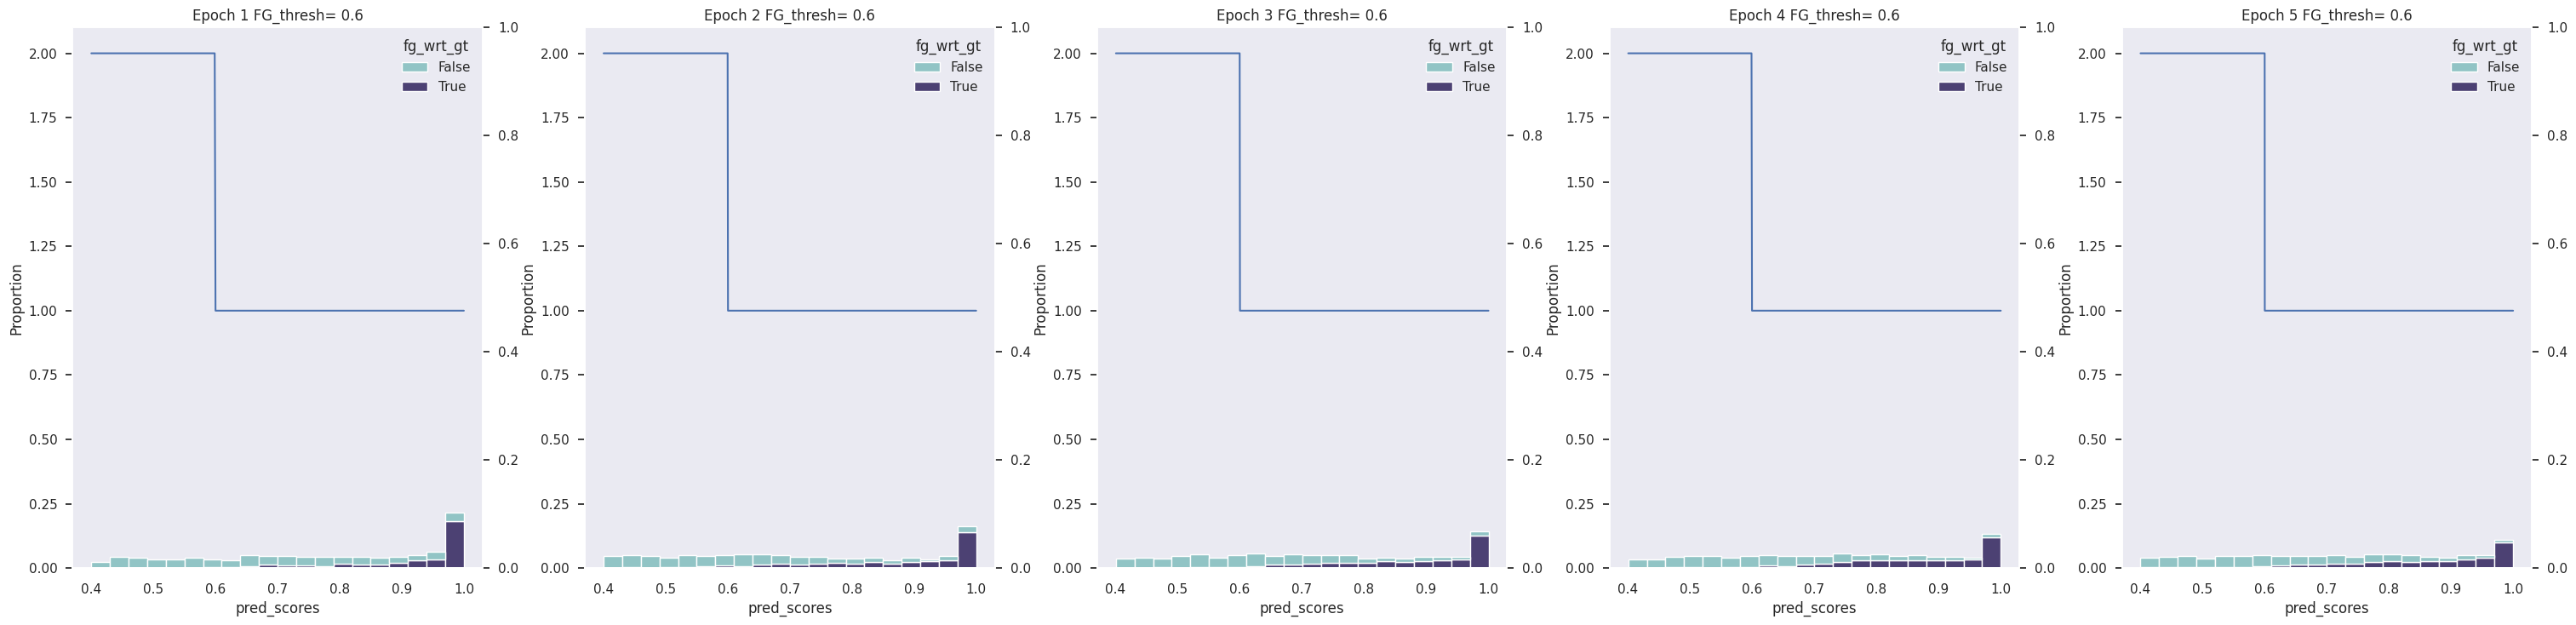

In [79]:
plot_epoch_with_gaussian(grouped_thresh_df,1,6)

In [80]:

from tqdm.notebook import tqdm

BATCH_SIZE = 8
WINDOW_SIZE = BATCH_SIZE * 4
MAX_PLT_COLS = 5
MAX_PLT_ROWS = 9
CLS_IDX = 1 # Analyzing car class
fg_gt_thresh = 0.75
fg_pl_thresh = [0.65, 0.45, 0.4]
pre_filtering_thresh = fg_pl_thresh[CLS_IDX-1]


# # stats_dict = {
# #   'iou_roi_gt': stats['iou_roi_gt'],
# #   'iou_roi_pl': stats['iou_roi_pl'],
# #   'iteration' : stats['iteration'],
# #   'class_labels': stats['class_labels'],
# #   'pred_scores': stats['pred_scores']
# # }
# # stats_df = pd.DataFrame(stats_dict)

# stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
# stats_df['iteration'] = stats_df['iteration'].astype('int32')


# stats_df = stats_df[pre_filtering_thresh <= stats_df['iou_roi_pl']]

# # watch out normalized only if not.
# stats['pred_scores'] = torch.tensor(stats['pred_scores']).sigmoid()

# # Add type column \in {tp, fp, tn, fn} column based on classwise thresholds
# stats_df['type'] = 'n/a'
# for cls_ind in range(3):
#      cls_mask = stats_df['class_labels'] == cls_ind + 1
#      tp_mask = (fg_gt_thresh <= stats_df['iou_roi_gt']) & (fg_pl_thresh[cls_ind] <= stats_df['iou_roi_pl'])
#      fp_mask = (stats_df['iou_roi_gt'] < fg_gt_thresh) & (fg_pl_thresh[cls_ind] <= stats_df['iou_roi_pl'])
#      fn_mask = (fg_gt_thresh <= stats_df['iou_roi_gt']) & (stats_df['iou_roi_pl'] < fg_pl_thresh[cls_ind])
#      tn_mask = (stats_df['iou_roi_gt'] < fg_gt_thresh) & (stats_df['iou_roi_pl'] < fg_pl_thresh[cls_ind])
#      stats_df['type'][tp_mask & cls_mask] = 'tp'
#      stats_df['type'][fp_mask & cls_mask] = 'fp'
#      stats_df['type'][fn_mask & cls_mask] = 'fn'
#      stats_df['type'][tn_mask & cls_mask] = 'tn'


# stats_df.reset_index(inplace=True)


"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt_window(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
  f, axes = plt.subplots(MAX_PLT_ROWS, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")

  palettes = {t: c for t, c in zip(stats_df.type.unique(), sns.color_palette("hls", 4))}
  hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp'])
  num_windows = stats_df.iteration.max() // window_size

  for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
    df_subgroups = []
    for it in range(window_size):
        try:
            subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
            df_subgroups.append(subgroup)
        except KeyError:
            break
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        sns.histplot(ax=ax, data=cls_df, x="iou_roi_pl", **hist_args)
        ax.set_title(f"Window {w}")

        if (w + 1) % MAX_PLT_COLS == 1: # First col
            ax.xaxis.set_tick_params(bottom=False)

        elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1: # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)

    f.tight_layout()
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

plot_corres_gt_window(stats_df)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

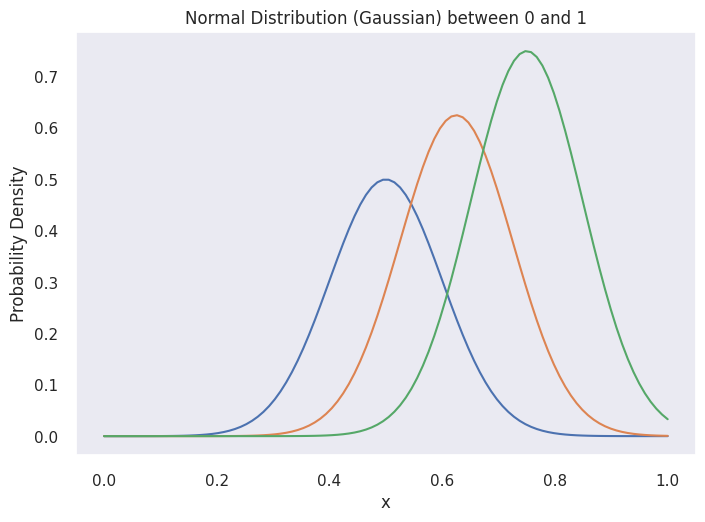

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    """
    Calculate the Gaussian probability density function (PDF) for a given input x,
    mean mu, and standard deviation sigma.
    
    Args:
        x (float or array-like): Input value(s) for which to calculate the PDF.
        mu (float): Mean of the Gaussian distribution.
        sigma (float): Standard deviation of the Gaussian distribution.
    
    Returns:
        float or ndarray: The probability density value(s) for the given input(s) x.
    """
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = mu
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.linspace(0.5,0.75,3)

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

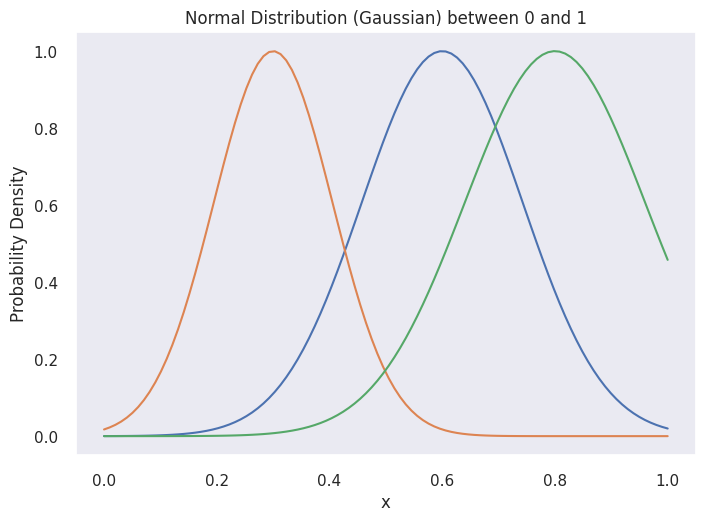

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2 / (mu*(4-mu))
    coefficient = 1 
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.array([0.6,0.3,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

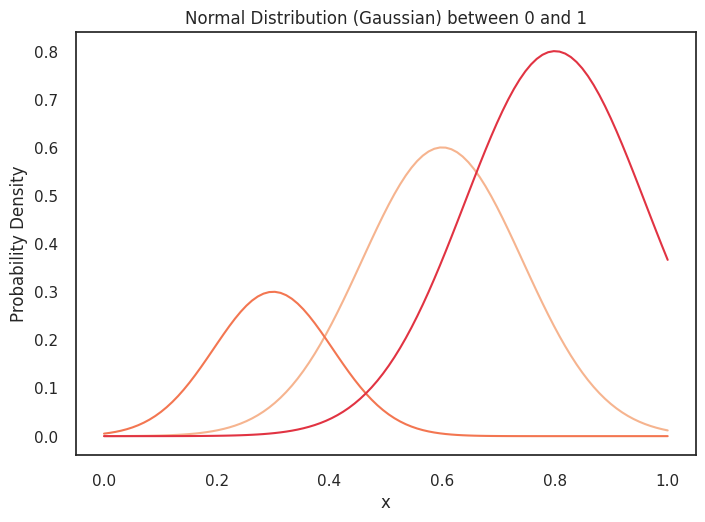

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2 / (mu*(4-mu))
    coefficient = mu 
    return coefficient * np.exp(exponent)

# Generate x values
x = np.linspace(0, 1, 100)
means = np.array([0.6,0.3,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")

# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()

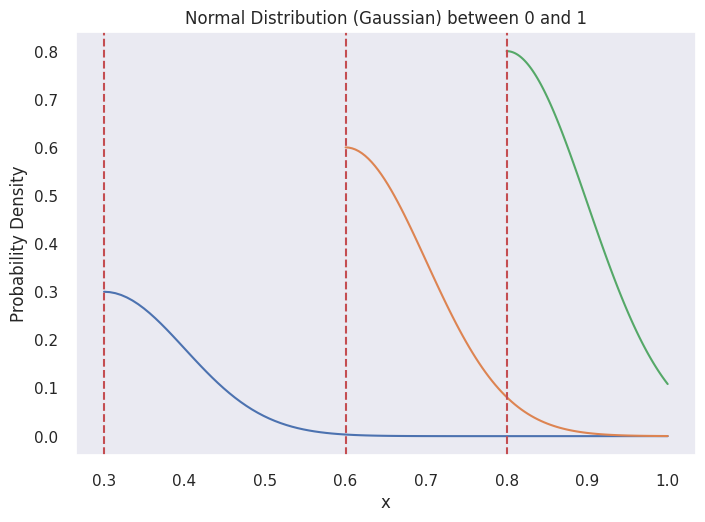

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 100)


def gaussian_plot(x, mu, sigma):
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    coefficient = mu
    return (coefficient * np.exp(exponent))

# Generate x values

means = np.array([0.3,0.6,0.8])

# Mean and standard deviation of the Gaussian distribution
mu = 0.5
sigma = 0.1
for mu in means:
    x = np.linspace(mu, 1.0, 100)
    pdf = gaussian_plot(x, mu, sigma)
    plt.plot(x, pdf,label=f"Mean = {mu}")
    plt.axvline(x=mu, color='r', linestyle='--', label='Vertical Line at x=1')
# Set plot title and labels
plt.title('Normal Distribution (Gaussian) between 0 and 1')
plt.xlabel('x')
plt.ylabel('Probability Density')

# Display the plot
plt.show()